In [1]:
#Import

import numpy as np
import matplotlib.pyplot as plt
from multipole_signal import Derivatives
from getdist import plots
from getdist.gaussian_mixtures import GaussianND
import fishermat as fm
import pickle as pk

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/danielsb/Documents/GitHub


In [2]:
# Redshift bins

z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95 ])

#z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55 ])


# Separations

dist = [
    np.arange(20, 164, 4),
    np.arange(32, 164, 4),
]

params_dict0 = {
    'h' : 0.677,
    'As' : 2.05e-9,
    'ns' : 0.965,
    'Ob' : 0.0490, # This is here the density parameter of Baryons
    'Om' : 0.3111, # This is here the density parameter of Cold Dark Matter
}

steps = [1e-3, 1e-1, 1e-4, 1e-2, 1e-2]

# JOINT ANALYSIS. 

### 50x50 vs 30x70 SPLITTINGS.

We run the analysis combining two different population splittings, combining the information as if they were two independent experiments. We include the cross correlations between the observables but assume the parameters of each population are independent. The signal looks like:

$$ \vec{\xi}(z,d) = (\{\xi_l^{\mathrm{LM}}(z,d)\}_{l=0,1,2,4}, \{\xi_l^{\mathrm{NP}}(z,d)\}_{l=0,1,2,4}) $$



## Derivatives (LOAD FROM FILE)

In [3]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_30x70 = derivatives_dict['split_30x70']

In [4]:
dsignal_dsbias50 = derivatives_50x50['dsignal_dsbias']

dsignal_dgbias50 = derivatives_50x50['dsignal_dgbias']

dsignal_dcosmic50 = derivatives_50x50['dsignal_dcosmic']

dsignal_dnum50 = derivatives_50x50['dsignal_dnumev']

np.shape(dsignal_dsbias50), np.shape(dsignal_dgbias50), np.shape(dsignal_dcosmic50), np.shape(dsignal_dnum50)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [5]:
dsignal_dsbias30 = derivatives_30x70['dsignal_dsbias']

dsignal_dgbias30 = derivatives_30x70['dsignal_dgbias']

dsignal_dcosmic30 = derivatives_30x70['dsignal_dcosmic']

dsignal_dnum30 = derivatives_30x70['dsignal_dnumev']

np.shape(dsignal_dsbias30), np.shape(dsignal_dgbias30), np.shape(dsignal_dcosmic30), np.shape(dsignal_dnum30)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [6]:
dsignal_dtheta50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50, dsignal_dcosmic50])

np.shape(dsignal_dtheta50)

(21, 19, 324)

In [7]:
dsignal_dtheta30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30, dsignal_dcosmic30])

np.shape(dsignal_dtheta30)

(21, 19, 324)

REMOVE HEXADECAPOLE FROM 50x50 split

In [8]:
n_sep = len(dist[0])
n_signals = int(len(dsignal_dtheta50[0,0])/n_sep)
ind_to_remove = list(range(7*n_sep,8*n_sep))

print('Number of separations = ', n_sep)
print('Number of signals = ', n_signals)
print('Indices to remove = ', ind_to_remove)

Number of separations =  36
Number of signals =  9
Indices to remove =  [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]


In [9]:
dsignal_dsB50 = np.concatenate([dsignal_dsbias50[:4], np.zeros_like(dsignal_dsbias50[:4])], axis=2)
dsignal_dsB30 = np.concatenate([np.zeros_like(dsignal_dsbias30[:4]), dsignal_dsbias30[:4]], axis=2)

dsignal_dsM = np.concatenate([dsignal_dsbias50[4:], dsignal_dsbias30[4:]], axis=2)
dsignal_dnum = np.concatenate([dsignal_dnum50, dsignal_dnum30], axis=2)
dsignal_dgbias50 = np.concatenate([dsignal_dgbias50, np.zeros_like(dsignal_dgbias50[:4])], axis=2)
dsignal_dgbias30 = np.concatenate([np.zeros_like(dsignal_dgbias30[:4]), dsignal_dgbias30], axis=2)
dsignal_dcosmic = np.concatenate([dsignal_dcosmic50, dsignal_dcosmic30], axis=2)

In [10]:
dsignal_dtheta_multi_ = np.concatenate([dsignal_dsB50, dsignal_dsB30, dsignal_dsM, dsignal_dnum, dsignal_dgbias50, dsignal_dgbias30, dsignal_dcosmic])

dsignal_dtheta_multi = np.delete(dsignal_dtheta_multi_, ind_to_remove, axis=2)


np.shape(dsignal_dtheta_multi_), np.shape(dsignal_dtheta_multi)

((29, 19, 648), (29, 19, 612))

## Covariance Matrix

In [11]:
# Create the PRIORS Cov Matrix for sB, sM, num

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

num_fit = np.array([7.94599872, -12.03752386, 2.29927261, -15.83887364])

sB_4fit50 = np.array([-0.90110745,  1.82300205, -1.01878441, -0.30342325])
sB_4fit30 = np.array([0.32517601, 0.64417733, 0.16141876, 0.13330362])

sM_4fit = np.array([-0.19376092,  1.07473357, -0.07806244, -0.00558004])

dsB_50 = sB_4fit50 * errB[0] 
dsB_30 = sB_4fit30 * errB[0] 

dsM = sM_4fit * errF[0]

dnum = num_fit * errB[1]

Cov_prior_all = np.diag(np.concatenate([dsB_50**2, dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_all_ = np.linalg.inv(Cov_prior_all)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_multi), len(dsignal_dtheta_multi)])
Inv_Cov_prior_all[:len(Inv_Cov_prior_all_), :len(Inv_Cov_prior_all_)] = Inv_Cov_prior_all_

np.shape(Cov_prior_all), np.shape(Inv_Cov_prior_all)

((16, 16), (29, 29))

In [12]:
Cov_Multipoles_Joint50x30_ = fm.cov_matrix_joint(d=dist[0], z_bins=z_bins, small_off_diagonal=True, splits=[50,30], rtol=1e-4, contributions='CC')

print('\n ... Remove the HEXADECAPOLE from 50x50 split ... \n')

Cov_Multipoles_Joint50x30 = np.delete(Cov_Multipoles_Joint50x30_, ind_to_remove, axis=1)
Cov_Multipoles_Joint50x30 = np.delete(Cov_Multipoles_Joint50x30, ind_to_remove, axis=2)

np.shape(Cov_Multipoles_Joint50x30_), np.shape(Cov_Multipoles_Joint50x30)


 ... Loading Covariance Matrices (Joint-splittings Analysis) [CC] [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Remove the HEXADECAPOLE from 50x50 split ... 



((19, 648, 648), (19, 612, 612))

In [13]:
# Check if Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Cov_Multipoles_Joint50x30_[n], Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-15), np.allclose(Cov_Multipoles_Joint50x30[n], Cov_Multipoles_Joint50x30[n].T, rtol = 1e-15))

0 True True
1 True True
2 True True
3 True True
4 True True


5 True True
6 True True
7 True True
8 True True
9 True True
10 True True
11 True True
12 True True
13 True True
14 True True
15 True True
16 True True
17 True True
18 True True


In [14]:
# Load the Covariance Matrix of the multipoles

Inv_Cov_Multipoles_Joint50x30_ = np.linalg.pinv(Cov_Multipoles_Joint50x30)

# Symmetrize the matrix

Inv_Cov_Multipoles_Joint50x30 = [0.5 * (Inv_Cov_Multipoles_Joint50x30_[i] + Inv_Cov_Multipoles_Joint50x30_[i].T) for i in range(len(z_bins))]

In [15]:
# Check if Inverse Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Inv_Cov_Multipoles_Joint50x30_[n], Inv_Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-1), np.allclose(Inv_Cov_Multipoles_Joint50x30[n], Inv_Cov_Multipoles_Joint50x30[n].T, rtol = 1e-3))

0 False True
1 False True
2 False True
3 False True
4 False True
5 False True
6 False True
7 False True
8 False True
9 False True
10 False True
11 False True
12 False True
13 False True
14 False True
15 False True
16 False True
17 False True
18 False True


In [16]:
# Build the Fisher Matrix

Fisher_Matrix_Joint50x30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_multi, inv_cov = Inv_Cov_Multipoles_Joint50x30_, z_bins = z_bins)
Fisher_Matrix_Joint50x30 = Fisher_Matrix_Joint50x30_ + Inv_Cov_prior_all

np.shape(Fisher_Matrix_Joint50x30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(29, 29)

In [17]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[:8,:8]]))

25435.04065960762	10539.806217104255	-30106.782218506054	50817.992896224576	-3784.126901638079	-582.2944785826486	7138.146585544191	-13527.892816044807
10539.806217104255	7118.278916412277	-6273.934123908787	8999.523147358728	-582.2944785826486	-98.06746051819982	1075.6946575454447	-2031.3084455668713
-30106.782218506065	-6273.934123908788	50821.846751578014	-91732.06905506585	7138.14658554419	1075.6946575454447	-13527.892816044807	25660.632470351393
50817.992896224576	8999.523147358728	-91732.06905506585	170725.74479938112	-13527.892816044805	-2031.3084455668713	25660.632470351393	-48687.35197042828
-3784.1269016378997	-582.2944785825989	7138.1465855439255	-13527.892816044341	7869.971855733911	3175.404117665546	-9662.446430659593	16832.58707862729
-582.2944785825989	-98.06746051817949	1075.6946575453921	-2031.3084455667936	3175.404117665546	2226.710898768899	-1853.5111371918495	2870.77671638448
7138.146585543925	1075.6946575453921	-13527.892816044343	25660.63247035055	-9662.4464306595

In [18]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[8:16,8:16]]))

98511.4223002197	51878.530254862424	-74983.70152888748	82045.20003351876	3687.010010923357	1835.4973669254518	9423.441218781516	2303.717171214225
51878.530254862424	34140.22239806011	-27163.518500556336	25741.0712559241	1835.4973669254518	1135.5123062618823	3687.0100109233567	1025.3346255311415
-74983.70152888748	-27163.518500556343	82701.61087820739	-102935.3203570916	-3004.7375145162787	-1072.2173648994772	-10019.21595157813	-2121.709829991542
82045.20003351876	25741.071255924107	-102935.3203570916	273095.81534641003	3341.7742230950016	1026.001887856154	13012.160025455152	2479.9738700371254
3687.0100109233676	1835.4973669254564	-3004.7375145162887	3341.774223095012	146.4530750215973	69.03321543816642	391.5188315875635	93.59146124997574
1835.497366925456	1135.5123062618843	-1072.2173648994806	1026.0018878561568	69.03321543816641	40.308493076015274	146.38972263067723	39.78254664769148
9423.441218781541	3687.010010923367	-10019.215951578157	13012.160025455192	391.5188315875634	146.38972

In [19]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[16:,16:]]))

40203305.93366422	11496451.694932638	-26823194.465562586	-7561637.599744124	-12179649.420286123	-3250953.3986017513	-6860871.826928894	-2354030.8464123695	1532881.1472582337	817995.0858633553	-775100.4316078593	-4514861.54389251	-2946034.7951959274
11496451.694932636	4207523.134046101	-7561637.599744133	-2606541.2942381487	-3250953.398601751	-1145706.7318278104	-2354030.84641237	-1009993.8753136186	750034.9574694668	365633.27369160875	-272429.0141504772	-2324777.800521178	-570601.9387298817
-26823194.465548173	-7561637.59974207	55870913.90584856	16238873.288684564	-1474253.0719800738	-606093.3804568024	-13396757.572329909	-3514245.820454302	936856.5295807917	-91612.96639477325	1344025.8564389707	-4801870.554709438	8883750.878601205
-7561637.599742072	-2606541.2942378176	16238873.288684577	6016153.35283526	-606093.3804568023	-305875.25969342486	-3514245.8204543022	-1214832.1886314282	250097.27686210032	-47010.574888310264	424932.23073489254	-1373421.6158119042	2322367.148052691
-1217964

In [20]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[16:24,16:24]]))

40203305.93366422	11496451.694932638	-26823194.465562586	-7561637.599744124	-12179649.420286123	-3250953.3986017513	-6860871.826928894	-2354030.8464123695
11496451.694932636	4207523.134046101	-7561637.599744133	-2606541.2942381487	-3250953.398601751	-1145706.7318278104	-2354030.84641237	-1009993.8753136186
-26823194.465548173	-7561637.59974207	55870913.90584856	16238873.288684564	-1474253.0719800738	-606093.3804568024	-13396757.572329909	-3514245.820454302
-7561637.599742072	-2606541.2942378176	16238873.288684577	6016153.35283526	-606093.3804568023	-305875.25969342486	-3514245.8204543022	-1214832.1886314282
-12179649.420342501	-3250953.398604417	-1474253.0719507628	-606093.3804566253	41428940.82250327	10454556.355891936	-45498658.630790606	-11348649.836061984
-3250953.398604418	-1145706.7318275007	-606093.3804566249	-305875.25969391613	10454556.355891934	3441939.719465029	-11348649.836061994	-3518493.3850797503
-6860871.826876394	-2354030.8464126824	-13396757.572343051	-3514245.8204502

In [21]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[24:,24:]]))

7591793.934783231	2450900.20826025	872318.806291382	-28521967.28597999	10071012.189185843
2450900.2082601637	842136.935064101	191703.6721427996	-8836481.932574857	3130175.916211224
872318.8062913612	191703.672142766	405176.6735838873	-3371337.280572514	2247736.7793574613
-28521967.28597992	-8836481.932575062	-3371337.280572675	116314015.84008162	-36528391.58798761
10071012.189185796	3130175.916211284	2247736.7793575376	-36528391.5879874	21089773.850896377


In [22]:
print(np.allclose(Fisher_Matrix_Joint50x30, Fisher_Matrix_Joint50x30.T, rtol=1e-6))

True


In [23]:
print(np.allclose(Fisher_Matrix_Joint50x30[:-5,:-5], Fisher_Matrix_Joint50x30[:-5,:-5].T, rtol=1e-6))

True


In [24]:
np.linalg.det(Fisher_Matrix_Joint50x30)

7.122336461043381e+121

In [25]:
Fisher_Matrix_Joint50x30__ = 0.5 * (Fisher_Matrix_Joint50x30 + Fisher_Matrix_Joint50x30.T)

In [26]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30__[16:,16:]]))

40203305.93366422	11496451.694932636	-26823194.465555377	-7561637.599743098	-12179649.420314312	-3250953.3986030845	-6860871.826902645	-2354030.8464125264	1532881.1472579462	817995.0858632617	-775100.43160781	-4514861.543891793	-2946034.7951926338
11496451.694932636	4207523.134046101	-7561637.599743102	-2606541.2942379834	-3250953.398603084	-1145706.7318276556	-2354030.8464125264	-1009993.8753141968	750034.9574694964	365633.2736916281	-272429.0141504825	-2324777.800521317	-570601.9387296084
-26823194.465555377	-7561637.599743102	55870913.90584856	16238873.28868457	-1474253.0719654183	-606093.3804567137	-13396757.57233648	-3514245.8204522654	936856.5295804902	-91612.96639492217	1344025.85643898	-4801870.554708529	8883750.878599472
-7561637.599743098	-2606541.2942379834	16238873.28868457	6016153.35283526	-606093.3804567137	-305875.2596936705	-3514245.8204522645	-1214832.1886306924	250097.2768619859	-47010.57488836082	424932.23073489725	-1373421.615811549	2322367.148052564
-12179649.42031

In [27]:
np.linalg.det(Fisher_Matrix_Joint50x30[:-5, :-5])

1.7764357268740255e+93

In [28]:
np.linalg.det(Fisher_Matrix_Joint50x30__[:-5, :-5])

1.7764357268748332e+93

In [29]:
np.linalg.det(Fisher_Matrix_Joint50x30__)

7.122336461049049e+121

In [30]:
np.linalg.det(Fisher_Matrix_Joint50x30)

7.122336461043381e+121

## Constraints

In [31]:
#Absolute Errors

Sigma_Matrix_Joint50x30 = np.linalg.inv(Fisher_Matrix_Joint50x30)

Abs_Errors_all_Joint = np.sqrt(np.diag(Sigma_Matrix_Joint50x30))

# Fiducial values

sB_fit = np.concatenate([sB_4fit50, sB_4fit30]) 
gbias_fit = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sB_fit, sM_4fit, num_fit, gbias_fit, cosmic_fid])

# Relative errors

Rel_Errors_all_Joint = np.abs(Abs_Errors_all_Joint/params_fid)

par_errors_all_Joint = Rel_Errors_all_Joint * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [28.32817994 15.37425773 23.25659381 22.12125415]

sB_30 =  [31.05091945 34.09241083 43.14192283 20.85516023]

s_model =  [33.74544355 16.52718533 40.35153799 49.81149983]

number =  [39.51213355 24.27487589 17.80737602 26.78301192]

gbias_50 =  [0.18848943 0.30735108 0.16395686 0.23195861]

gbias_30 =  [0.21116231 0.35334471 0.1603515  0.22638288]

cosmic =  [0.99706174 0.53885388 0.78986997 1.14045472 0.3635943 ]



In [32]:
np.linalg.det(Fisher_Matrix_Joint50x30), np.linalg.det(Sigma_Matrix_Joint50x30)

(7.122336461043381e+121, 1.4040336418672785e-122)

In [33]:
def isPSD(A, tol=1e-4):
    E = np.linalg.eigvals(A)
    return E, np.all(E > -tol)

# Example usage:
# Your matrix
A = np.array([[1, 2], [2, 4]])
# Check if A is positive semi-definite
print(isPSD(A))

(array([0., 5.]), True)


In [34]:
print(isPSD(Fisher_Matrix_Joint50x30[:-5,:-5], tol=1e-10))

(array([1.34299681e+08, 8.08813890e+07, 3.66341780e+07, 2.80081513e+06,
       1.76282338e+06, 1.37989077e+06, 8.42579810e+05, 4.06277893e+05,
       2.38794689e+05, 1.06604222e+05, 9.15122243e+04, 4.59873988e+04,
       2.12831328e+04, 8.07513366e+03, 8.80213959e+02, 4.83466956e+02,
       2.50542836e+02, 7.15441374e+01, 2.69948174e+01, 1.76410843e+01,
       5.76920298e+00, 1.00944859e+00, 1.39692451e-01, 3.51783328e-02]), True)


In [35]:
print(isPSD(Sigma_Matrix_Joint50x30, tol=1e-10))

(array([2.84266636e+01, 7.15862370e+00, 9.90702479e-01, 1.73340177e-01,
       5.66865216e-02, 3.70472619e-02, 1.39784249e-02, 3.99272866e-03,
       2.06851653e-03, 1.13748527e-03, 3.61840416e-04, 1.23942283e-04,
       4.69868958e-05, 2.22406716e-05, 1.72656542e-05, 9.44912150e-06,
       8.76879696e-06, 4.18319852e-06, 2.76177095e-06, 2.40389180e-06,
       1.20282195e-06, 9.72117306e-07, 6.34417973e-07, 4.05140262e-07,
       1.45586654e-07, 2.72219428e-08, 1.22176074e-08, 7.66764966e-09,
       7.01187408e-09]), True)


In [36]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_Joint50x30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [1.42615225e+08 1.30418061e+08 8.18490861e+07 3.67350709e+07
 6.86876146e+06 2.46828097e+06 1.57624790e+06 1.02868244e+06
 8.31378246e+05 4.15992101e+05 3.62086508e+05 2.39051528e+05
 1.14040729e+05 1.05829944e+05 5.79184540e+04 4.49626710e+04
 2.12825296e+04 8.06827157e+03 2.76364927e+03 8.79132266e+02
 4.83438245e+02 2.50455286e+02 7.15388185e+01 2.69925481e+01
 1.76408778e+01 5.76900300e+00 1.00938478e+00 1.39691656e-01
 3.51782402e-02]
Condition number of A: 4054075021.534381


In [37]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_Joint50x30.shape[0], Fisher_Matrix_Joint50x30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_Joint50x30 @ A_plus

In [38]:
np.allclose(A_plus, Sigma_Matrix_Joint50x30, rtol=1e-20)

True

In [39]:
np.linalg.det(A_plus), np.linalg.det(Sigma_Matrix_Joint50x30)

(1.404033642269681e-122, 1.4040336418672785e-122)

In [40]:
np.prod(s), np.linalg.det(Fisher_Matrix_Joint50x30)

(7.1223364590055495e+121, 7.122336461043381e+121)

## Triangle Plots

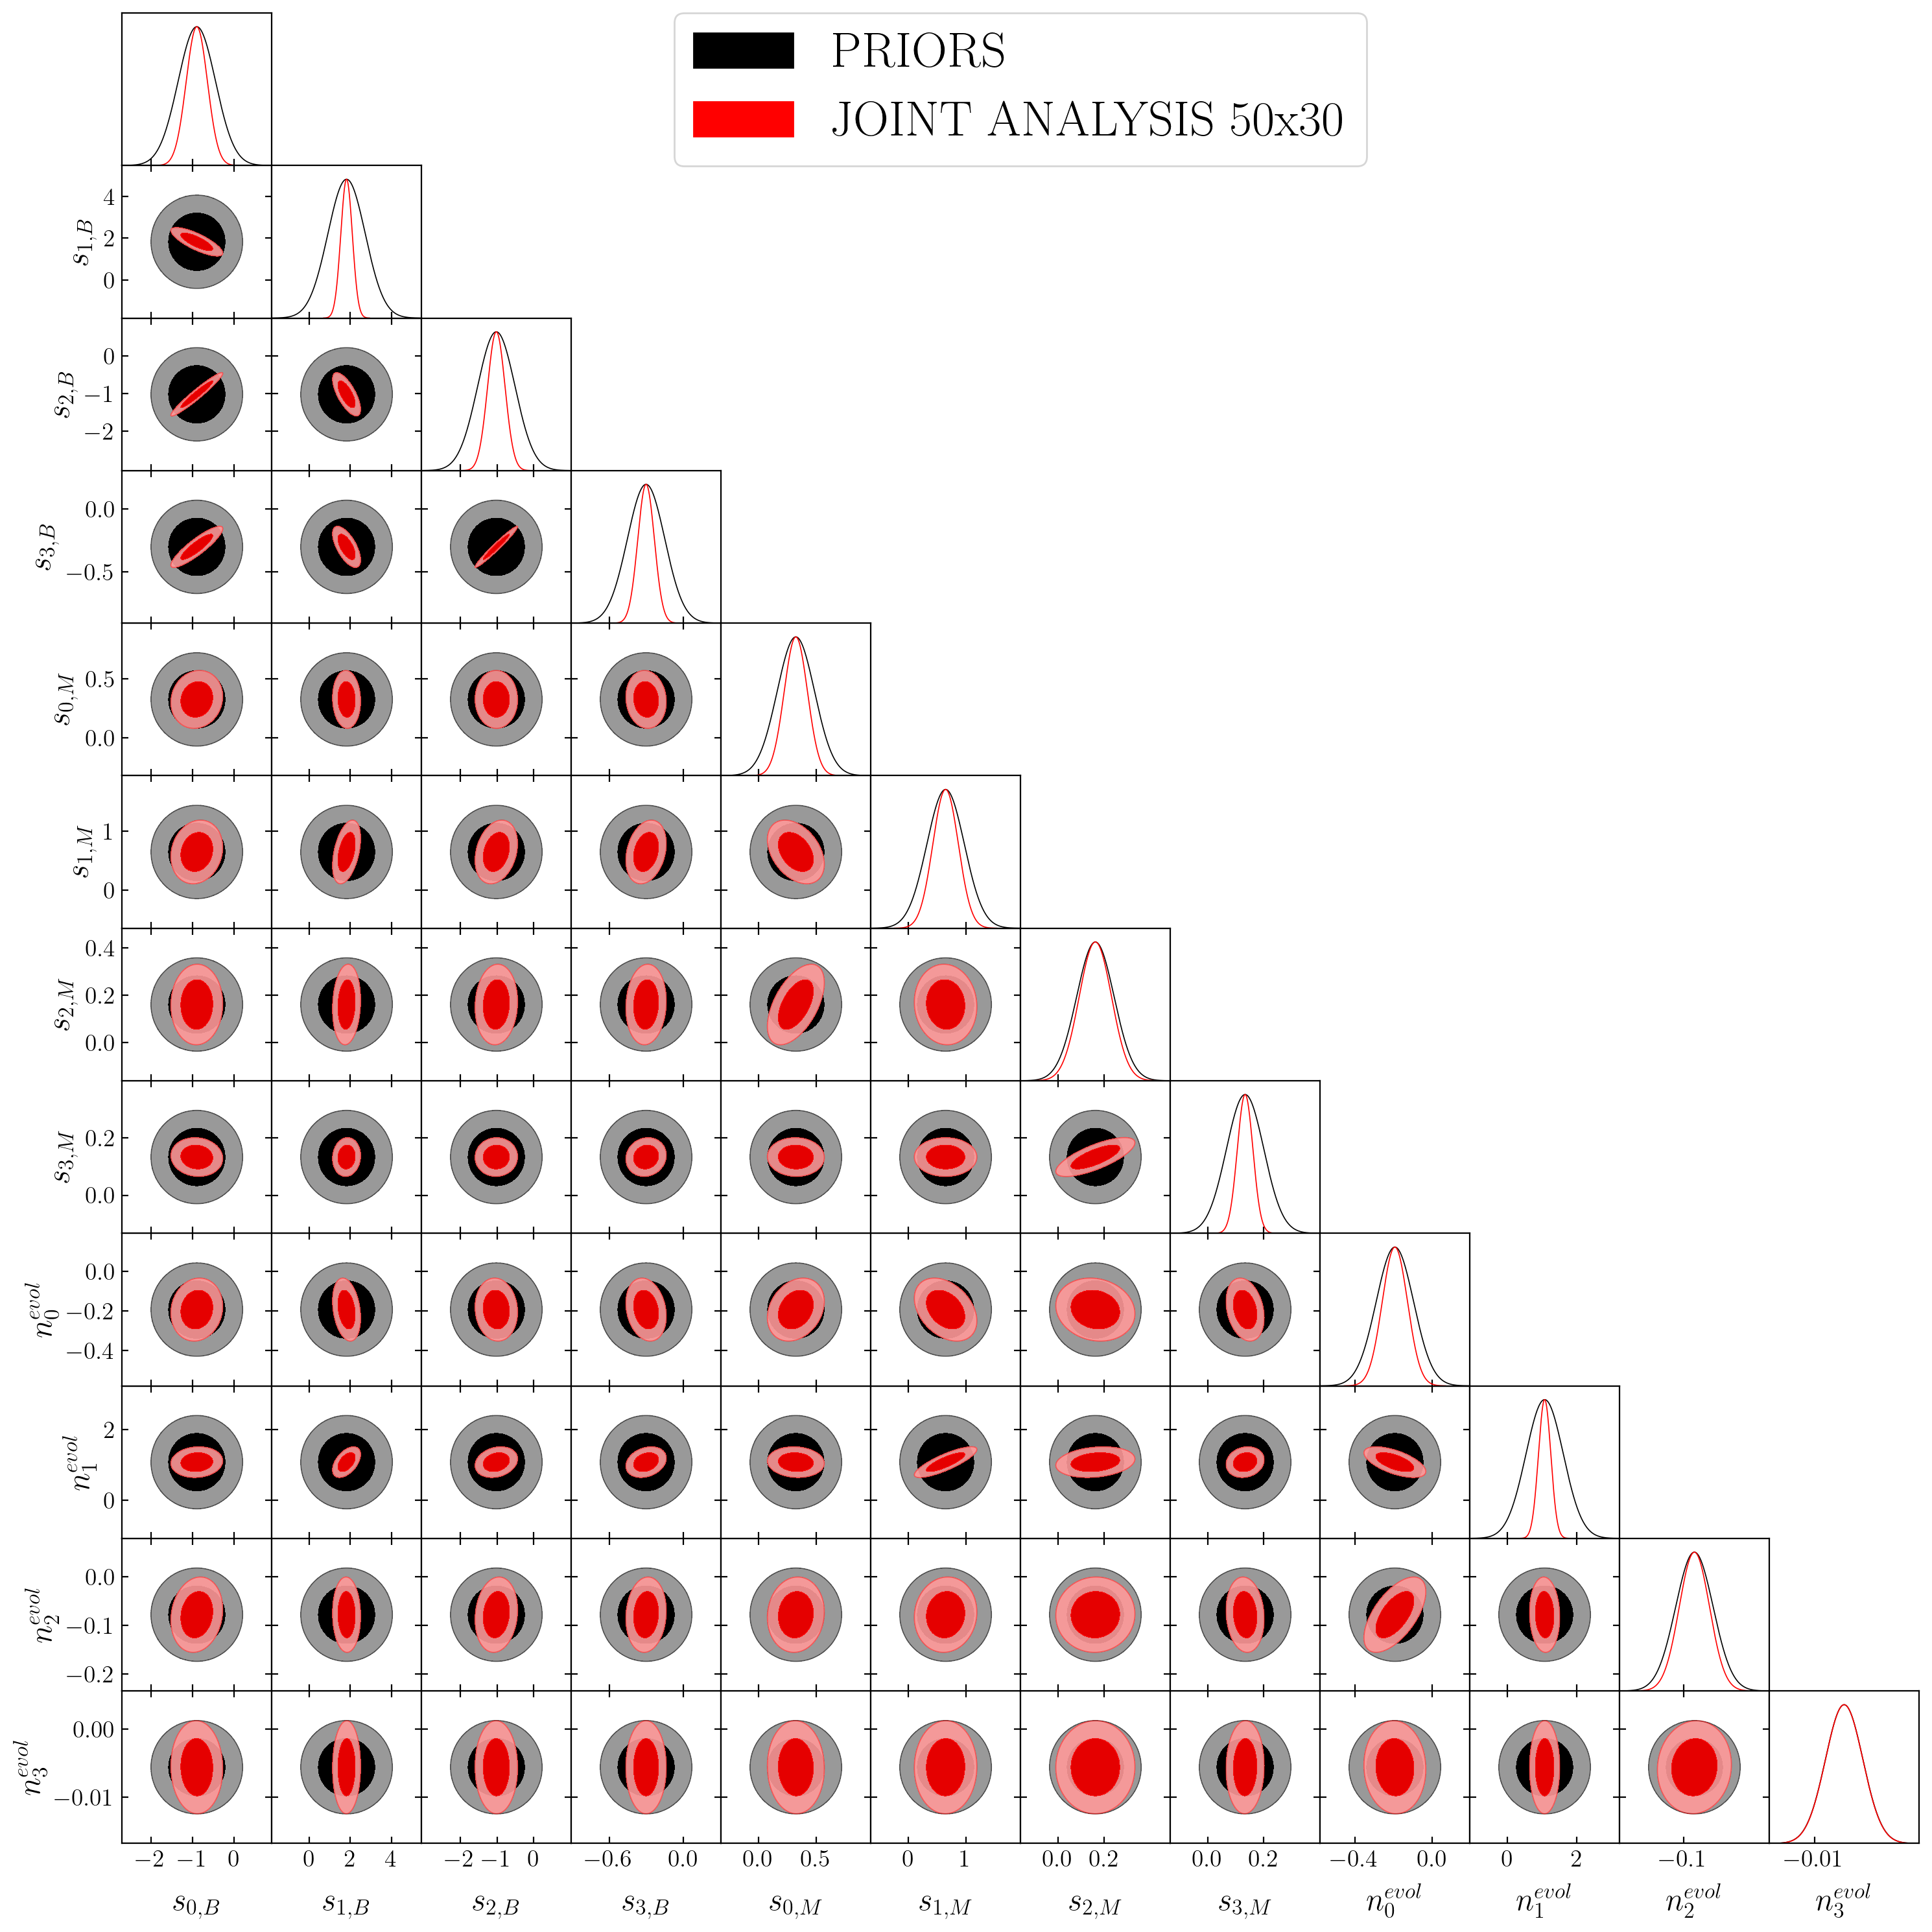

In [41]:
# Triangle plot

mean = params_fid[:-13]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit30))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_sbias_nevol_fit = GaussianND(mean, Sigma_Matrix_Joint50x30[:-13,:-13], labels = labels, names = param_names)
GaussDist_priors_sbias_nevol_fit = GaussianND(mean, Cov_prior_all, labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_priors_sbias_nevol_fit, GaussDist_sbias_nevol_fit], param_names, 
                filled=True, 
                legend_labels=['PRIORS', 'JOINT ANALYSIS 50x30'],
                contour_colors=['black', 'red'])

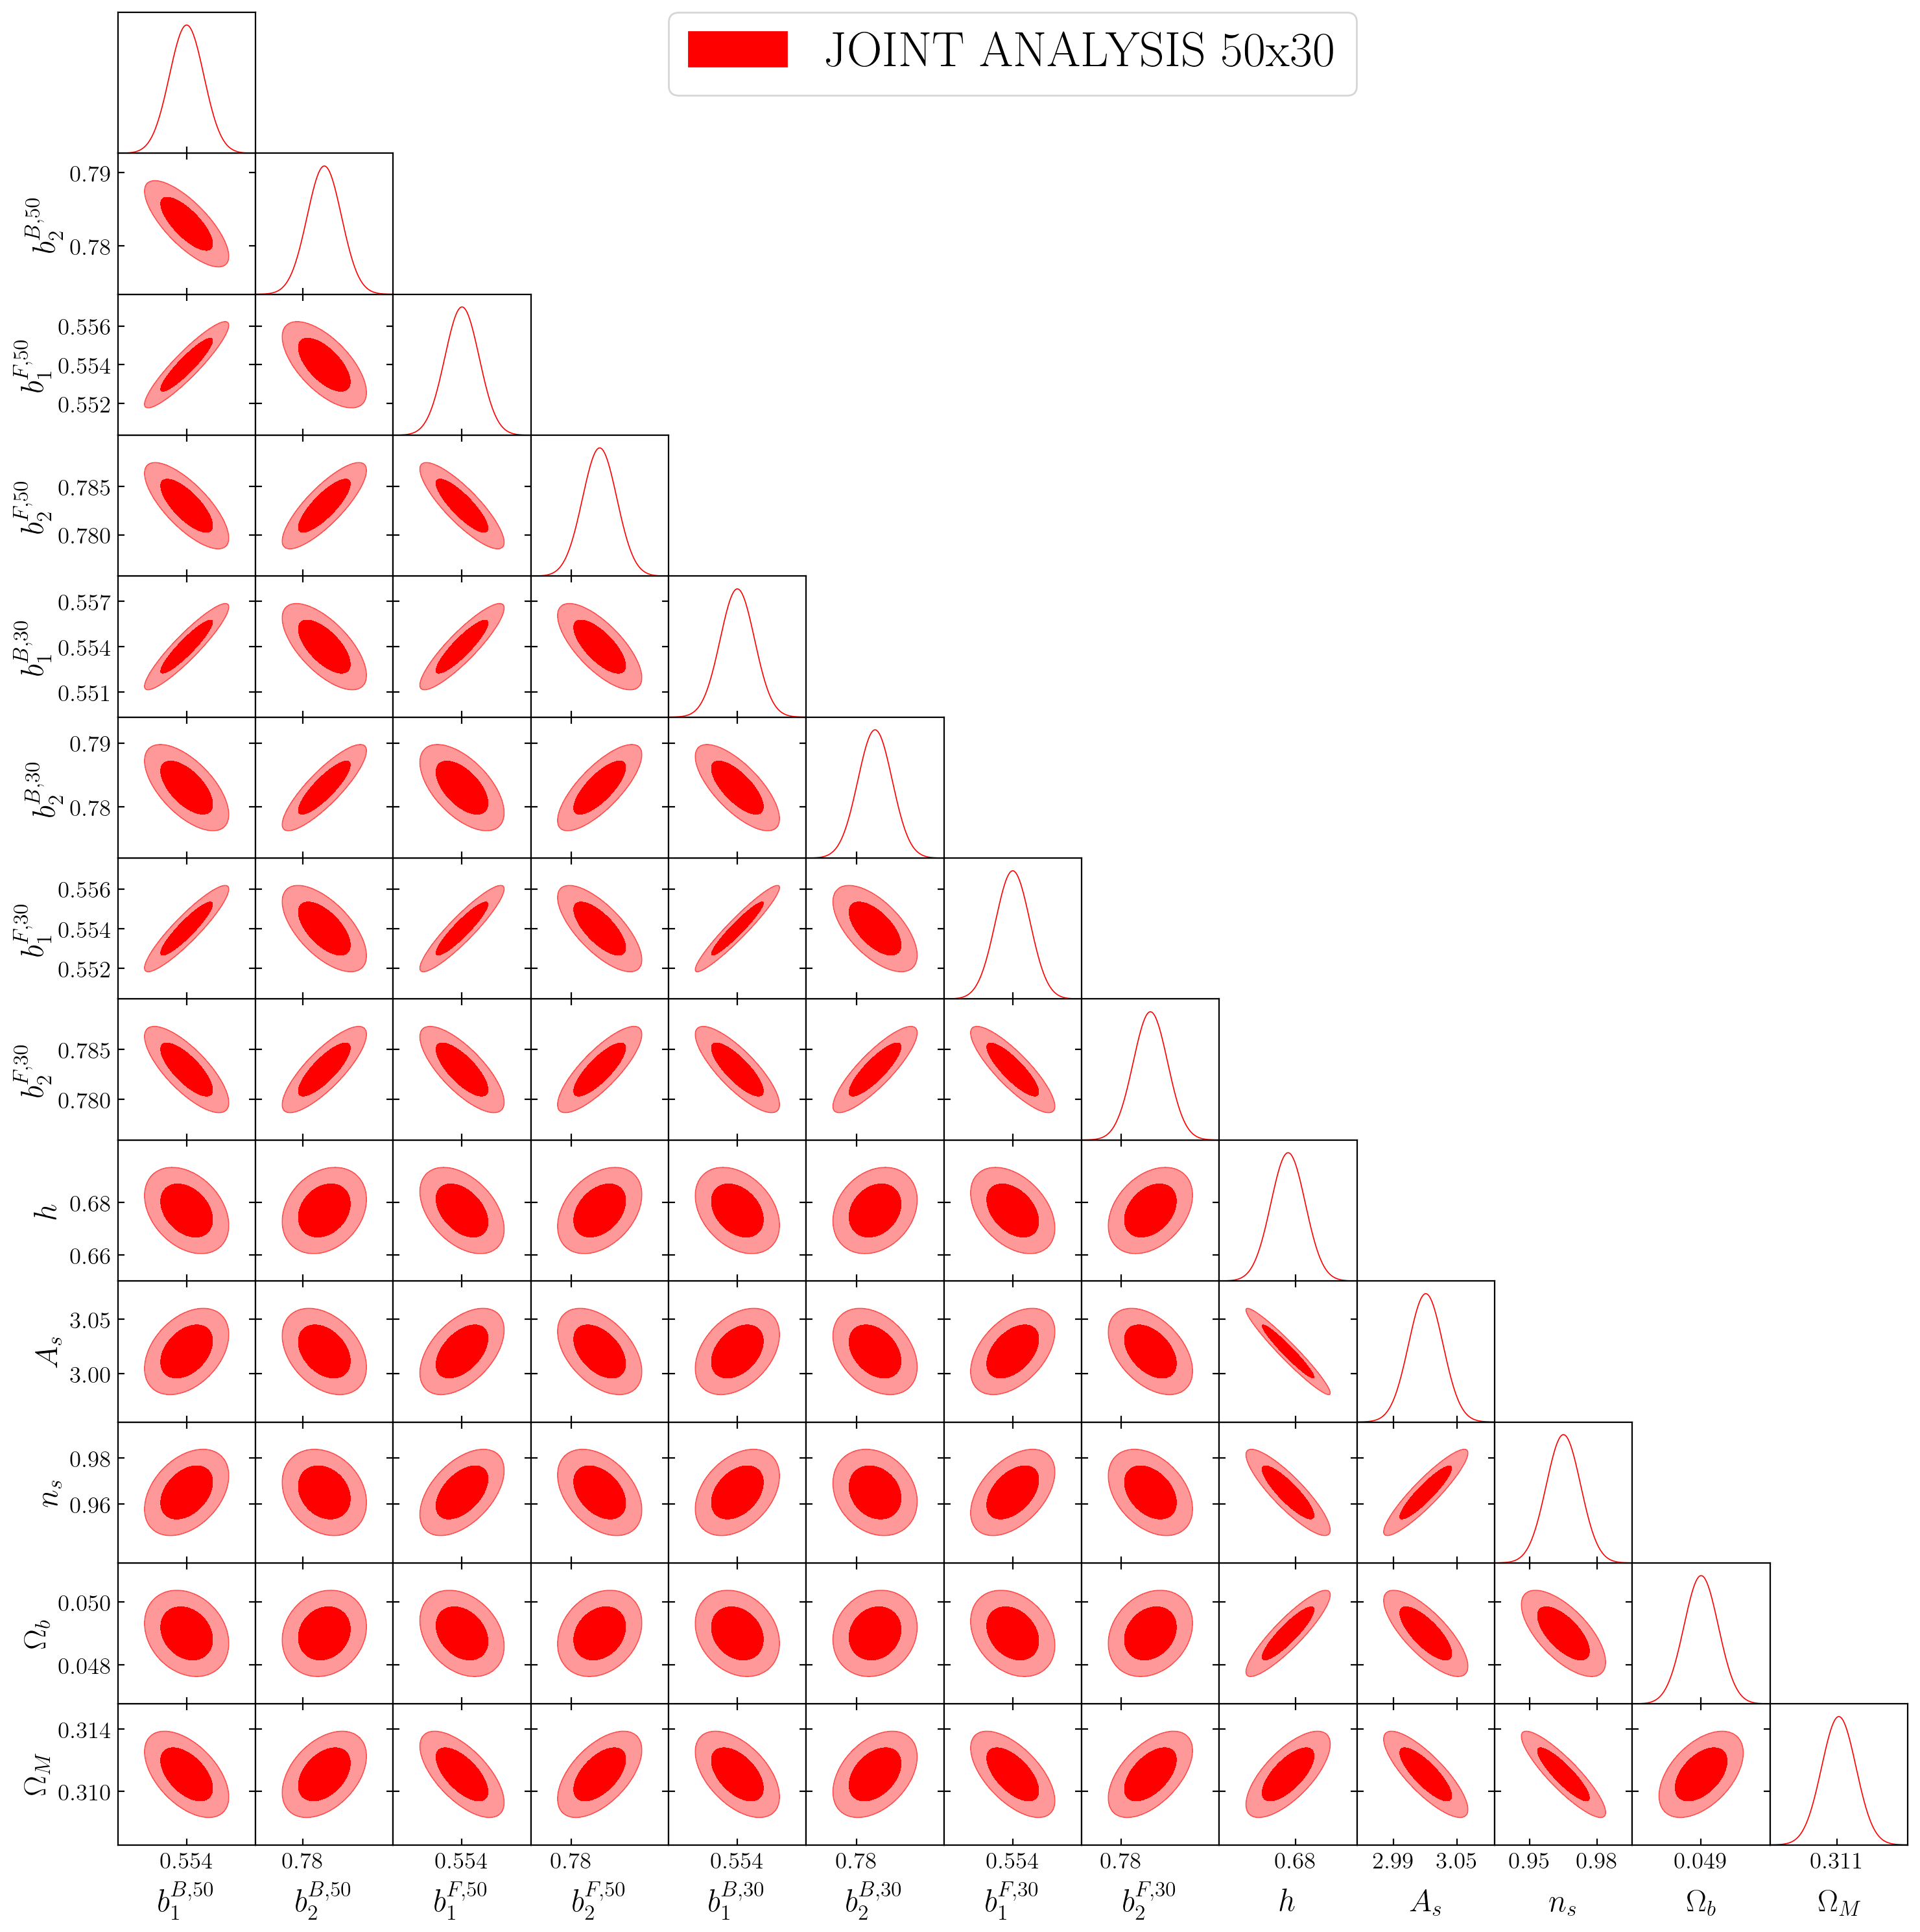

In [42]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean = params_fid[16:]

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1'] + ['b1B_m2', 'b2B_m2', 'b1F_m2', 'b2F_m2']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B,50}', r'b_2^{B,50}', r'b_1^{F,50}', r'b_2^{F,50}'] + [r'b_1^{B,30}', r'b_2^{B,30}', r'b_1^{F,30}', r'b_2^{F,30}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean, Sigma_Matrix_Joint50x30[16:,16:], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot(GaussDist_gbias_cosmic_fit, param_names, 
                filled=True, 
                legend_labels=['JOINT ANALYSIS 50x30'],
                contour_colors=['red'])

In [43]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[24:,24:]]))

7591793.934783231	2450900.20826025	872318.806291382	-28521967.28597999	10071012.189185843
2450900.2082601637	842136.935064101	191703.6721427996	-8836481.932574857	3130175.916211224
872318.8062913612	191703.672142766	405176.6735838873	-3371337.280572514	2247736.7793574613
-28521967.28597992	-8836481.932575062	-3371337.280572675	116314015.84008162	-36528391.58798761
10071012.189185796	3130175.916211284	2247736.7793575376	-36528391.5879874	21089773.850896377


In [44]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Joint50x30[24:,24:]]))

4.556395786916091e-05	-0.00010563946457333469	-4.4797797636875926e-05	3.3640113607700347e-06	5.326715241983013e-06
-0.00010563946457330995	0.00026489765477769923	0.00011312255077092314	-6.943027457296315e-06	-1.4994005547223814e-05
-4.479779763690607e-05	0.00011312255077102437	5.80986223408144e-05	-2.835048998171427e-06	-7.602358928445288e-06
3.364011360770315e-06	-6.943027457298622e-06	-2.835048998169698e-06	3.122829375101945e-07	3.137261479533077e-07
5.326715241983187e-06	-1.49940055472276e-05	-7.60235892844111e-06	3.137261479532892e-07	1.2794818936273302e-06


In [45]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Joint50x30[16:24,16:24]]))

1.0904193335797884e-06	-1.8965804433401715e-06	8.680385543184028e-07	-1.4208635231085021e-06	1.1224204710983667e-06	-1.7997418528772118e-06	8.46585534493191e-07	-1.4182438626212812e-06
-1.8965804433389854e-06	5.791526051166352e-06	-1.4103336451471983e-06	3.577042389337866e-06	-1.8665709441885636e-06	5.680203837629758e-06	-1.334727573455552e-06	3.473671226903501e-06
8.680385543190276e-07	-1.4103336451494046e-06	8.25047062765952e-07	-1.3964748670454665e-06	9.460379327779316e-07	-1.4678568802793905e-06	7.398953198875252e-07	-1.2186733786762182e-06
-1.4208635231092121e-06	3.5770423893410317e-06	-1.3964748670451273e-06	3.298712835089004e-06	-1.5318759769296108e-06	3.827565071603441e-06	-1.164687263225204e-06	2.6206078845691894e-06
1.1224204710990172e-06	-1.8665709441914325e-06	9.460379327773831e-07	-1.5318759769290867e-06	1.3685237078449417e-06	-2.32980006368686e-06	9.871906939988389e-07	-1.6804640820450956e-06
-1.7997418528773973e-06	5.68020383763342e-06	-1.4678568802771585e-06	3.827565071

In [46]:
np.allclose(Sigma_Matrix_Joint50x30[16:24,16:24], Sigma_Matrix_Joint50x30[16:24,16:24].T, rtol=1e-2)

True

# SINGLE SPLIT 

### $m = 2 \,\rightarrow\,$ $50\%$ Brigth - $50\%$ Faint

In [47]:
len(dsignal_dgbias50[1,1])/2

324.0

In [48]:
dsignal_dtheta_fit_all50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50[:,:,:324], dsignal_dcosmic50])

np.shape(dsignal_dtheta_fit_all50)

(21, 19, 324)

In [49]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_50 = np.diag(np.concatenate([dsB_50**2, dsM**2, dnum**2]))

Inv_Cov_prior_50_ = np.linalg.inv(Cov_priors_50)

Inv_Cov_prior_50 = np.zeros([len(dsignal_dtheta_fit_all50), len(dsignal_dtheta_fit_all50)])
Inv_Cov_prior_50[:len(Inv_Cov_prior_50_), :len(Inv_Cov_prior_50_)] = Inv_Cov_prior_50_

np.shape(Cov_priors_50)

(12, 12)

In [50]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_50 = fm.inverse_cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50, 50], small_off_diagonal = True, rtol=1e-10)

Fisher_Matrix_50_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all50, inv_cov = Inv_Cov_Multipoles_50, z_bins = z_bins)

Fisher_Matrix_50 = Fisher_Matrix_50_ + Inv_Cov_prior_50

np.shape(Fisher_Matrix_50)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [51]:
print(np.allclose(Fisher_Matrix_50, Fisher_Matrix_50.T, rtol=1e-11))

True


In [52]:
np.linalg.det(Fisher_Matrix_50)

1.895167651343227e+78

In [53]:
Sigma_Matrix_50 = np.linalg.inv(Fisher_Matrix_50)

#Absolute Errors

Abs_Errors_all_50 = np.sqrt(np.diag(Sigma_Matrix_50))

# Fiducial values

sbias_fit_50 = np.concatenate([sB_4fit50, sM_4fit])
gbias_fit_50 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_50 = np.concatenate([sbias_fit_50, num_fit, gbias_fit_50, cosmic_fid])

# Relative errors

Rel_Errors_all_50 = np.abs(Abs_Errors_all_50/params_fid_50)

par_errors_all_50 = Rel_Errors_all_50 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_50[0:int(len(sbias_fit_50)/2)])
print()
print('smodel = ', par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)])
print()
print('number = ', par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))])
print()
print('gbias = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))])
print()
print('cosmic = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):])


------------ Relative errors * 100 ------------

sB =  [29.96562105 19.65421466 25.09354168 24.1440115 ]

smodel =  [39.32415803 28.18124742 45.13538145 49.94441659]

number =  [41.26958199 30.59051957 25.60699765 30.6620992 ]

gbias =  [0.25908924 0.38871751 0.237073   0.30779066]

cosmic =  [1.32237596 0.74757498 1.11488564 1.39619211 0.55642466]


In [54]:
print(np.allclose(Sigma_Matrix_50, Sigma_Matrix_50.T, rtol=1e-20))

True


In [55]:
np.linalg.det(Sigma_Matrix_50)

5.276578034091118e-79

In [56]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_50)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [9.81374355e+07 7.54170157e+07 5.29395903e+06 1.89782931e+06
 1.15098256e+06 3.37941194e+05 3.01888063e+05 1.35390102e+05
 9.04898413e+04 8.10574855e+04 6.83924847e+04 1.79116316e+04
 1.43067549e+03 7.49909971e+02 1.82874304e+02 1.72920376e+01
 1.01668865e+01 5.70070015e+00 4.27497198e-01 6.46945439e-02
 3.28065395e-02]
Condition number of A: 2991398578.5650406


In [57]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_50.shape[0], Fisher_Matrix_50.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_50 @ A_plus

In [58]:
np.allclose(A_plus, Sigma_Matrix_50, rtol=1e-20)

True

# SINGLE SPLIT 

### $m = 10/3 \,\rightarrow\,$ $30\%$ Brigth - $70\%$ Faint

In [59]:
len(dsignal_dgbias30[1,1])/2

324.0

In [60]:
dsignal_dtheta_fit_all30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30[:,:,324:], dsignal_dcosmic30])

np.shape(dsignal_dtheta_fit_all30)

(21, 19, 324)

In [61]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_30 = np.diag(np.concatenate([dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_30_ = np.linalg.inv(Cov_priors_30)

Inv_Cov_prior_30 = np.zeros([len(dsignal_dtheta_fit_all30), len(dsignal_dtheta_fit_all30)])
Inv_Cov_prior_30[:len(Inv_Cov_prior_30_), :len(Inv_Cov_prior_30_)] = Inv_Cov_prior_30_

np.shape(Cov_priors_30)

(12, 12)

In [62]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_30 = fm.inverse_cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[30, 70], small_off_diagonal = True, rtol=1e-10)

Fisher_Matrix_30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all30, inv_cov = Inv_Cov_Multipoles_30, z_bins = z_bins)

Fisher_Matrix_30 = Fisher_Matrix_30_ + Inv_Cov_prior_30

np.shape(Fisher_Matrix_30)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [63]:
np.allclose(Fisher_Matrix_30, Fisher_Matrix_30.T, rtol=1e-9)

True

In [64]:
np.linalg.det(Fisher_Matrix_30)

8.533248359712198e+78

In [65]:
Sigma_Matrix_30 = np.linalg.inv(Fisher_Matrix_30)

#Absolute Errors

Abs_Errors_all_30 = np.sqrt(np.diag(Sigma_Matrix_30))

# Fiducial values

sbias_fit_30 = np.concatenate([sB_4fit30, sM_4fit])
gbias_fit_30 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_30 = np.concatenate([sbias_fit_30, num_fit, gbias_fit_30, cosmic_fid])

# Relative errors

Rel_Errors_all_30 = np.abs(Abs_Errors_all_30/params_fid_30)

par_errors_all_30 = Rel_Errors_all_30 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_30[0:int(len(sbias_fit_30)/2)])
print()
print('smodel = ', par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)])
print()
print('number = ', par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))])
print()
print('gbias = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))])
print()
print('cosmic = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)+len(gbias_fit_30)):])


------------ Relative errors * 100 ------------

sB =  [32.91545734 37.55909747 43.61157626 21.46062873]

smodel =  [37.87849226 18.60522994 46.48970423 49.95712123]

number =  [40.22811877 27.81768051 23.87182321 29.72725482]

gbias =  [0.28551142 0.40989638 0.21292049 0.26888336]

cosmic =  [1.1320548  0.61848122 0.9196463  1.27750669 0.42123413]


In [66]:
np.allclose(Sigma_Matrix_30, Sigma_Matrix_30.T, rtol=1e-20)

True

In [67]:
np.linalg.det(Sigma_Matrix_30)

1.1718866694671498e-79

In [68]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Sigma_Matrix_30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("(Log)-Condition number of A:", np.log10(condition_number))

Singular values of A: [2.97699979e+01 1.23952118e+01 1.70435374e+00 7.58016153e-02
 5.82896451e-02 1.33002998e-02 4.72599277e-03 2.14006875e-03
 4.76093173e-04 1.12279776e-04 2.20221225e-05 1.87169848e-05
 1.47711446e-05 1.06596176e-05 4.68392965e-06 3.80999489e-06
 9.89698896e-07 3.87169765e-07 1.78400739e-07 9.56295462e-09
 7.74584298e-09]
(Log)-Condition number of A: 9.584710115782977


In [69]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Sigma_Matrix_30.shape[0], Sigma_Matrix_30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Sigma_Matrix_30 @ A_plus

In [70]:
determinant = np.prod(s)

print(f'The determinant of the Sigma Matrix is: {determinant}')

The determinant of the Sigma Matrix is: 1.1718866694624888e-79


In [71]:
np.allclose(A_plus, Fisher_Matrix_30, rtol=1e-7)

True

Comparison with result of combined analysis

In [72]:
print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [28.32817994 15.37425773 23.25659381 22.12125415]

sB_30 =  [31.05091945 34.09241083 43.14192283 20.85516023]

s_model =  [33.74544355 16.52718533 40.35153799 49.81149983]

number =  [39.51213355 24.27487589 17.80737602 26.78301192]

gbias_50 =  [0.18848943 0.30735108 0.16395686 0.23195861]

gbias_30 =  [0.21116231 0.35334471 0.1603515  0.22638288]

cosmic =  [0.99706174 0.53885388 0.78986997 1.14045472 0.3635943 ]



# Numerical comparison

In [73]:
cosmic50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):]
cosmic30x70 = par_errors_all_30[(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30)):]

cosmicjoint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))]

In [74]:
sm50x50 = par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)]
sm30x70 = par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)]

sB50x50 = par_errors_all_50[0:int(len(sbias_fit_50)/2)]
sB30x70 = par_errors_all_30[0:int(len(sbias_fit_30)/2)]

sB50joint = par_errors_all_Joint[0:int(len(sB_fit)/2)]
sB30joint = par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)]

smjoint = par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)]

In [75]:
np.shape(par_errors_all_Joint)

(29,)

In [76]:
gbias50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))]
gbias30x70 = par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))]

gbias50joint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))]
gbias30joint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))]

In [77]:
num50x50 = par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))]
num30x70 = par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))]

numjoint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))]

In [78]:
print('\n Difference Joint vs 50x50 \n')
print(' DsB = ', (1-sB50joint/sB50x50) * 100, '\n')
print(' Dgbias = ',  (1-gbias50joint/gbias50x50) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm50x50) * 100, '\n')
print(' Dnum = ', (1-numjoint/num50x50) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic50x50) * 100, '\n')

print('\n Difference Joint vs 30x70 \n')
print(' DsB = ', (1-sB30joint/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias30joint/gbias30x70) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm30x70) * 100, '\n')
print(' Dnum = ', (1-numjoint/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic30x70) * 100, '\n')


 Difference Joint vs 50x50 

 DsB =  [ 5.46439904 21.77628054  7.32040094  8.37788429] 

 Dgbias =  [27.24922408 20.93202053 30.84119296 24.63754215] 

 Dsmodel =  [14.18648169 41.35396109 10.59887678  0.26612936] 

 Dnum =  [ 4.25845952 20.64575486 30.45894618 12.65108188] 

 Dcosmic =  [24.6007358  27.91975429 29.15237736 18.31677658 34.65525183] 


 Difference Joint vs 30x70 

 DsB =  [5.66462704 9.22995192 1.07690082 2.82129897] 

 Dgbias =  [26.04067821 13.79657684 24.68949493 15.80628791] 

 Dsmodel =  [10.91133373 11.16914232 13.20328092  0.29149277] 

 Dnum =  [ 1.77981285 12.73580168 25.4042062   9.90418698] 

 Dcosmic =  [11.9246043  12.87465734 14.11154813 10.72808226 13.6835615 ] 



In [79]:
print('\n Difference 50x50 vs 30x70 \n')
print(' DsB = ', (1-sB50x50/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias50x50/gbias30x70) * 100, '\n')
print(' Dsmodel = ', (1-sm50x50/sm30x70) * 100, '\n')
print(' Dnum = ', (1-num50x50/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmic50x50/cosmic30x70) * 100, '\n')


 Difference 50x50 vs 30x70 

 DsB =  [  8.96185722  47.67122753  42.46128246 -12.50374722] 

 Dgbias =  [  9.25433256   5.16688335 -11.34344291 -14.469955  ] 

 Dsmodel =  [-3.81658743e+00 -5.14694928e+01  2.91316713e+00  2.54310917e-02] 

 Dnum =  [-2.58889366 -9.96790173 -7.26871352 -3.14473833] 

 Dcosmic =  [-16.81200955 -20.87270487 -21.22982913  -9.29039526 -32.09391867] 



# Triangle Plots

In [80]:
np.shape(params_fid), np.shape(params_fid_50)

((29,), (21,))

In [81]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(4,8))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(25, 25)

In [82]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

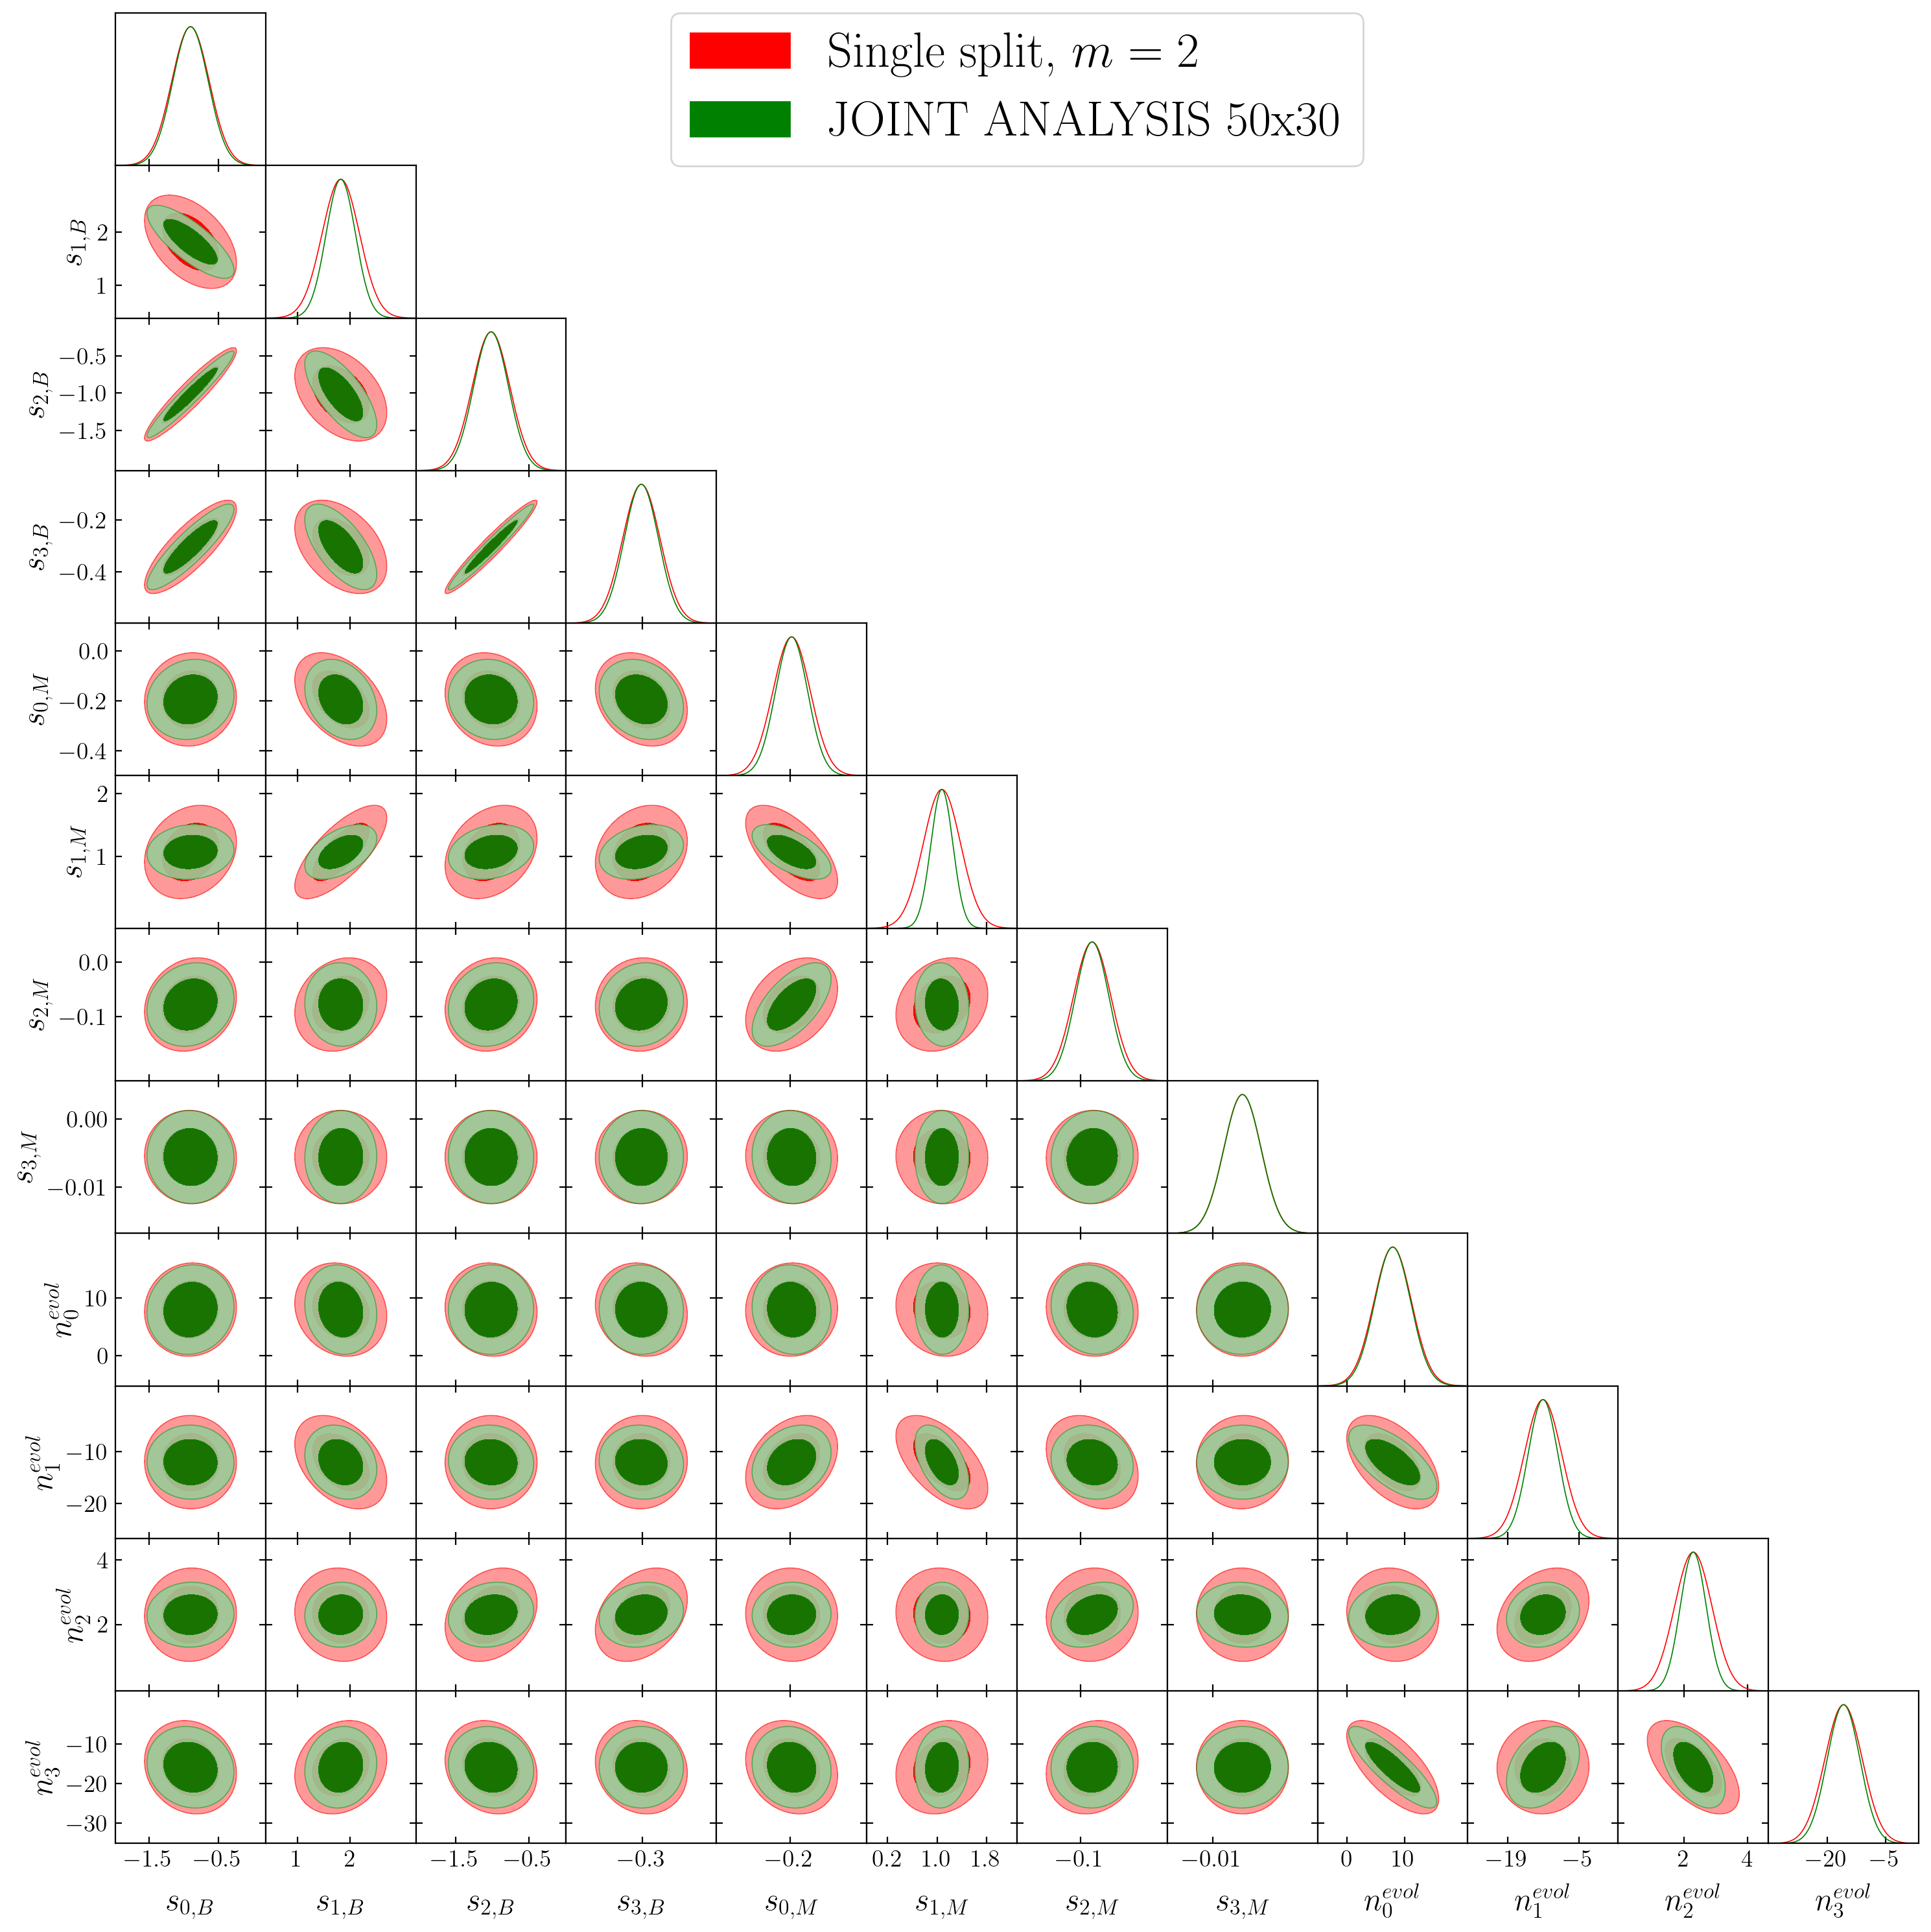

In [83]:
# Triangle plot

mean_joint = params_fid_
mean_50 = params_fid_50[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-13,:-13], labels = labels, names = param_names)
GaussDist_50_sbias_nevol_fit = GaussianND(mean_50, Sigma_Matrix_50[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_50_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=2$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [84]:
np.shape(params_fid), np.shape(params_fid_30)

((29,), (21,))

In [85]:
# Delete rows and columns alien to the 30x70 split

nind = list(range(0,4))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(25, 25)

In [86]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

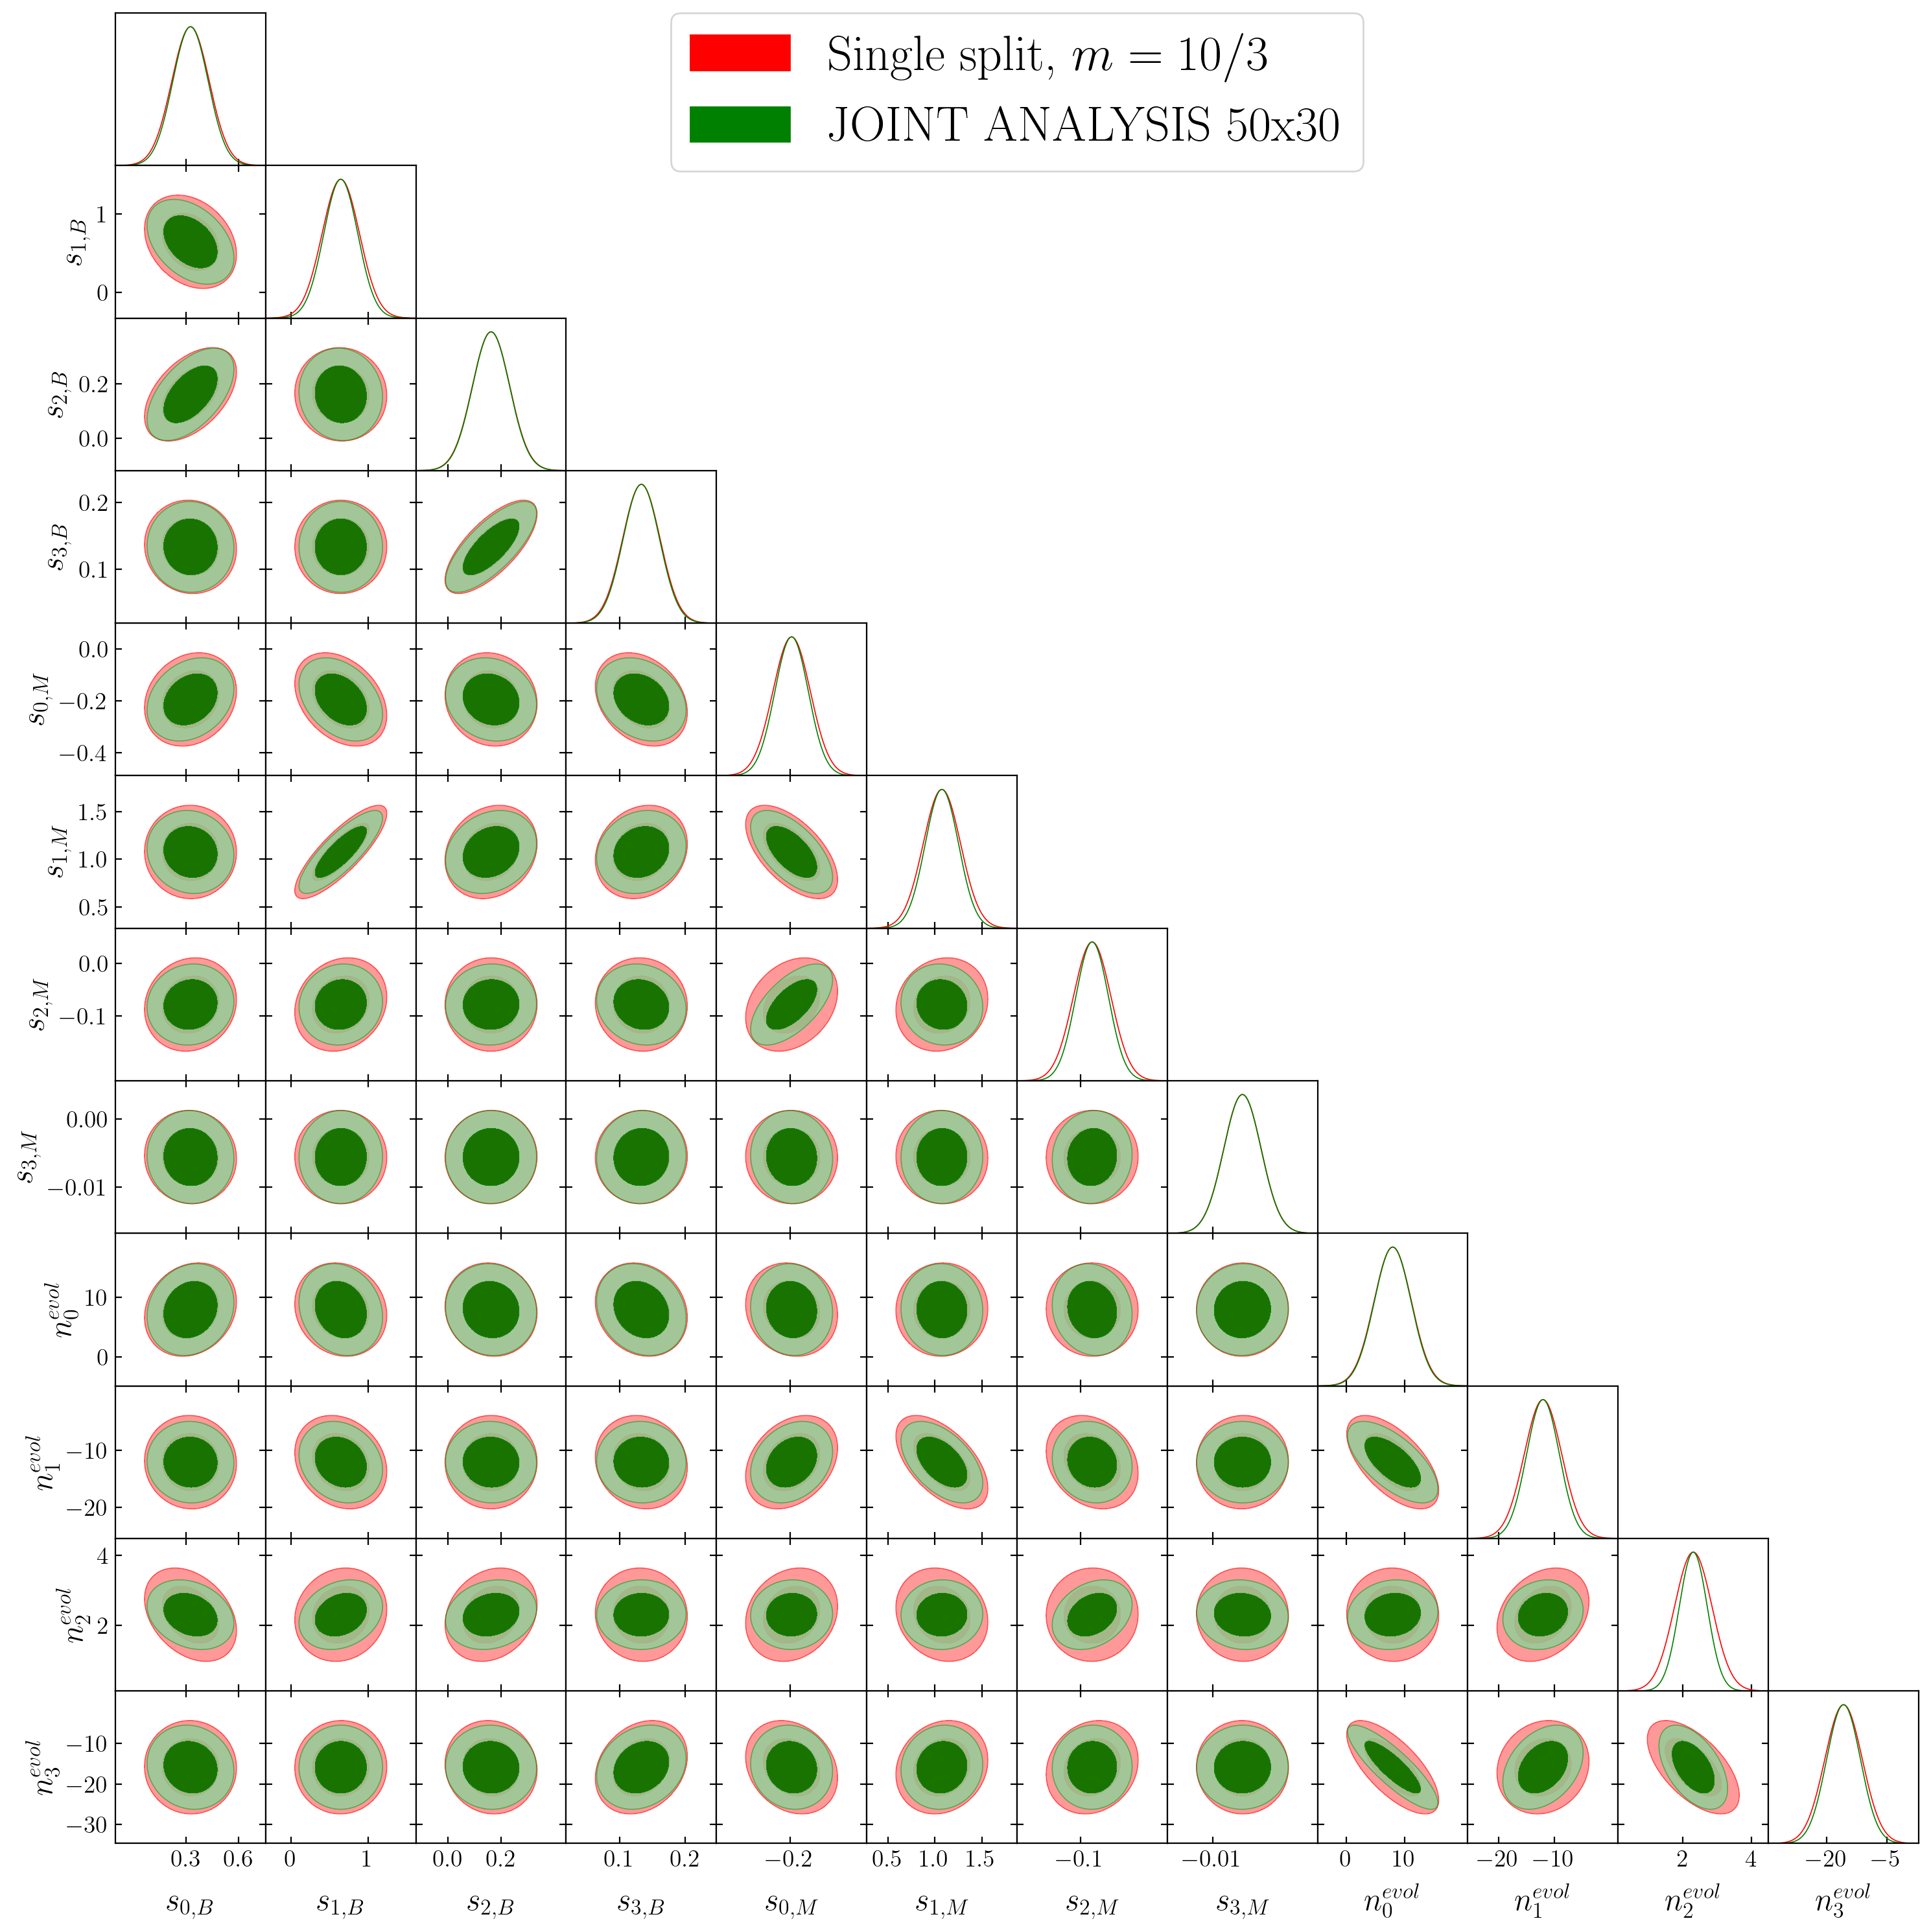

In [87]:
# Triangle plot

mean_joint = params_fid_
mean_30 = params_fid_30[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-13,:-13], labels = labels, names = param_names)
GaussDist_30_sbias_nevol_fit = GaussianND(mean_30, Sigma_Matrix_30[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_30_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=10/3$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [88]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(0,16)) + list(range(20,24))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(9, 9)

In [89]:
# Delete elements of params_fid

params_fid_ = params_fid

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(9,)

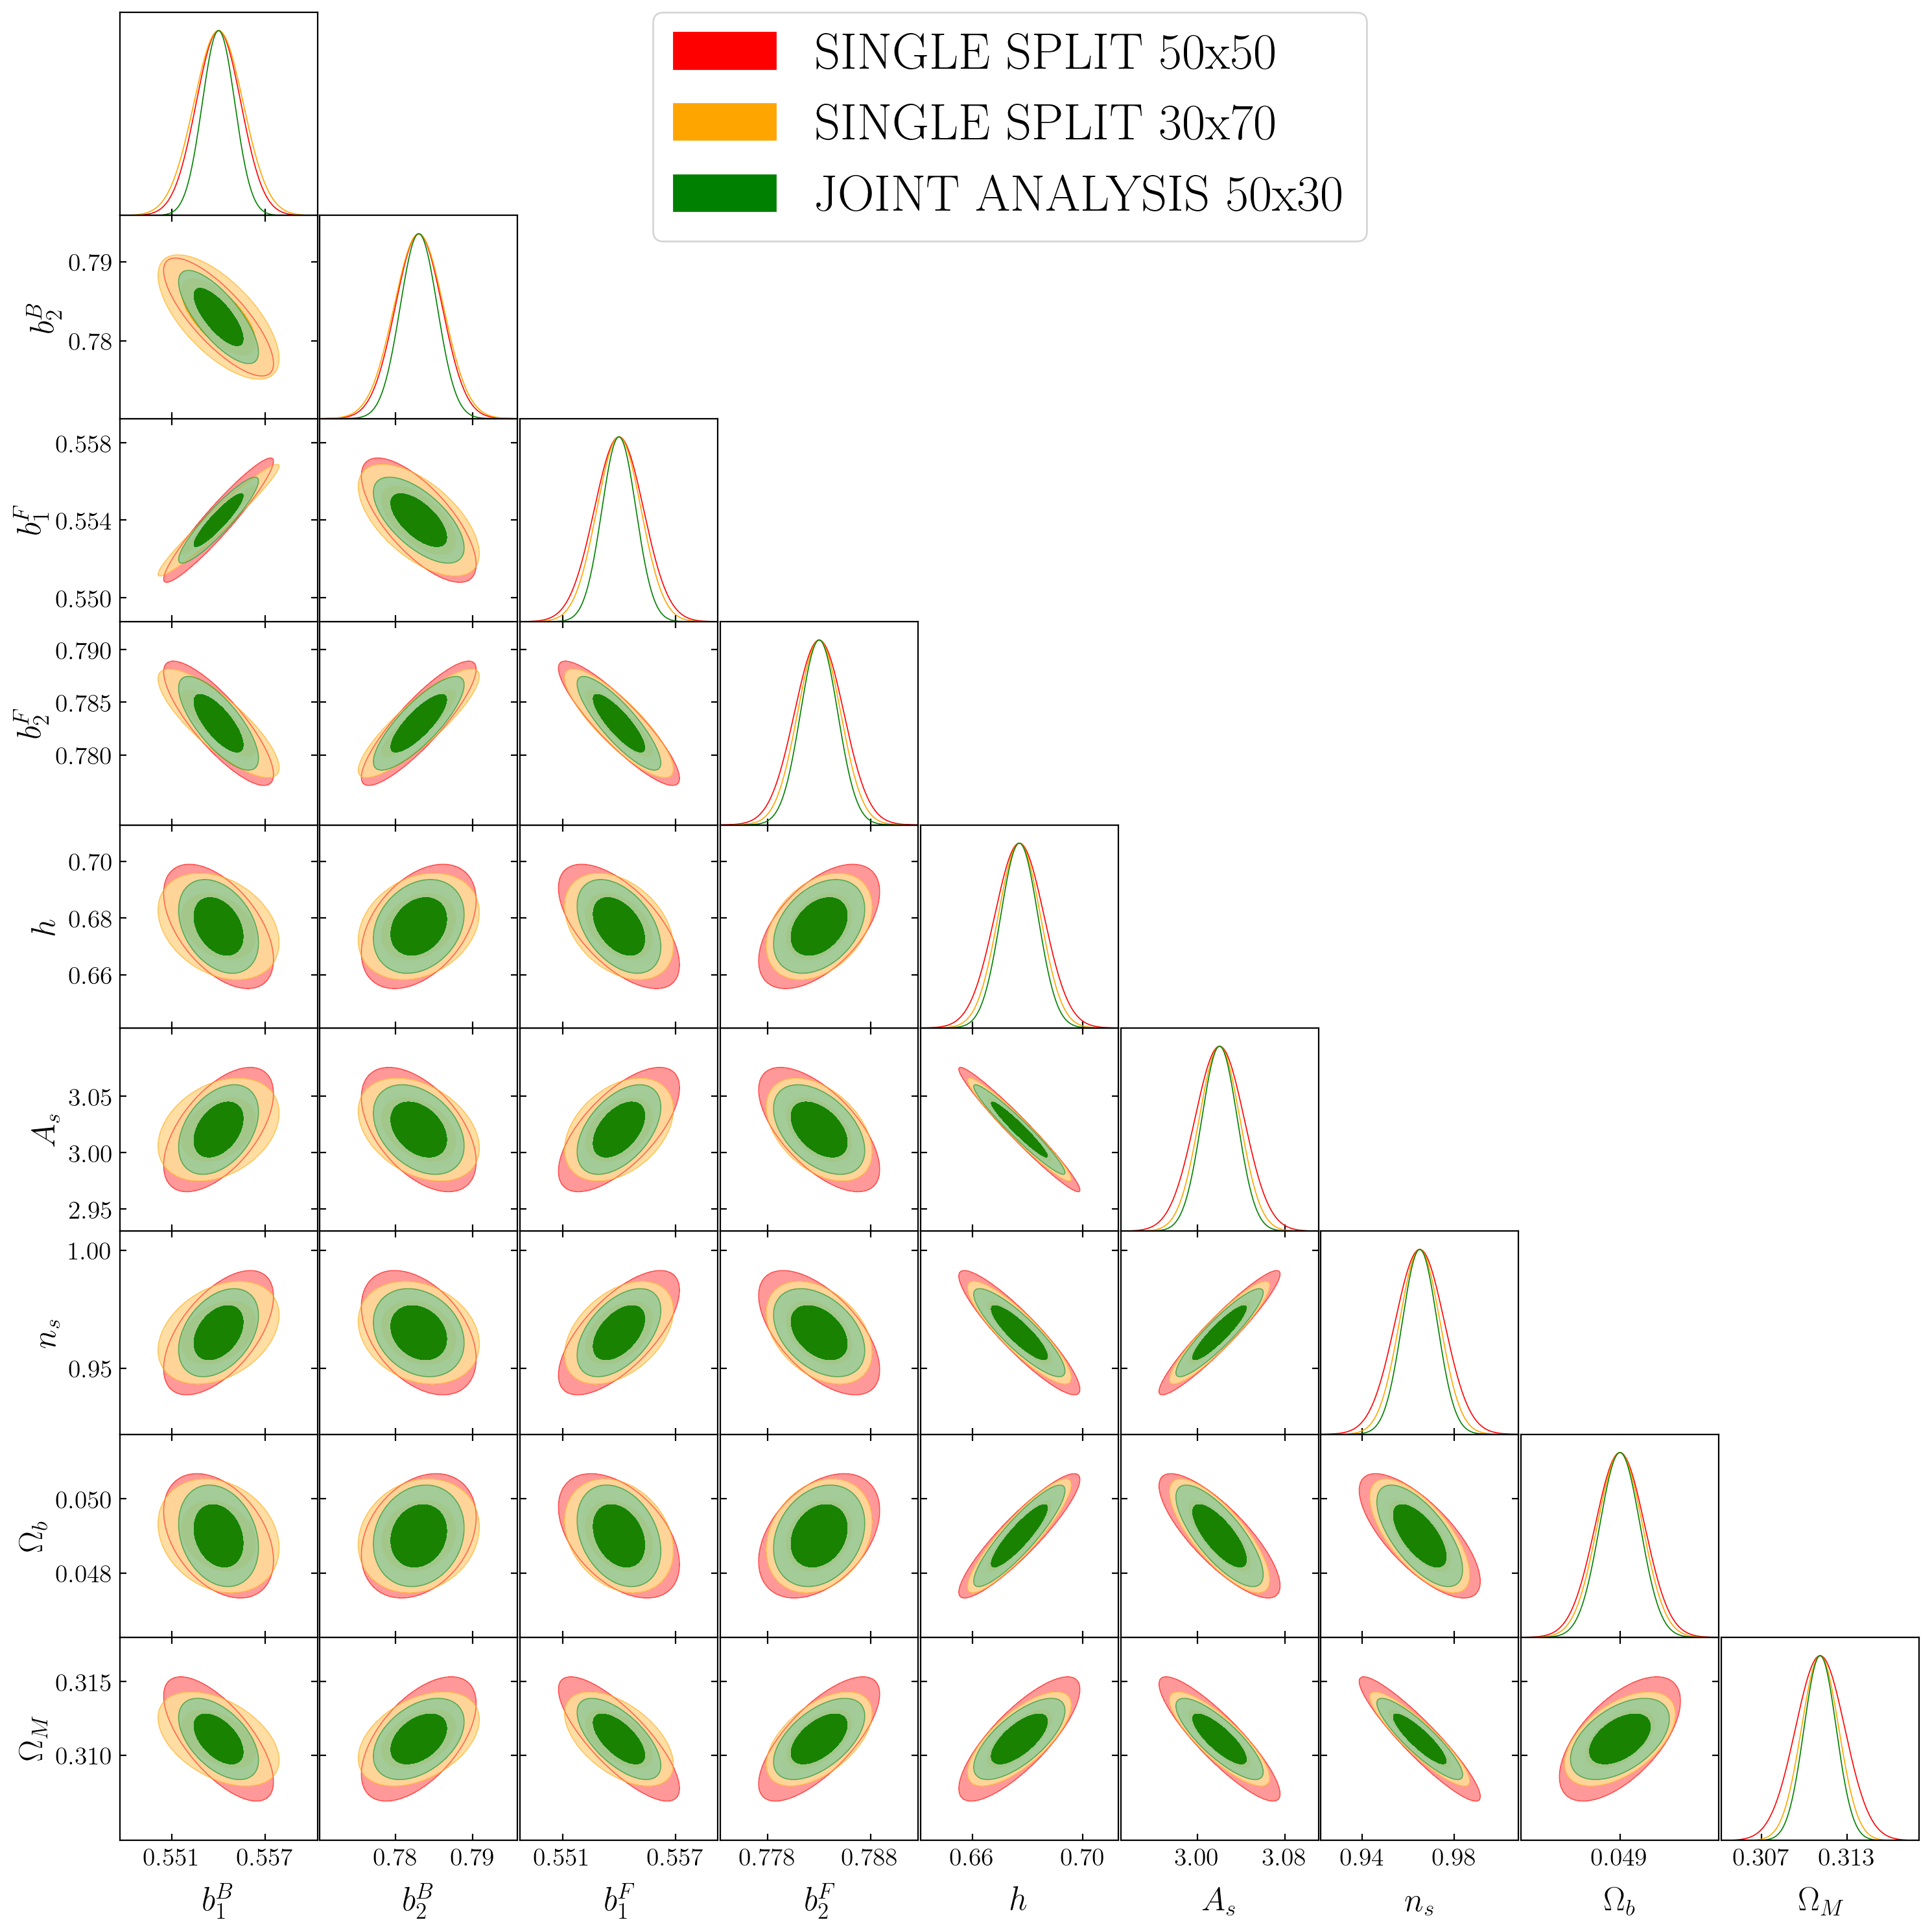

In [90]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean_50 = params_fid_

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B}', r'b_2^{B}', r'b_1^{F}', r'b_2^{F}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean_50, Sigma_Matrix_Joint50x30_, labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_50 = GaussianND(mean_50, Sigma_Matrix_50[12:, 12:], labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_30 = GaussianND(mean_50, Sigma_Matrix_30[12:, 12:], labels = labels, names = param_names)


g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_gbias_cosmic_fit_50, GaussDist_gbias_cosmic_fit_30, GaussDist_gbias_cosmic_fit], param_names, 
                filled=True, 
                legend_labels=['SINGLE SPLIT 50x50', 'SINGLE SPLIT 30x70','JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'orange', 'green'])

# Predictions from the JOINT ANALYSIS

## Magnification bias

In [91]:
# Magnification bias fit

def magbias_fit(params, x):
    a, b, c, d = params
    return  a + b * x + c * np.log(x) + d * (np.log(x))**2

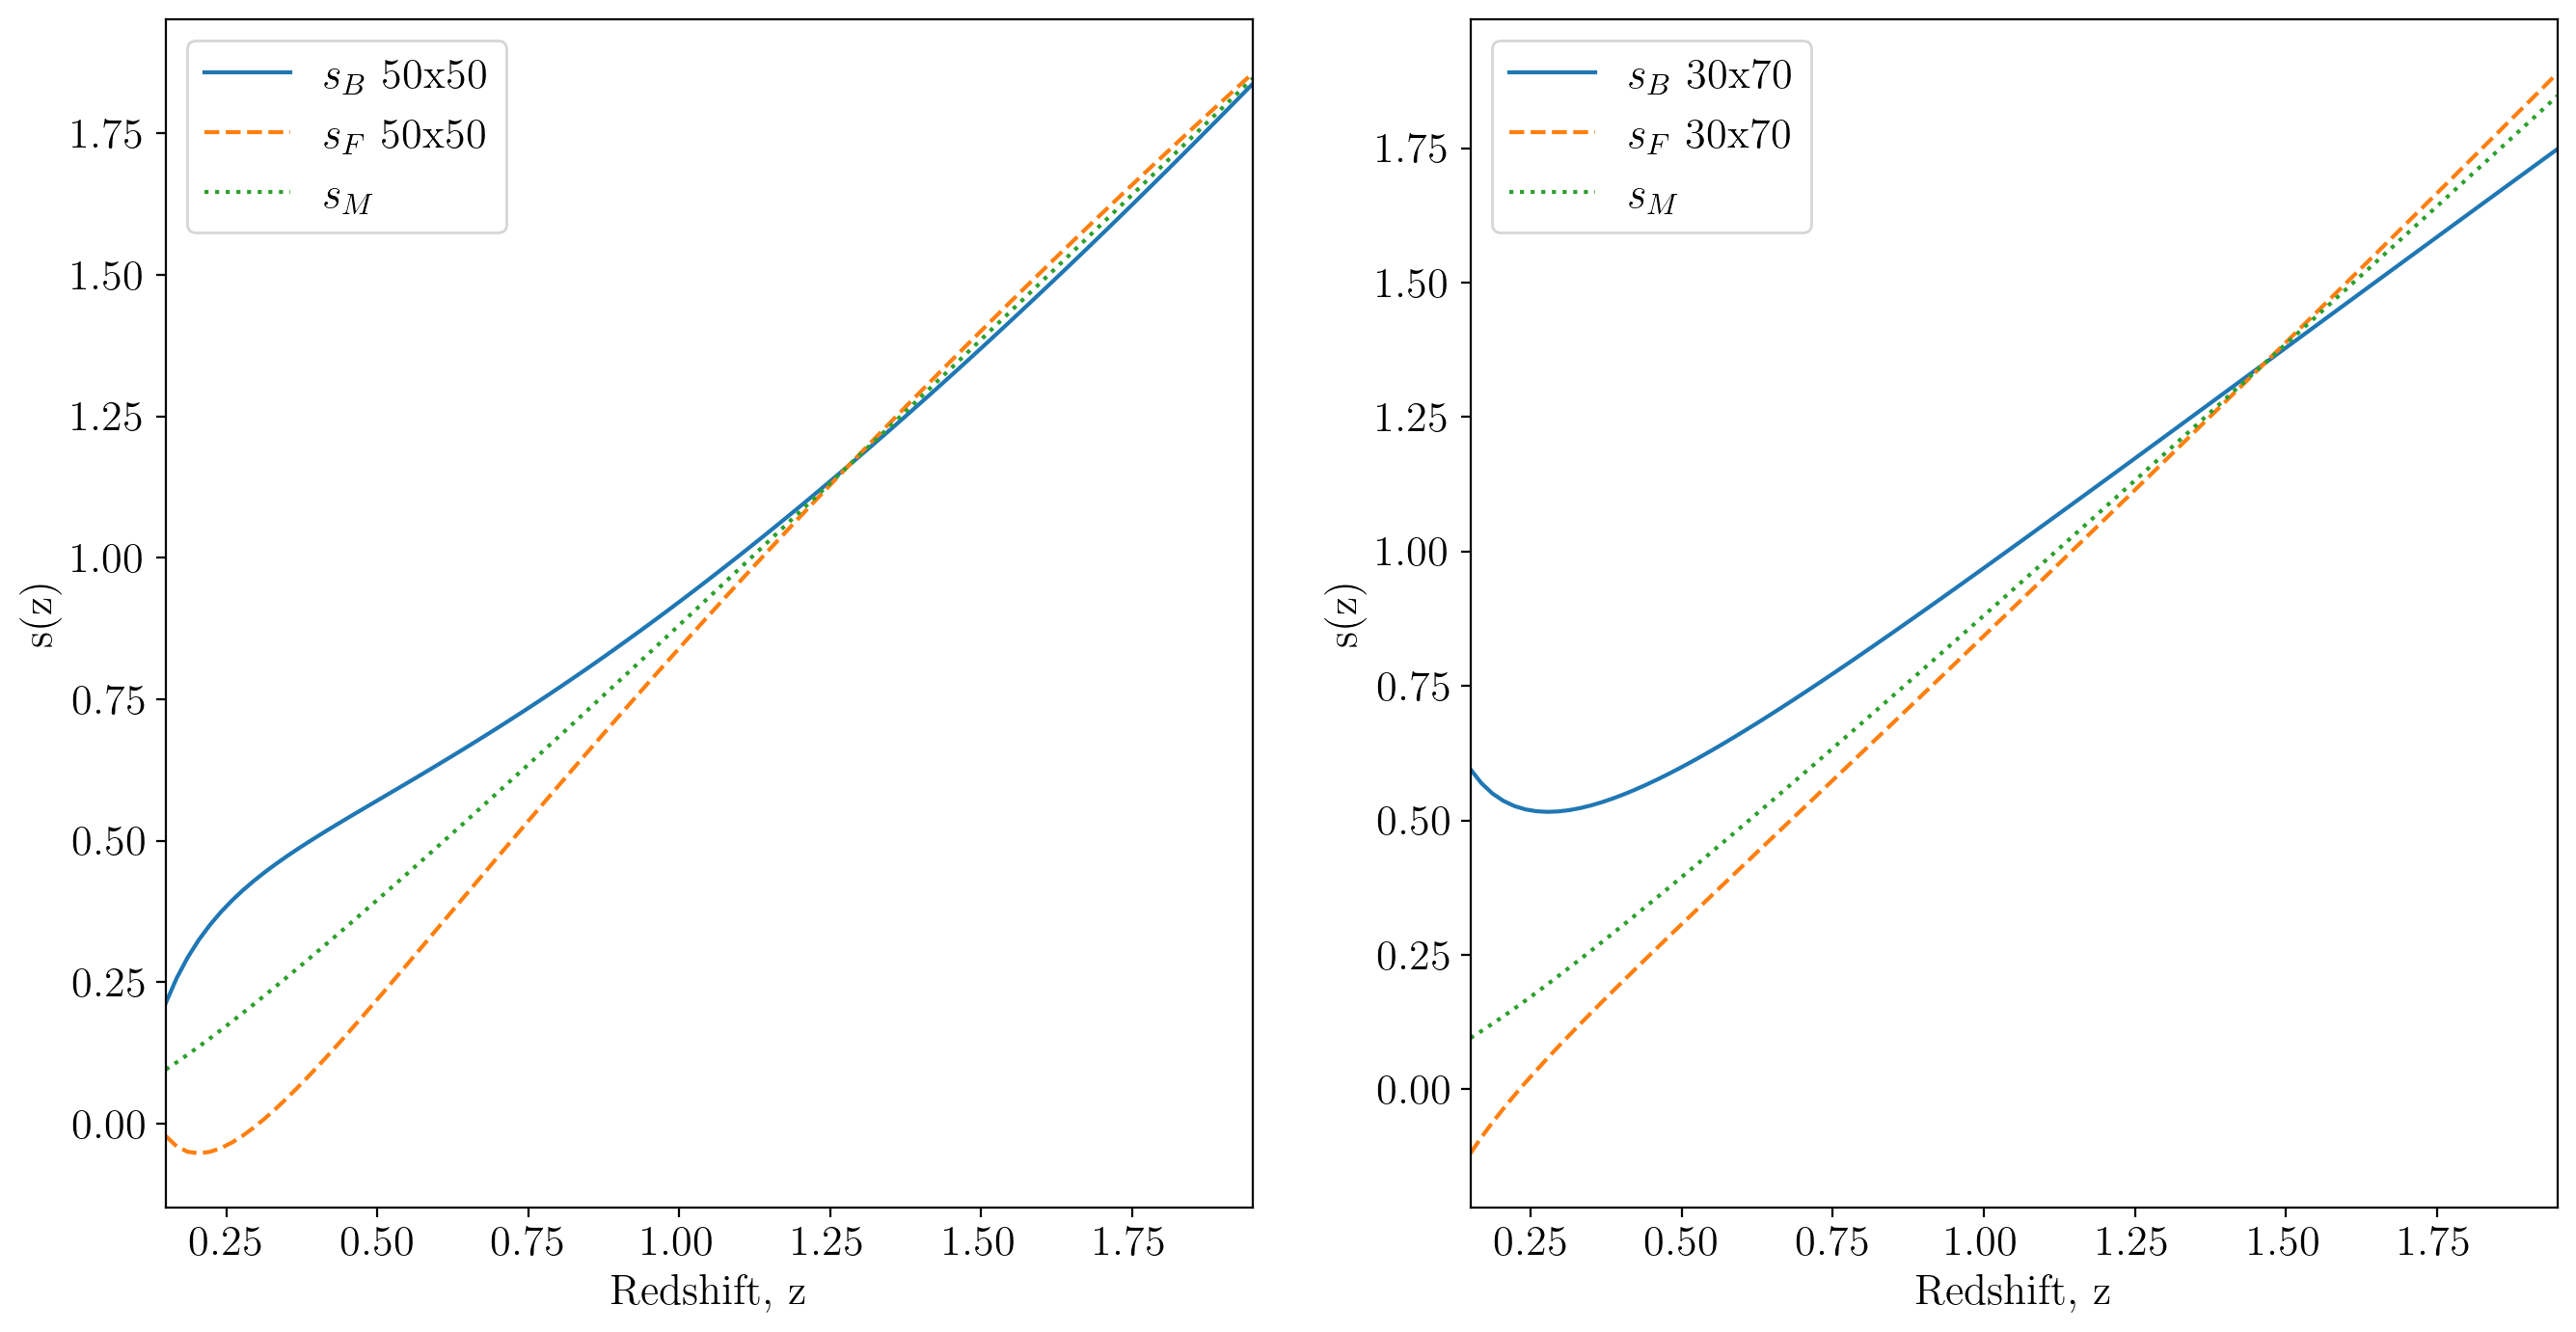

In [92]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

m_50 = 2.
m_30 = 10/3.

sB_fid_50 = magbias_fit(sB_fit[:4], z_lin)
sB_fid_30 = magbias_fit(sB_fit[4:], z_lin)
sM_fid = magbias_fit(sM_4fit, z_lin)
sF_fid_50 = sM_fid * (m_50/(m_50-1)) - sB_fid_50/(m_50-1)
sF_fid_30 = sM_fid * (m_30/(m_30-1)) - sB_fid_30/(m_30-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, '-', label=r'$s_B$ 50x50')
ax[0].plot(z_lin, sF_fid_50, '--', label=r'$s_F$ 50x50')
ax[0].plot(z_lin, sM_fid, ':', label=r'$s_M$')

ax[1].plot(z_lin, sB_fid_30, '-', label=r'$s_B$ 30x70')
ax[1].plot(z_lin, sF_fid_30, '--', label=r'$s_F$ 30x70')
ax[1].plot(z_lin, sM_fid, ':', label=r'$s_M$')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r's(z)')
    axi.legend();


### Observables: $s_B(z)$ and $s_M(z)$

In [93]:
# Compute priors 

# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_50_priors = Cov_prior_all[:4, :4]
cov_sB_30_priors = Cov_prior_all[4:8, 4:8]
cov_sM_priors = Cov_prior_all[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
sB_50_pars_samples_priors = np.random.multivariate_normal(sB_4fit50, cov_sB_50_priors, num_samples)
sB_30_pars_samples_priors = np.random.multivariate_normal(sB_4fit30, cov_sB_30_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sM_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample

sB_50_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples_priors])

sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval

sB_50_lower_bound_priors = np.percentile(sB_50_samples_priors, 16, axis=0)
sB_50_upper_bound_priors = np.percentile(sB_50_samples_priors, 84, axis=0)

sB_30_lower_bound_priors = np.percentile(sB_30_samples_priors, 16, axis=0)
sB_30_upper_bound_priors = np.percentile(sB_30_samples_priors, 84, axis=0)

sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)


###### Compare the two observables

In [94]:
Sigma_Matrix_Joint50x30[:4, :4]

array([[ 0.06516141, -0.05606657,  0.05809836,  0.01510328],
       [-0.05606657,  0.07855297, -0.04631276, -0.0120276 ],
       [ 0.05809836, -0.04631276,  0.05613798,  0.01548054],
       [ 0.01510328, -0.0120276 ,  0.01548054,  0.00450523]])

In [95]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_Joint_50 = Sigma_Matrix_Joint50x30[:4, :4]
cov_sB_Joint_30 = Sigma_Matrix_Joint50x30[4:8, 4:8]
cov_sM_Joint = Sigma_Matrix_Joint50x30[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sB_Joint_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_Joint_50, num_samples)
sB_Joint_30_pars_samples = np.random.multivariate_normal(sB_4fit30, cov_sB_Joint_30, num_samples)
sM_Joint_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_Joint, num_samples)

# Evaluate fitting function for each parameter sample
sB_Joint_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_Joint_50_pars_samples])
sB_Joint_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_Joint_30_pars_samples])
sM_Joint_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_Joint_pars_samples])

# Calculate the 68% confidence interval
sB_Joint_50_lower_bound = np.percentile(sB_Joint_50_samples, 16, axis=0)
sB_Joint_50_upper_bound = np.percentile(sB_Joint_50_samples, 84, axis=0)

sB_Joint_30_lower_bound = np.percentile(sB_Joint_30_samples, 16, axis=0)
sB_Joint_30_upper_bound = np.percentile(sB_Joint_30_samples, 84, axis=0)

sM_Joint_lower_bound = np.percentile(sM_Joint_samples, 16, axis=0)
sM_Joint_upper_bound = np.percentile(sM_Joint_samples, 84, axis=0)

Predictions for $s_B(z)$ vs Priors

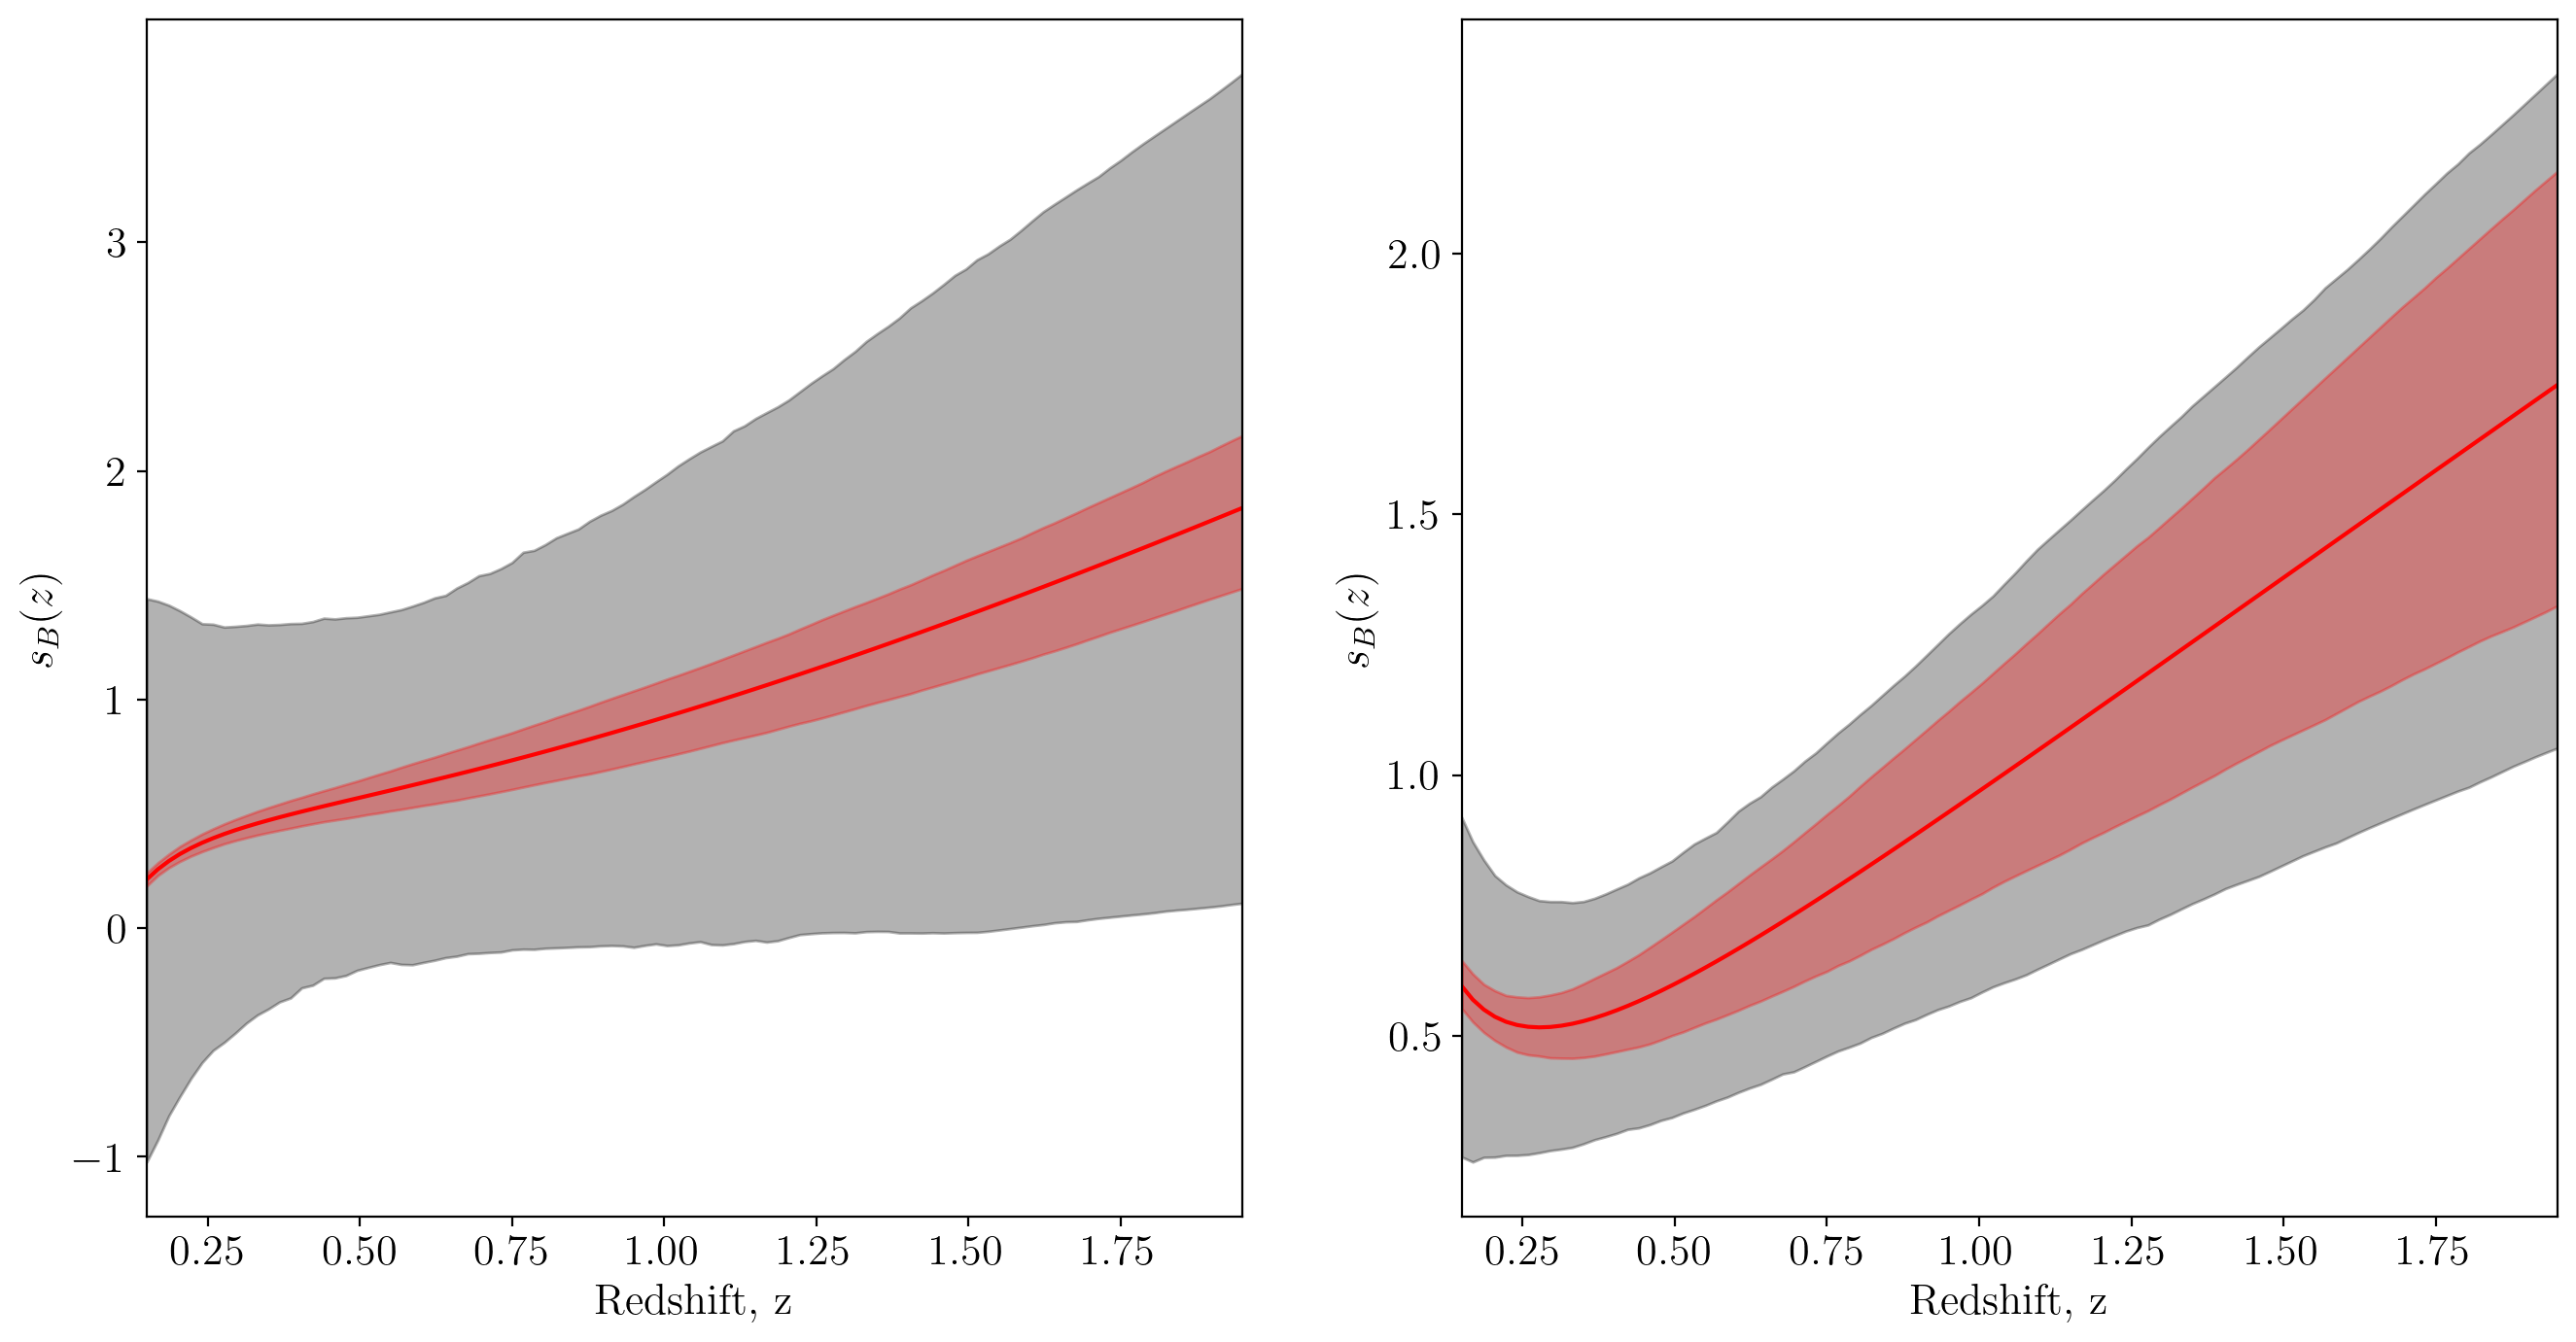

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, 'r-')
ax[0].fill_between(z_lin, sB_50_lower_bound_priors, sB_50_upper_bound_priors, color='black', alpha=0.3)
ax[0].fill_between(z_lin, sB_Joint_50_lower_bound, sB_Joint_50_upper_bound, color='red', alpha=0.3)

ax[1].plot(z_lin, sB_fid_30, 'r-')
ax[1].fill_between(z_lin, sB_30_lower_bound_priors, sB_30_upper_bound_priors, color='black', alpha=0.3)
ax[1].fill_between(z_lin, sB_Joint_30_lower_bound, sB_Joint_30_upper_bound, color='red', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_B(z)$')

Predictions for $s_M(z)$ vs Priors

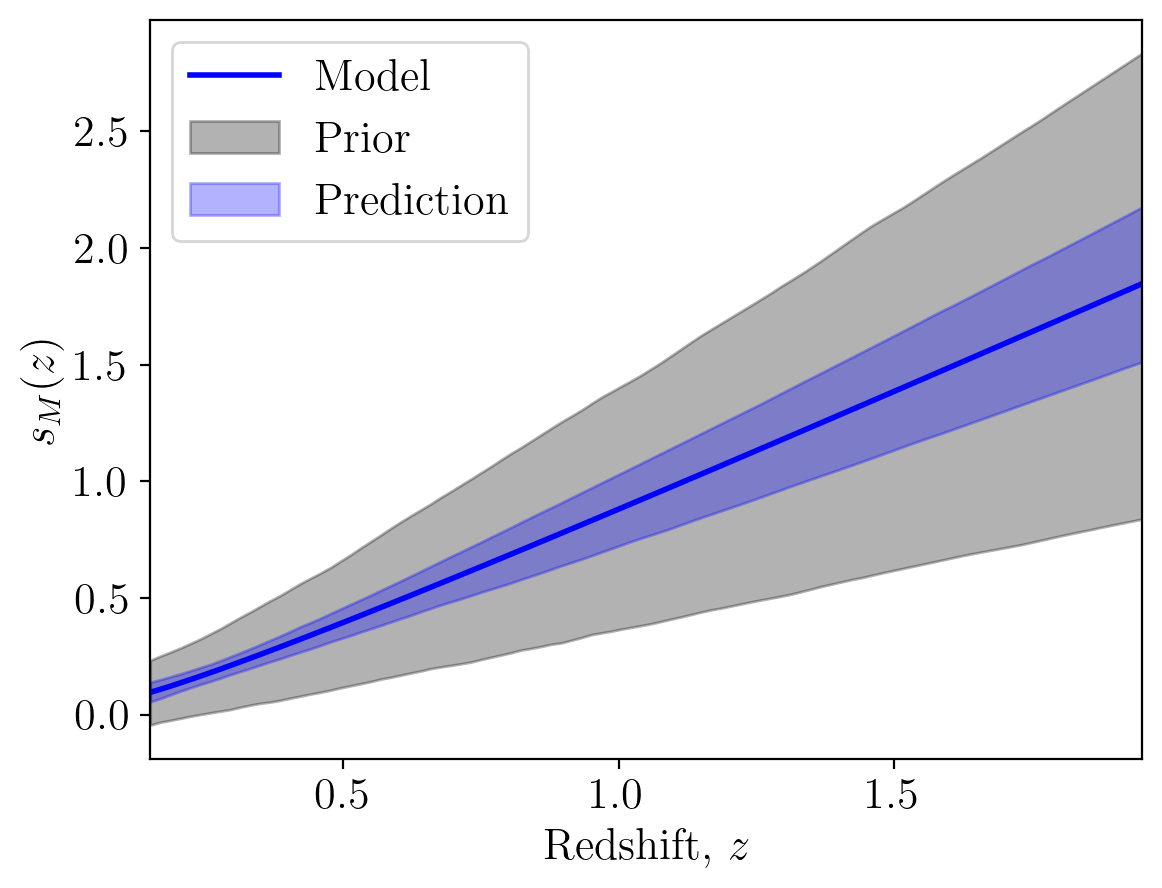

In [97]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label = 'Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
plt.fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='blue', alpha=0.3, label = r'Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.legend(loc='upper left');

### Magnification bias of the Faint, $s_F(z)$

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [98]:
sbias_fid = np.concatenate([sB_4fit50, sB_4fit30, sM_4fit])

np.shape(sbias_fid)

(12,)

In [99]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias = Sigma_Matrix_Joint50x30[:12, :12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_Joint_pars_samples = np.random.multivariate_normal(sbias_fid, cov_sbias, num_samples)

# Evaluate fitting function for each parameter sample
sB_Joint_50_samples_ = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_Joint_pars_samples])
sB_Joint_30_samples_ = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_Joint_pars_samples])
sM_Joint_samples_ = np.array([magbias_fit(pars[8:12], z_lin) for pars in sbias_Joint_pars_samples])

# Compute the sF for each sample
sF_50_samples_ = sM_Joint_samples_*m_50/(m_50-1) - sB_Joint_50_samples_/(m_50-1)
sF_30_samples_ = sM_Joint_samples_*m_30/(m_30-1) - sB_Joint_30_samples_/(m_30-1)


# Calculate the 68% confidence interval
sF_50_Joint_lower_bound_ = np.percentile(sF_50_samples_, 16, axis=0)
sF_50_Joint_upper_bound_ = np.percentile(sF_50_samples_, 84, axis=0)

sF_30_Joint_lower_bound_ = np.percentile(sF_30_samples_, 16, axis=0)
sF_30_Joint_upper_bound_ = np.percentile(sF_30_samples_, 84, axis=0)

Compare with priors

In [100]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_priors_ = Cov_prior_all[:12, :12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_pars_samples_priors_ = np.random.multivariate_normal(sbias_fid, cov_sbias_priors_, num_samples)

# Evaluate fitting function for each parameter sample
sB_50_samples_priors_ = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_priors_])
sB_30_samples_priors_ = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_priors_])
sM_samples_priors_ = np.array([magbias_fit(pars[8:12], z_lin) for pars in sbias_pars_samples_priors_])

# Compute the sF for each sample
sF_50_samples_priors_ = sM_samples_priors_*m_50/(m_50-1) - sB_50_samples_priors_/(m_50-1)
sF_30_samples_priors_ = sM_samples_priors_*m_30/(m_30-1) - sB_30_samples_priors_/(m_30-1)

# Calculate the 68% confidence interval
sF_50_lower_bound_priors_ = np.percentile(sF_50_samples_priors_, 16, axis=0)
sF_50_upper_bound_priors_ = np.percentile(sF_50_samples_priors_, 84, axis=0)

sF_30_lower_bound_priors_ = np.percentile(sF_30_samples_priors_, 16, axis=0)
sF_30_upper_bound_priors_ = np.percentile(sF_30_samples_priors_, 84, axis=0)

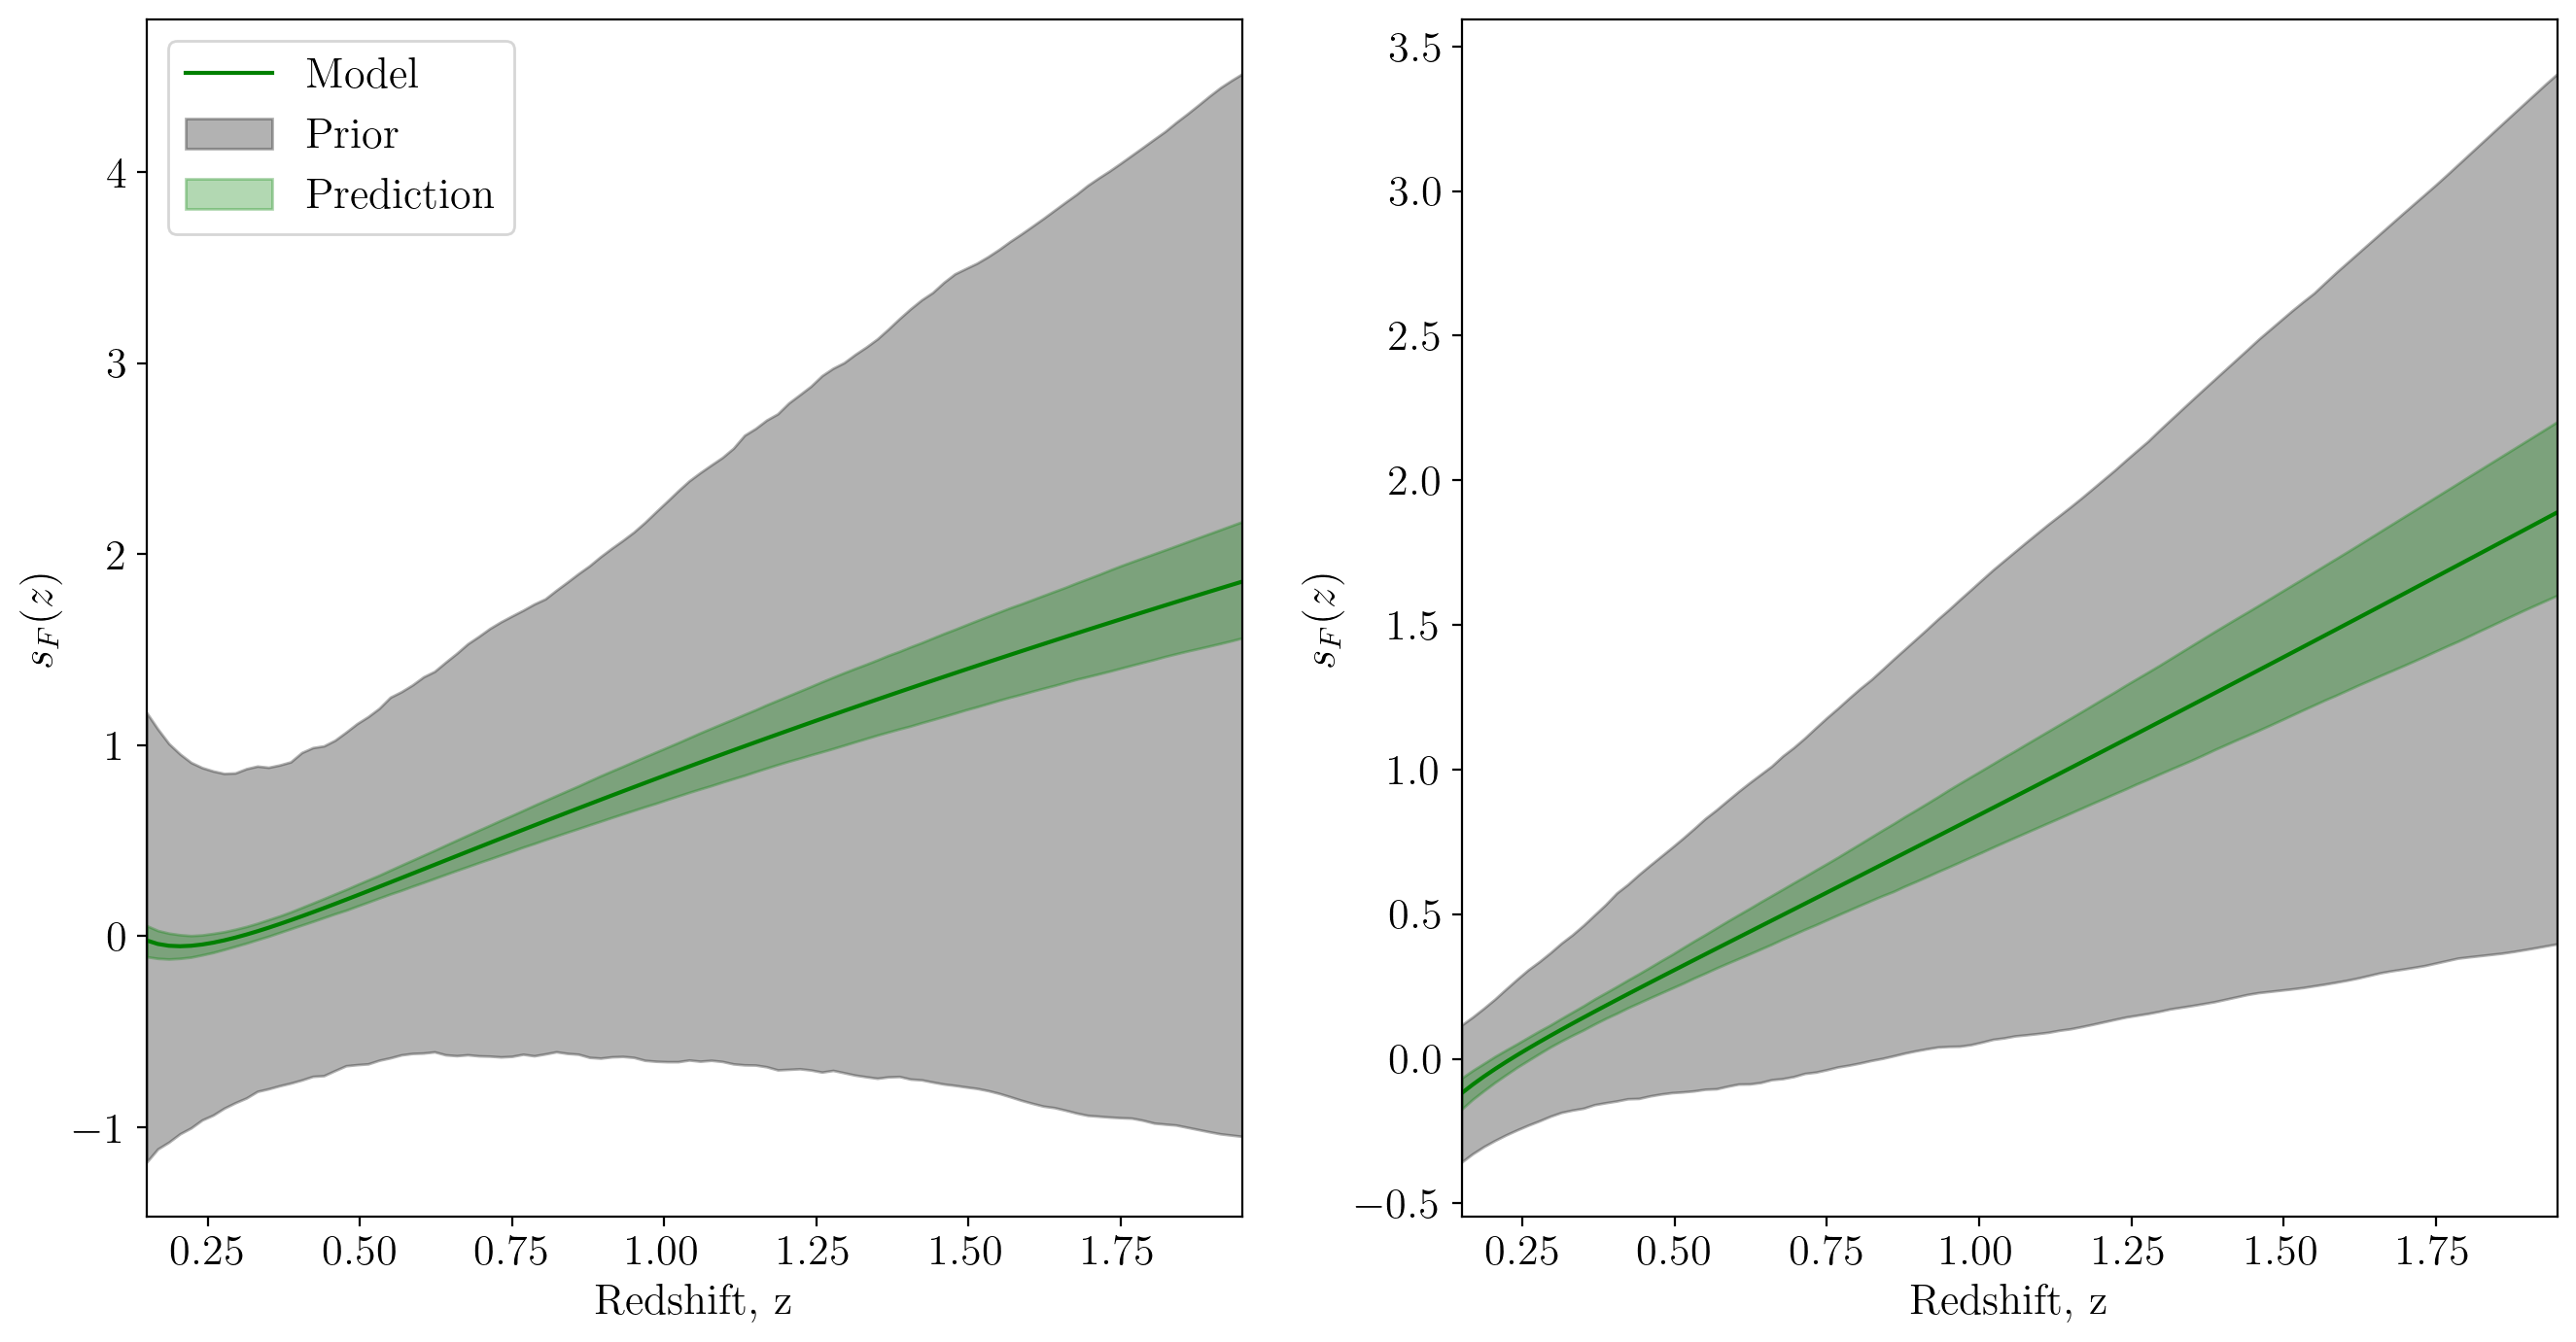

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sF_fid_50, '-', color = 'green', label = 'Model')
ax[0].fill_between(z_lin, sF_50_lower_bound_priors_, sF_50_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sF_50_Joint_lower_bound_, sF_50_Joint_upper_bound_, color='green', alpha=0.3, label = 'Prediction')

ax[1].plot(z_lin, sF_fid_30, '-', color = 'green')
ax[1].fill_between(z_lin, sF_30_lower_bound_priors_, sF_30_upper_bound_priors_, color='black', alpha=0.3)
ax[1].fill_between(z_lin, sF_30_Joint_lower_bound_, sF_30_Joint_upper_bound_, color='green', alpha=0.3)

ax[0].legend(loc='upper left')

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_F(z)$')

## Number evolution

In [102]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

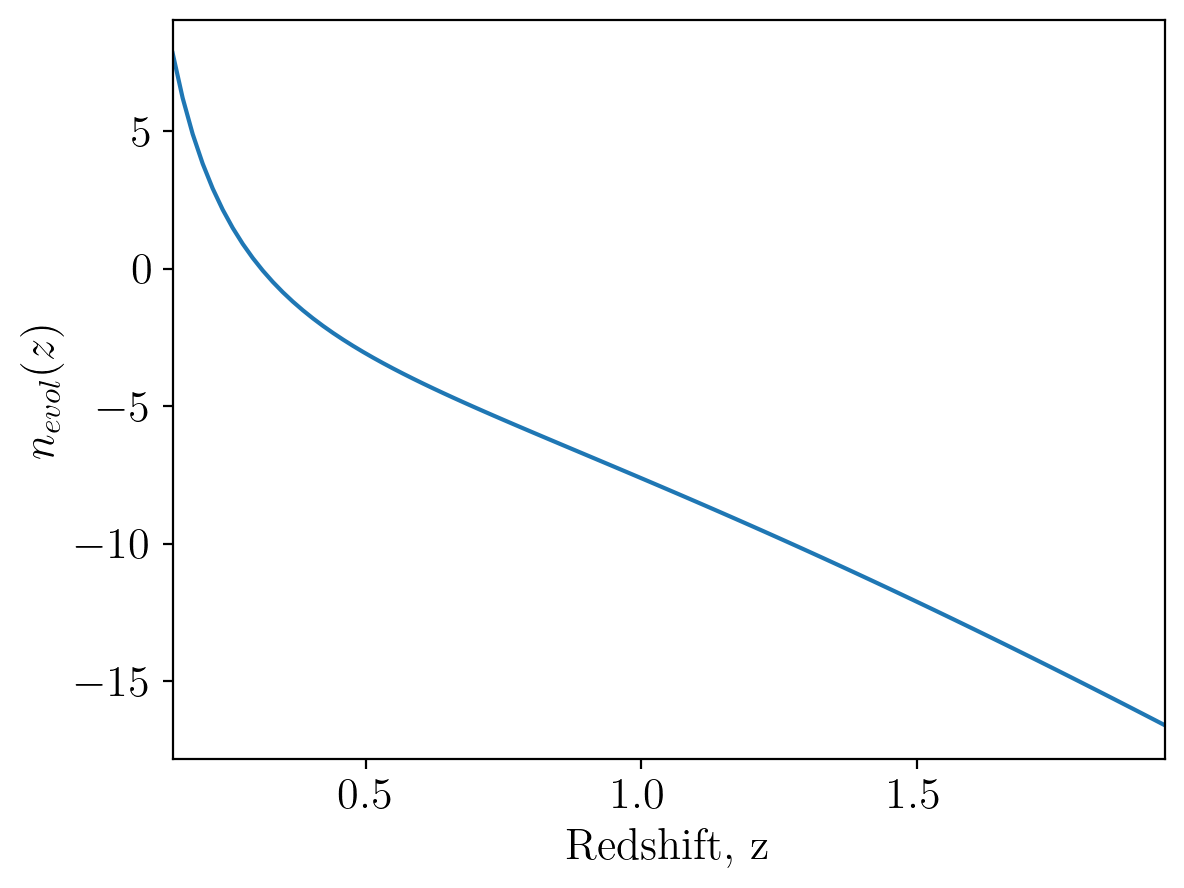

In [103]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(num_fit, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');
#plt.title('Fitting model for the number desnsitiy evolution');

In [104]:
# Select the marginalized covariance matrix for the number evolution
cov_Joint_numevol = Sigma_Matrix_Joint50x30[12:16, 12:16]
cov_numevol_priors = Cov_prior_all[12:16, 12:16]


# Generate parameter samples from multivariate normal distribution
num_samples = 1000
nevol_Joint_pars_samples = np.random.multivariate_normal(num_fit, cov_Joint_numevol, num_samples)
nevol_samples_priors = np.random.multivariate_normal(num_fit, cov_numevol_priors, num_samples)


# Evaluate fitting function for each parameter sample
nevol_Joint_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_Joint_pars_samples])
nevol_samples_priors = np.array([nevol_fit(pars, z_lin) for pars in nevol_samples_priors])

# Calculate the 68% confidence interval
nevol_Joint_lower_bound = np.percentile(nevol_Joint_samples, 16, axis=0)
nevol_Joint_upper_bound = np.percentile(nevol_Joint_samples, 84, axis=0)
nevol_lower_bound_priors = np.percentile(nevol_samples_priors, 16, axis=0)
nevol_upper_bound_priors = np.percentile(nevol_samples_priors, 84, axis=0)

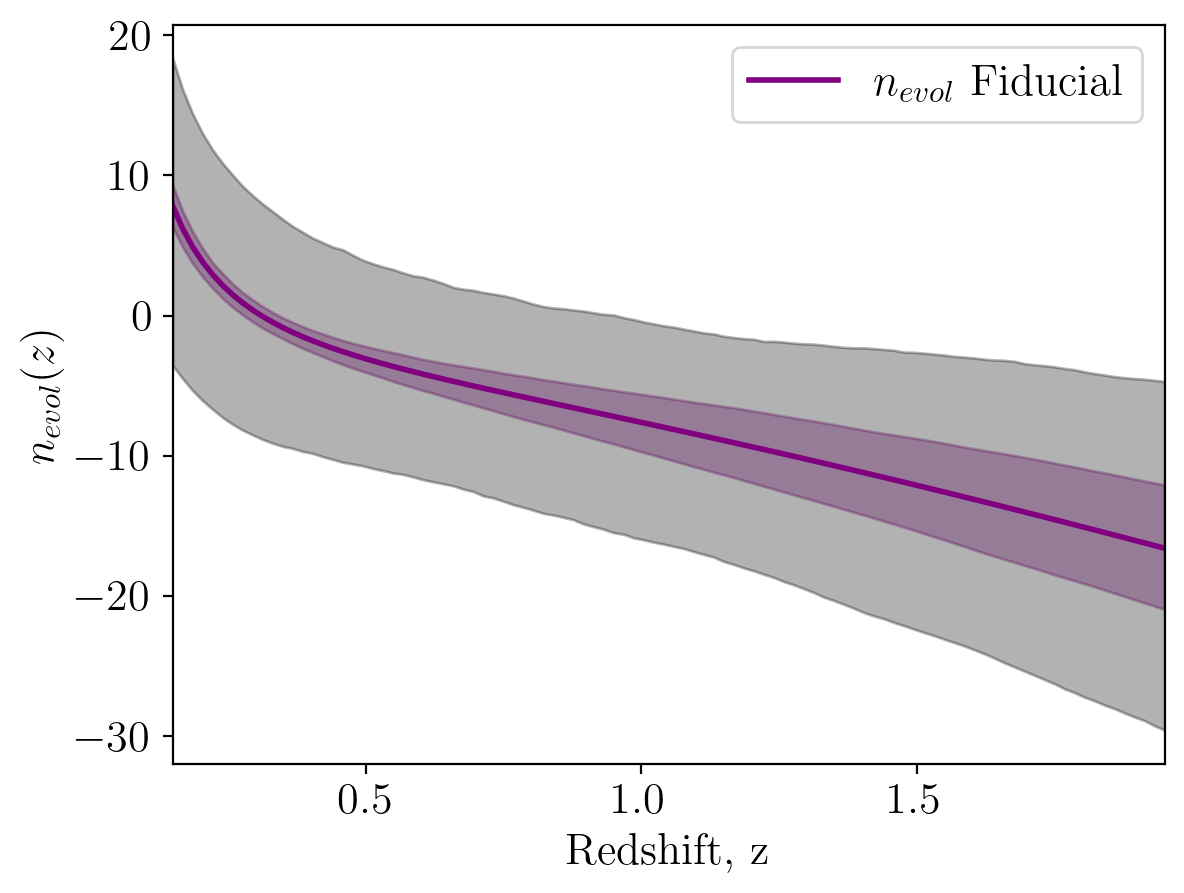

In [105]:
plt.plot(z_lin, num_evol_fid, '-', color='purple', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='purple', alpha=0.3)
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

## Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [106]:
from biasmodels import EvolutionBias

In [107]:
myEvolBias_50 = EvolutionBias(n_split=m_50)
myEvolBias_30 = EvolutionBias(n_split=m_30)


dlogH = myEvolBias_50.dlogH
rHterm = myEvolBias_50.rHterm
dFstar = myEvolBias_50.dLogFstar
dFcut = myEvolBias_50.dLogFcut

In [108]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

In [109]:
sbias_fid_50 = np.concatenate([sB_4fit50, sM_4fit])
sbias_fid_30 = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_fid_50), np.shape(sbias_fid_30)

((8,), (8,))

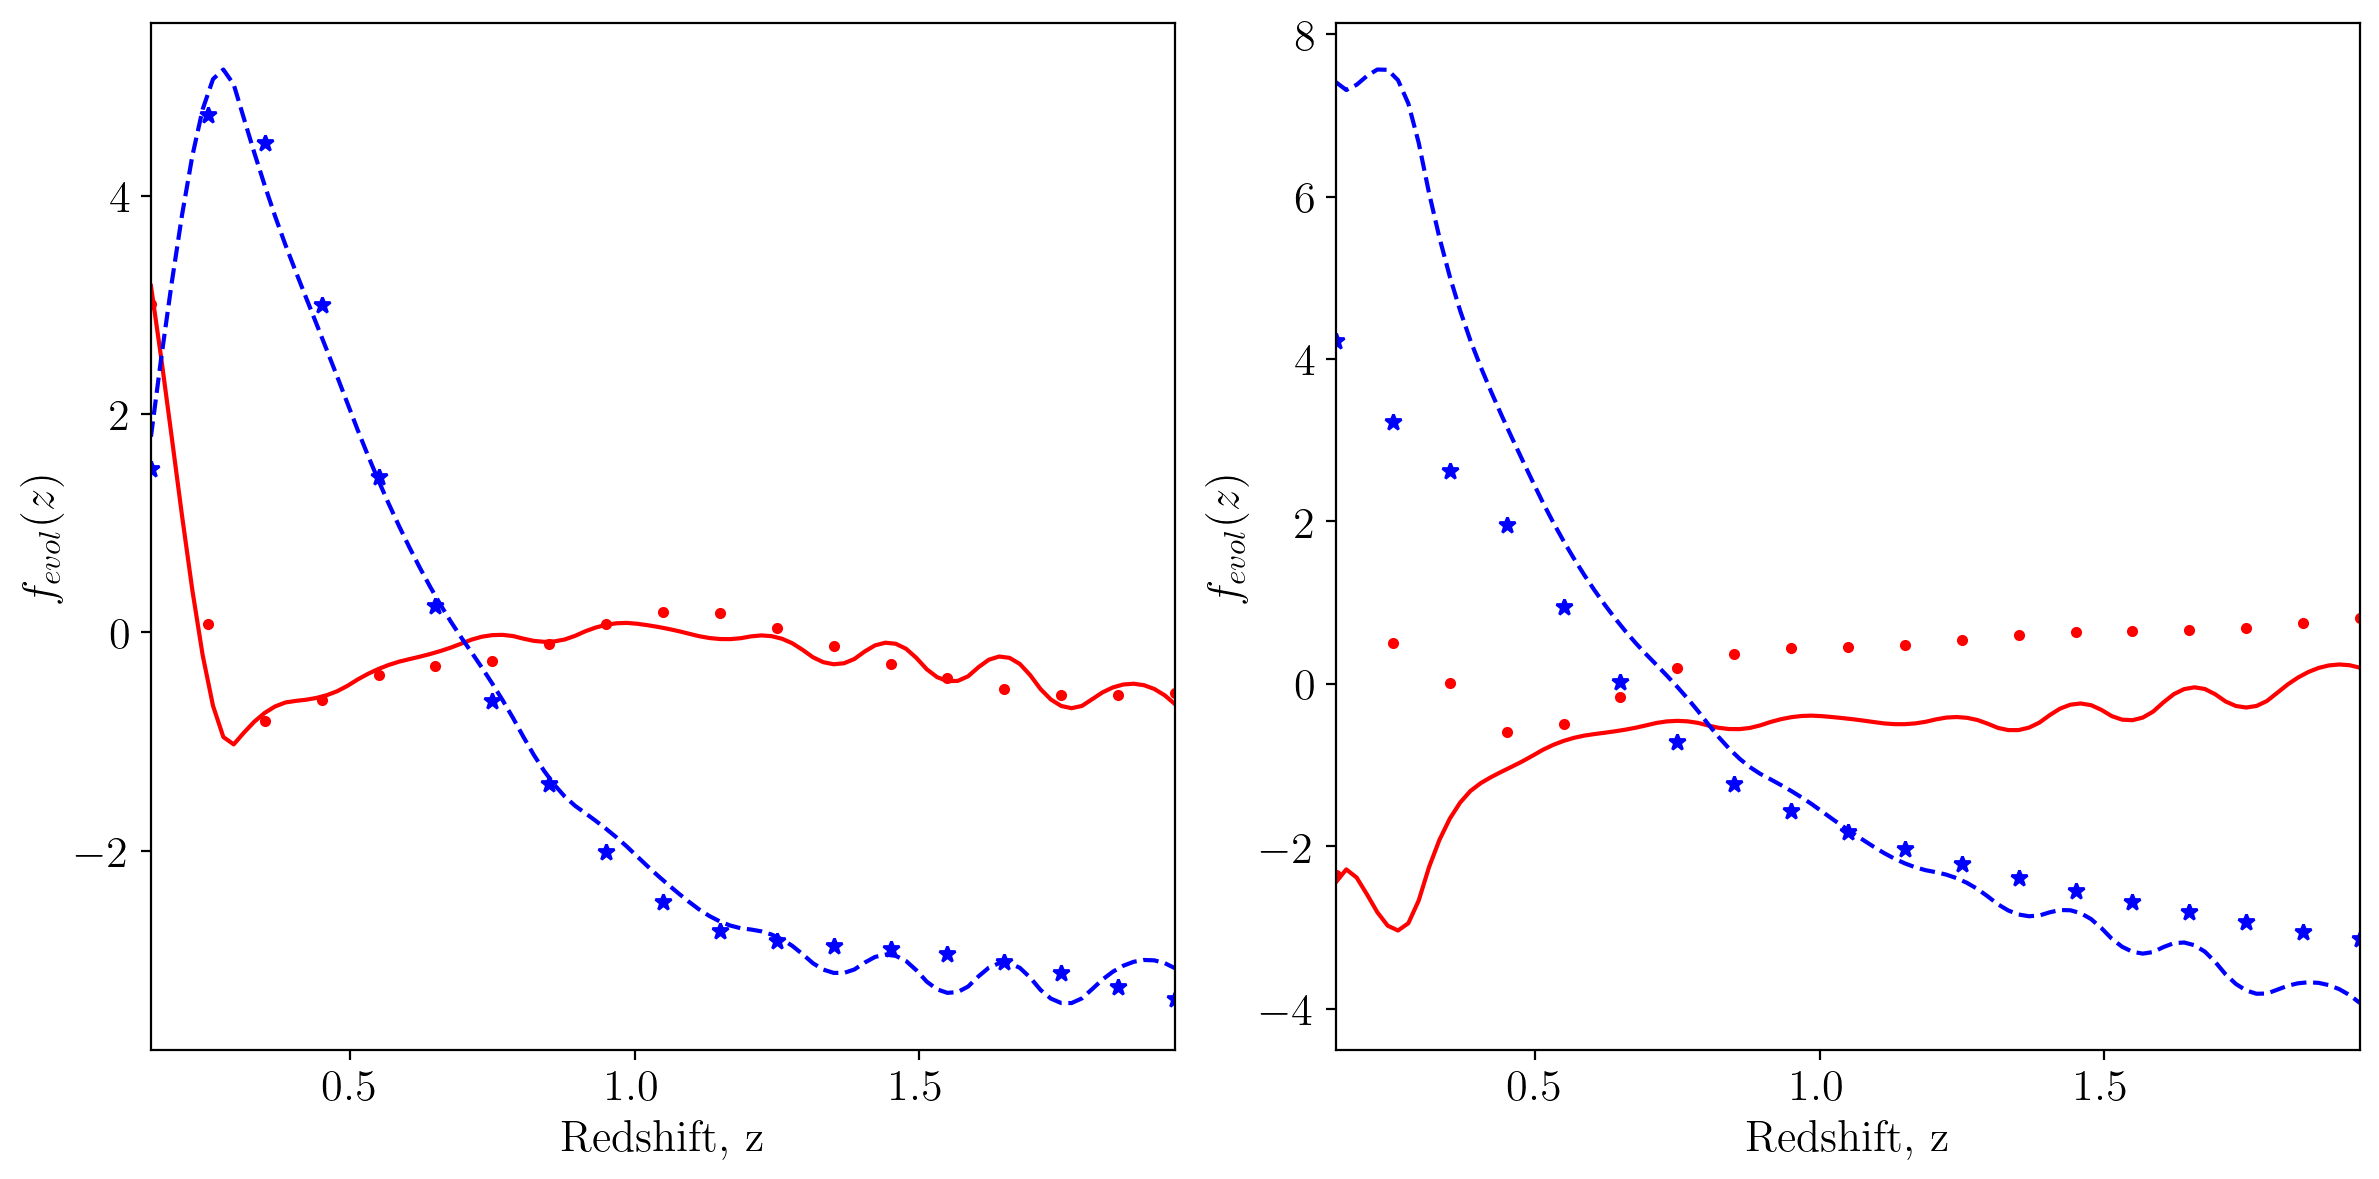

In [110]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_50_B_fid = fevol_bright(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)
fevol_50_F_fid = fevol_faint(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)

fevol_30_B_fid = fevol_bright(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)
fevol_30_F_fid = fevol_faint(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)

feB_50 = myEvolBias_50.fevol_bright(z_bins)
feF_50 = myEvolBias_50.fevol_faint(z_bins)

feB_30 = myEvolBias_30.fevol_bright(z_bins)
feF_30 = myEvolBias_30.fevol_faint(z_bins)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, 'r-')
ax[0].plot(z_lin, fevol_50_F_fid, 'b--')
ax[0].plot(z_bins, feB_50, 'r.', label='Bright')
ax[0].plot(z_bins, feF_50, 'b*', label='Faint')

ax[1].plot(z_lin, fevol_30_B_fid, 'r-')
ax[1].plot(z_lin, fevol_30_F_fid, 'b--')
ax[1].plot(z_bins, feB_30, 'r.', label='Bright')
ax[1].plot(z_bins, feF_30, 'b*', label='Faint')

for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, z');
    axi.set_ylabel(r'$f_{evol}(z)$');

In [111]:
list(range(4,8))

[4, 5, 6, 7]

In [112]:
# Select the marginalized covariance matrix for the parameters

cov_Joint_all = Sigma_Matrix_Joint50x30[:16, :16]
cov_all_priors = Cov_prior_all[:16, :16]

all_fid = np.concatenate([sbias_fid, num_fit])

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
all_Joint_pars_samples = np.random.multivariate_normal(all_fid, cov_Joint_all, num_samples)
all_pars_samples_priors = np.random.multivariate_normal(all_fid, cov_all_priors, num_samples)

nind_50 = list(range(4,8))

all_Joint_50_pars_samples = all_Joint_pars_samples
all_Joint_50_pars_samples = np.delete(all_Joint_50_pars_samples, nind_50, axis=1)
all_50_pars_samples_priors = all_pars_samples_priors
all_50_pars_samples_priors = np.delete(all_50_pars_samples_priors, nind_50, axis=1)

nind_30 = list(range(0,4))

all_Joint_30_pars_samples = all_Joint_pars_samples
all_Joint_30_pars_samples = np.delete(all_Joint_30_pars_samples, nind_30, axis=1)
all_30_pars_samples_priors = all_pars_samples_priors
all_30_pars_samples_priors = np.delete(all_30_pars_samples_priors, nind_30, axis=1)

In [113]:
# Evaluate fitting function for each parameter sample

fevol_Joint_50_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_50_pars_samples])
fevol_Joint_50_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors])
fevol_Joint_50_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_50_pars_samples])
fevol_Joint_50_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors])

fevol_Joint_30_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_30_pars_samples])
fevol_Joint_30_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors])
fevol_Joint_30_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_30_pars_samples])
fevol_Joint_30_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors])

# Calculate the 68% confidence intervals

fevol_B_50_lower_bound = np.percentile(fevol_Joint_50_B_samples, 16, axis=0)
fevol_B_50_upper_bound = np.percentile(fevol_Joint_50_B_samples, 84, axis=0)
fevol_B_50_lower_bound_priors = np.percentile(fevol_Joint_50_B_samples_priors, 16, axis=0)
fevol_B_50_upper_bound_priors = np.percentile(fevol_Joint_50_B_samples_priors, 84, axis=0)

fevol_F_50_lower_bound = np.percentile(fevol_Joint_50_F_samples, 16, axis=0)
fevol_F_50_upper_bound = np.percentile(fevol_Joint_50_F_samples, 84, axis=0)
fevol_F_50_lower_bound_priors = np.percentile(fevol_Joint_50_F_samples_priors, 16, axis=0)
fevol_F_50_upper_bound_priors = np.percentile(fevol_Joint_50_F_samples_priors, 84, axis=0)

fevol_B_30_lower_bound = np.percentile(fevol_Joint_30_B_samples, 16, axis=0)
fevol_B_30_upper_bound = np.percentile(fevol_Joint_30_B_samples, 84, axis=0)
fevol_B_30_lower_bound_priors = np.percentile(fevol_Joint_30_B_samples_priors, 16, axis=0)
fevol_B_30_upper_bound_priors = np.percentile(fevol_Joint_30_B_samples_priors, 84, axis=0)

fevol_F_30_lower_bound = np.percentile(fevol_Joint_30_F_samples, 16, axis=0)
fevol_F_30_upper_bound = np.percentile(fevol_Joint_30_F_samples, 84, axis=0)
fevol_F_30_lower_bound_priors = np.percentile(fevol_Joint_30_F_samples_priors, 16, axis=0)
fevol_F_30_upper_bound_priors = np.percentile(fevol_Joint_30_F_samples_priors, 84, axis=0)

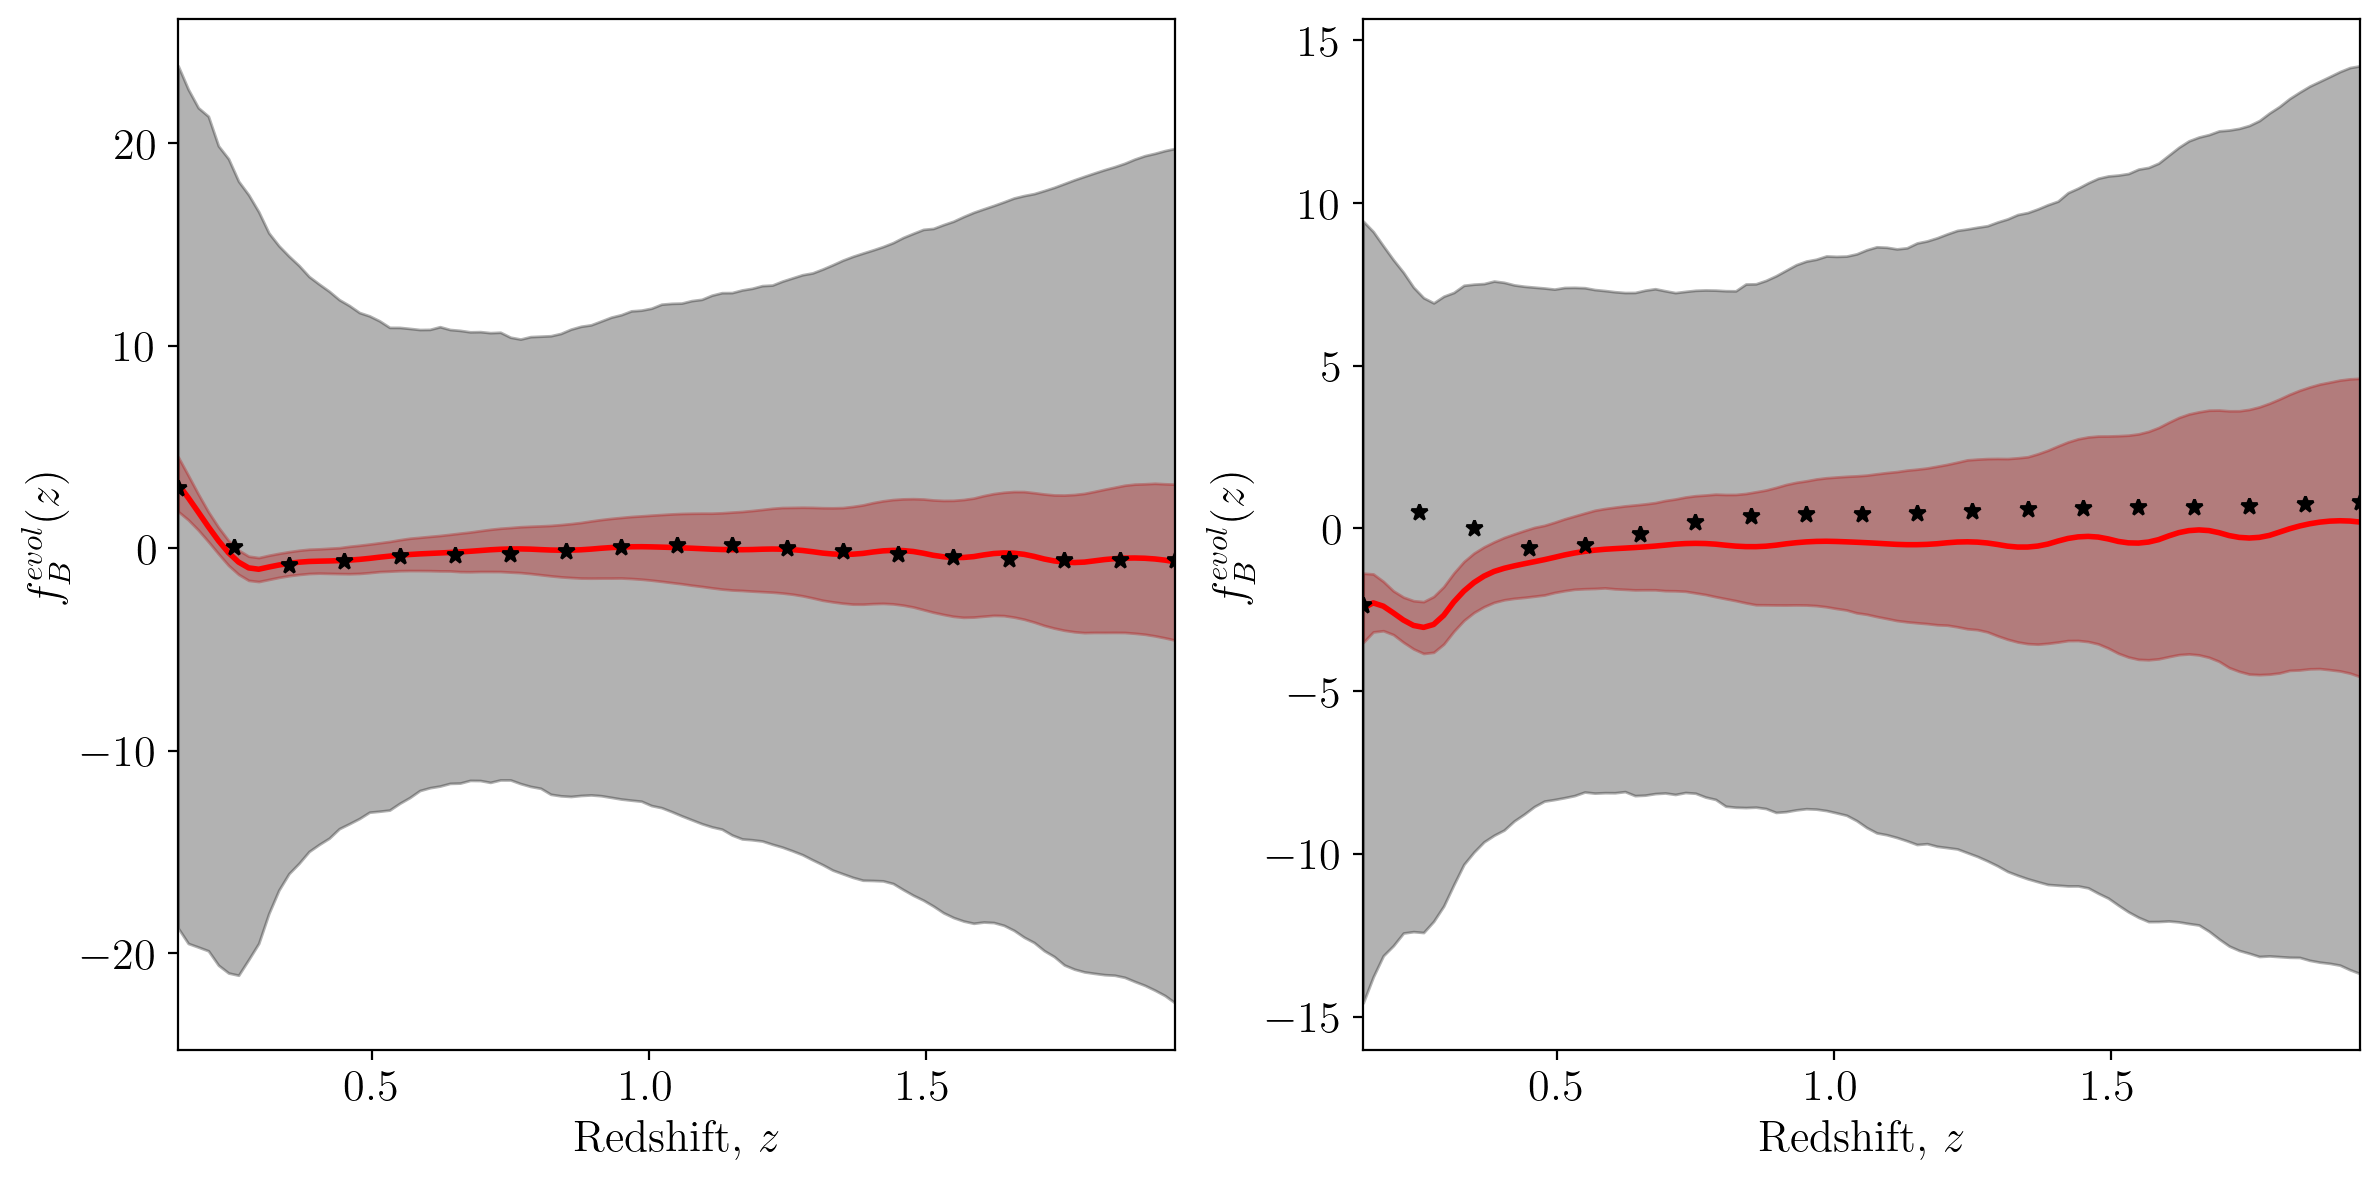

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feB_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_B_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feB_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_B_50_lower_bound, fevol_B_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_priors, fevol_B_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_B_30_lower_bound, fevol_B_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_priors, fevol_B_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_B(z)$')

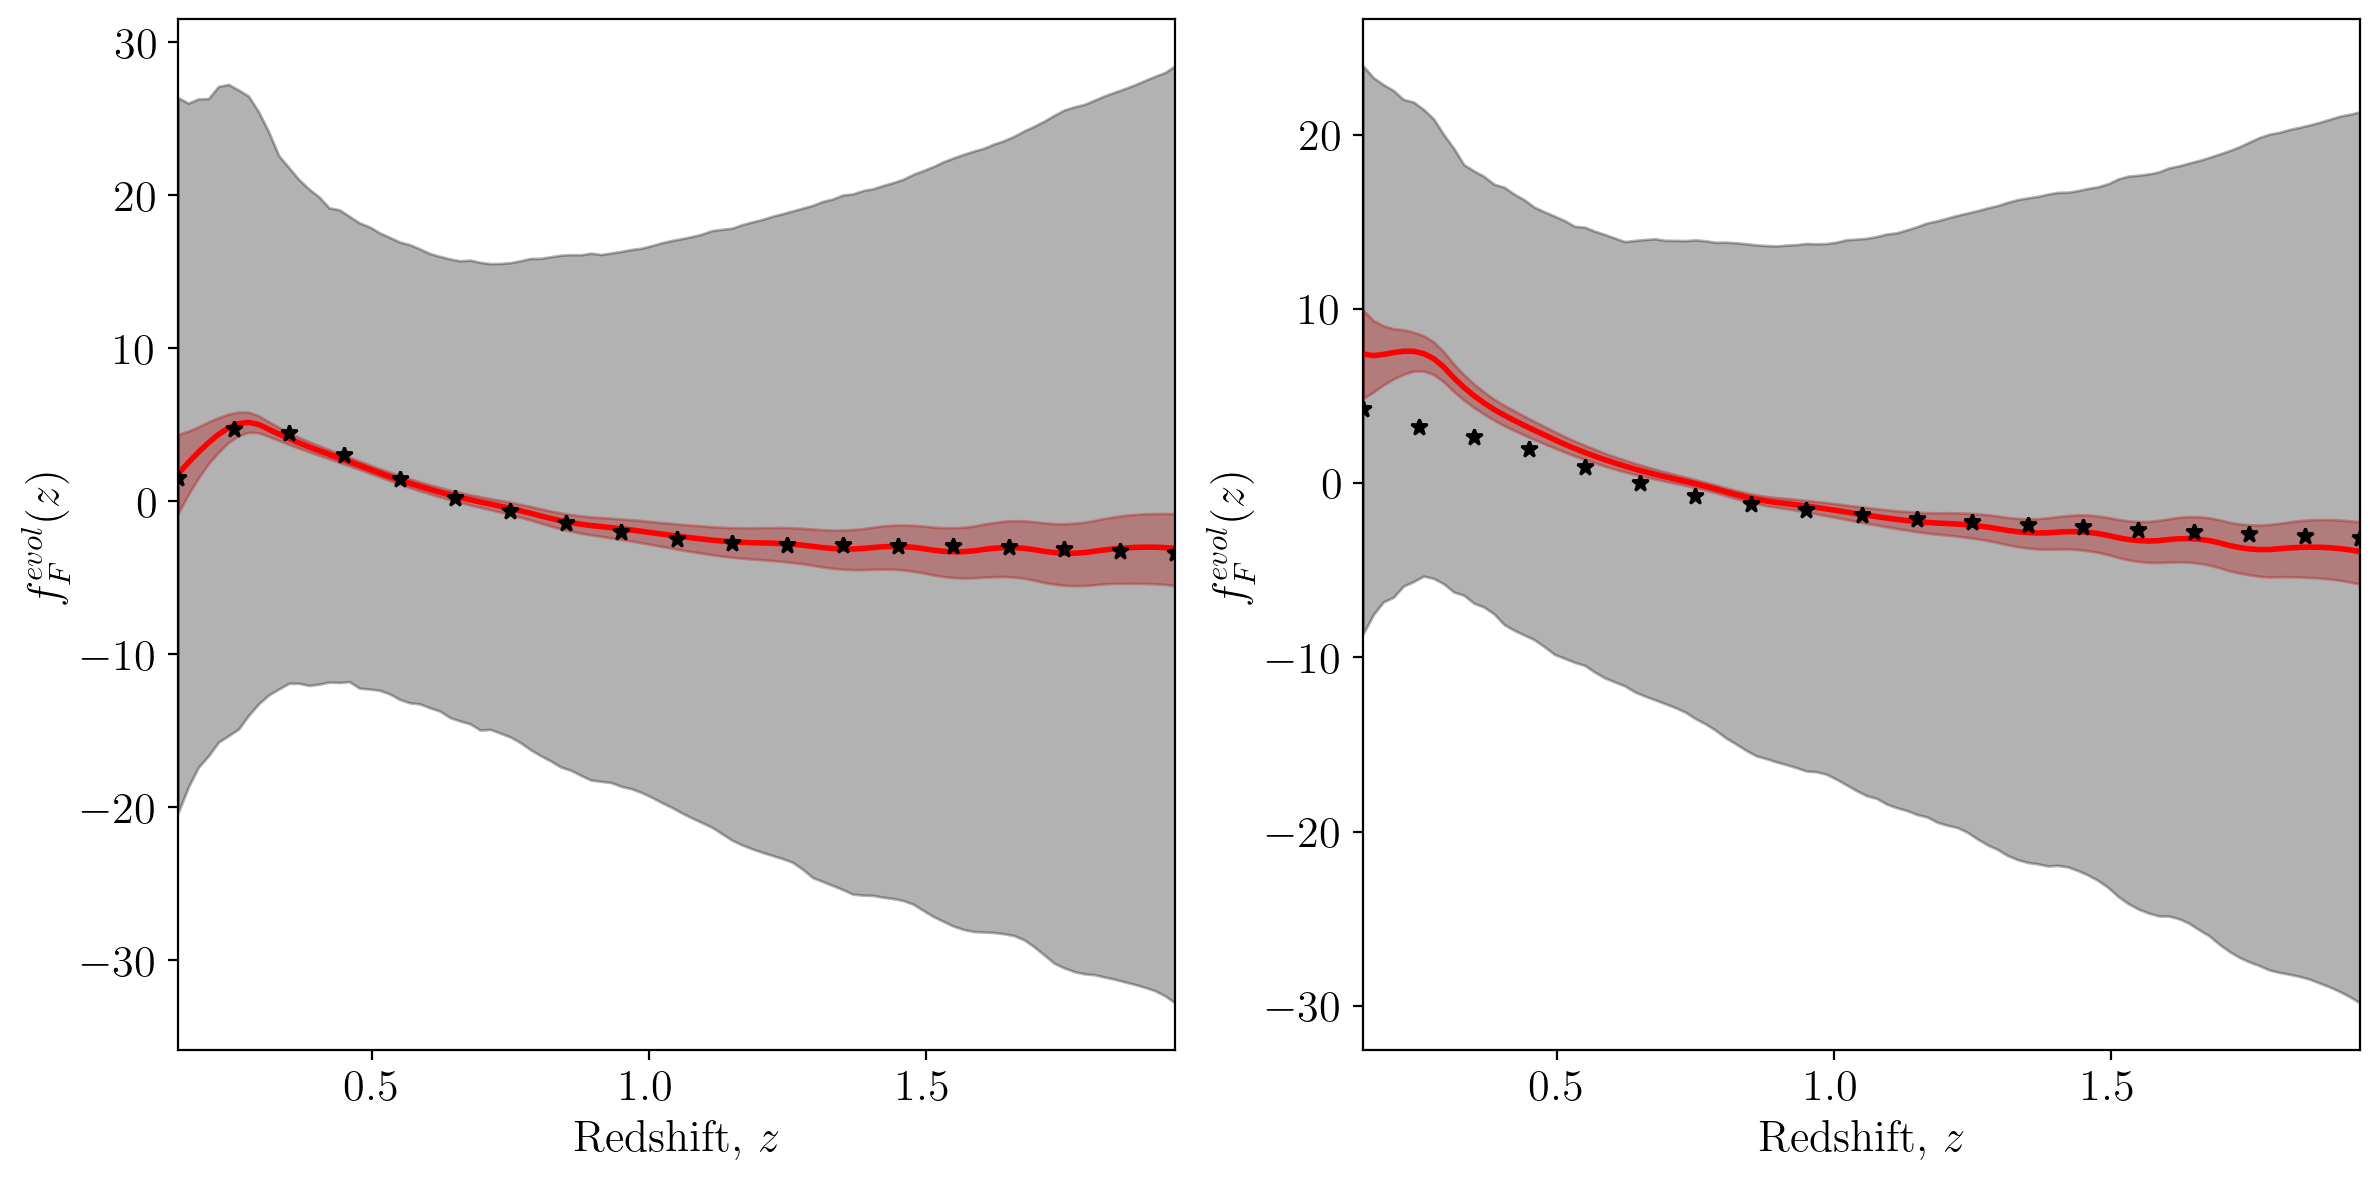

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_F_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feF_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_F_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feF_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_F_50_lower_bound, fevol_F_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_priors, fevol_F_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_F_30_lower_bound, fevol_F_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_priors, fevol_F_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_F(z)$')

# Comparison with Individual Splits

## Magnification bias

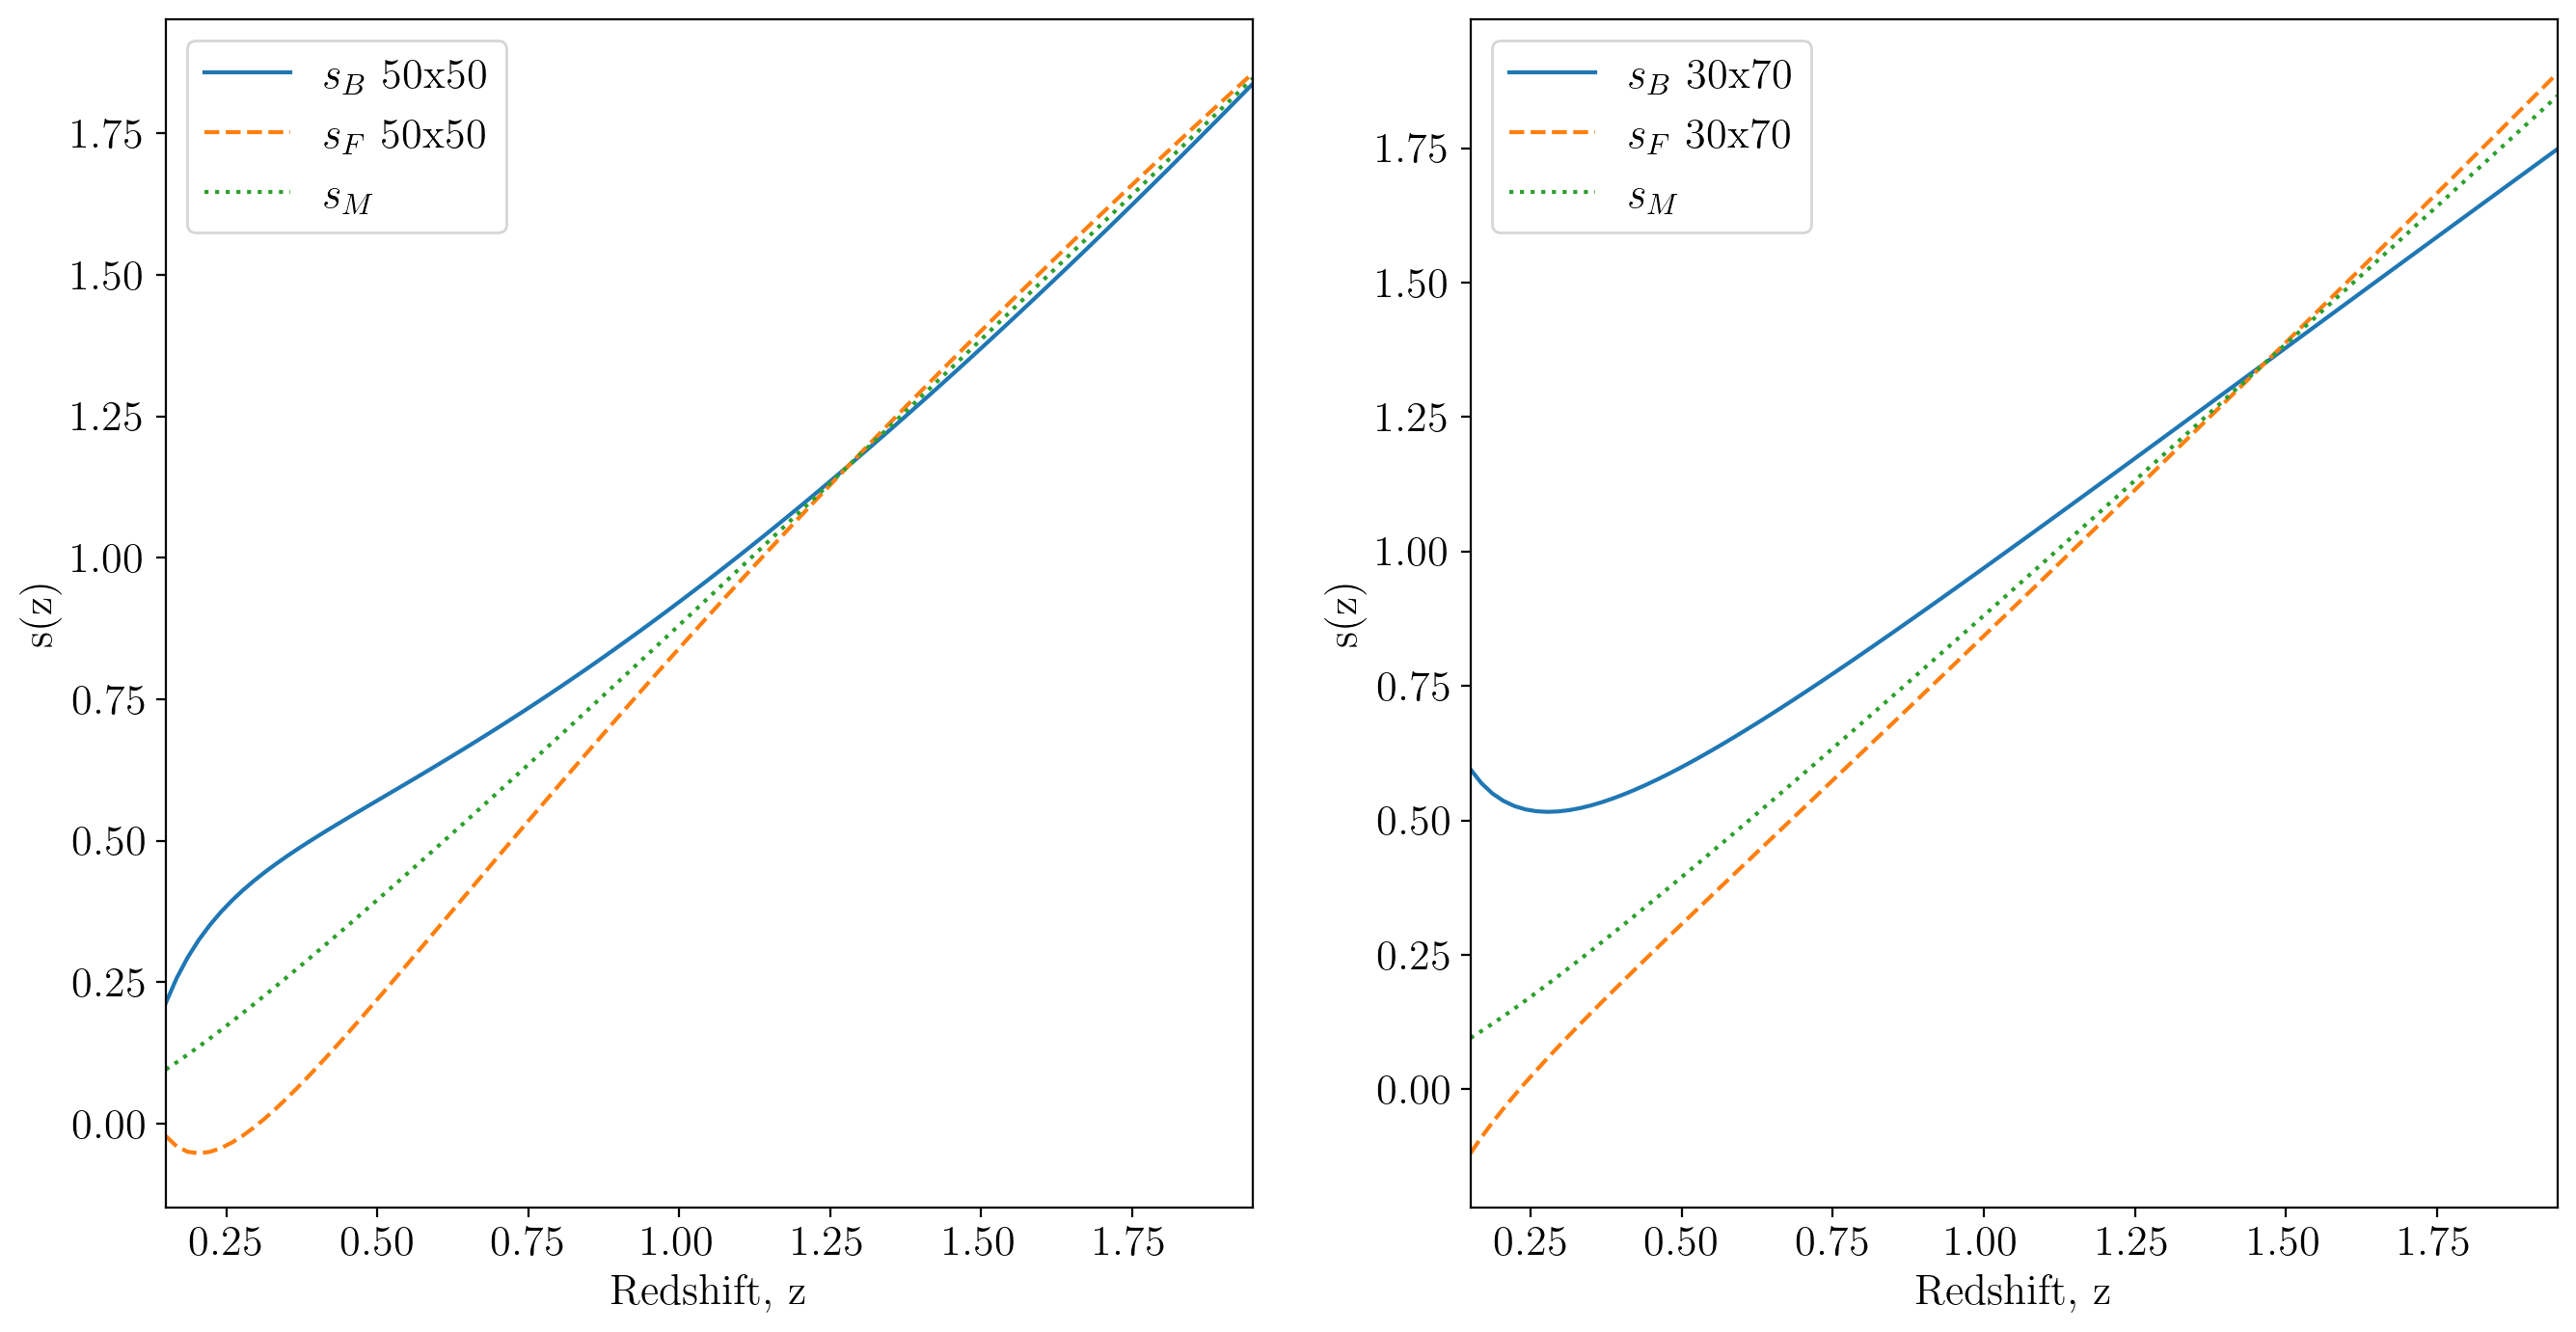

In [116]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

m_50 = 2.
m_30 = 10/3.

sB_fid_50 = magbias_fit(sB_fit[:4], z_lin)
sB_fid_30 = magbias_fit(sB_fit[4:], z_lin)
sM_fid = magbias_fit(sM_4fit, z_lin)
sF_fid_50 = sM_fid * (m_50/(m_50-1)) - sB_fid_50/(m_50-1)
sF_fid_30 = sM_fid * (m_30/(m_30-1)) - sB_fid_30/(m_30-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, '-', label=r'$s_B$ 50x50')
ax[0].plot(z_lin, sF_fid_50, '--', label=r'$s_F$ 50x50')
ax[0].plot(z_lin, sM_fid, ':', label=r'$s_M$')

ax[1].plot(z_lin, sB_fid_30, '-', label=r'$s_B$ 30x70')
ax[1].plot(z_lin, sF_fid_30, '--', label=r'$s_F$ 30x70')
ax[1].plot(z_lin, sM_fid, ':', label=r'$s_M$')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r's(z)')
    axi.legend();


### Observables: $s_B(z)$ and $s_M(z)$

In [117]:
# Compute priors 

# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_50_priors = Cov_prior_all[:4, :4]
cov_sB_30_priors = Cov_prior_all[4:8, 4:8]
cov_sM_priors = Cov_prior_all[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
sB_50_pars_samples_priors = np.random.multivariate_normal(sB_4fit50, cov_sB_50_priors, num_samples)
sB_30_pars_samples_priors = np.random.multivariate_normal(sB_4fit30, cov_sB_30_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sM_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample

sB_50_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples_priors])

sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval

sB_50_lower_bound_priors = np.percentile(sB_50_samples_priors, 16, axis=0)
sB_50_upper_bound_priors = np.percentile(sB_50_samples_priors, 84, axis=0)

sB_30_lower_bound_priors = np.percentile(sB_30_samples_priors, 16, axis=0)
sB_30_upper_bound_priors = np.percentile(sB_30_samples_priors, 84, axis=0)

sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)


In [118]:
np.shape(Sigma_Matrix_30)

(21, 21)

In [119]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_50 = Sigma_Matrix_50[:4, :4]
cov_sB_30 = Sigma_Matrix_30[:4, :4]
cov_sM_50 = Sigma_Matrix_50[4:8, 4:8]
cov_sM_30 = Sigma_Matrix_30[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sB_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_50, num_samples)
sB_30_pars_samples = np.random.multivariate_normal(sB_4fit30, cov_sB_30, num_samples)
sM_50_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_50, num_samples)
sM_30_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_30, num_samples)

# Evaluate fitting function for each parameter sample
sB_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples])
sB_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples])
sM_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_50_pars_samples])
sM_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_30_pars_samples])

# Calculate the 68% confidence interval
sB_50_lower_bound = np.percentile(sB_50_samples, 16, axis=0)
sB_50_upper_bound = np.percentile(sB_50_samples, 84, axis=0)

sB_30_lower_bound = np.percentile(sB_30_samples, 16, axis=0)
sB_30_upper_bound = np.percentile(sB_30_samples, 84, axis=0)

sM_50_lower_bound = np.percentile(sM_50_samples, 16, axis=0)
sM_50_upper_bound = np.percentile(sM_50_samples, 84, axis=0)
sM_30_lower_bound = np.percentile(sM_30_samples, 16, axis=0)
sM_30_upper_bound = np.percentile(sM_30_samples, 84, axis=0)

Predictions for $s_B(z)$ vs Priors

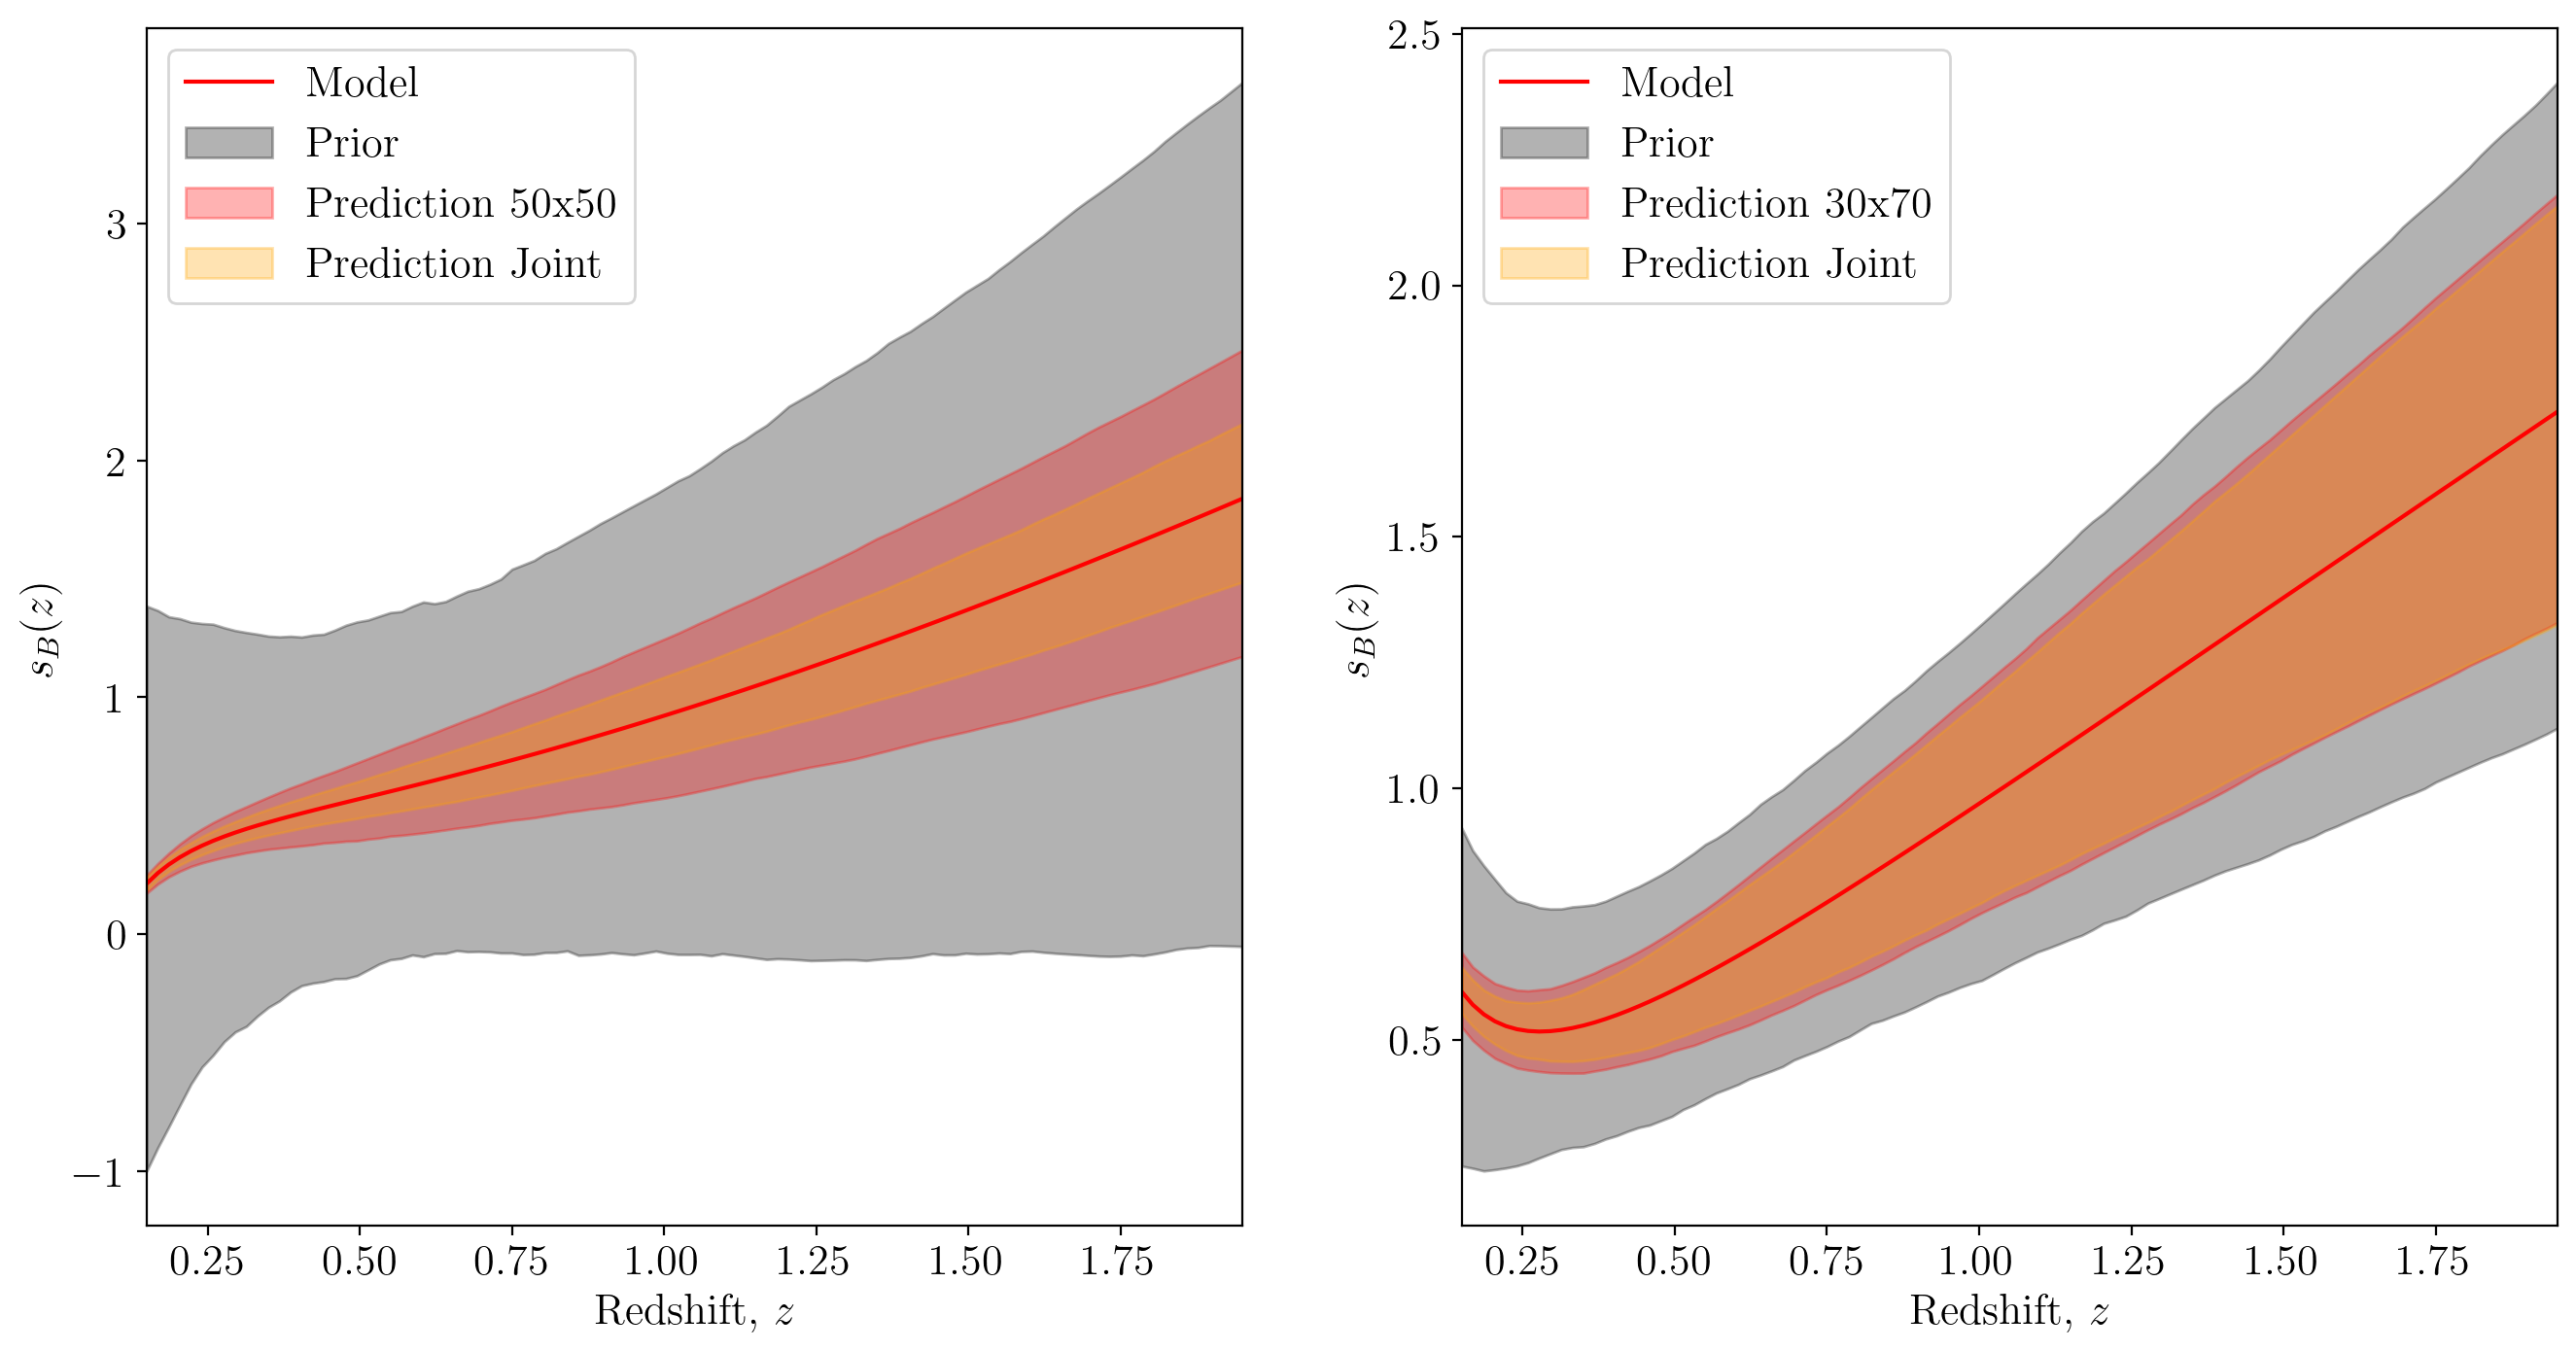

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, 'r-', label = r'Model')
ax[0].fill_between(z_lin, sB_50_lower_bound_priors, sB_50_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sB_50_lower_bound, sB_50_upper_bound, color='red', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, sB_Joint_50_lower_bound, sB_Joint_50_upper_bound, color='orange', alpha=0.3, label = 'Prediction Joint')
ax[0].legend(loc='upper left')

ax[1].plot(z_lin, sB_fid_30, 'r-', label = r'Model')
ax[1].fill_between(z_lin, sB_30_lower_bound_priors, sB_30_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, sB_30_lower_bound, sB_30_upper_bound, color='red', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, sB_Joint_30_lower_bound, sB_Joint_30_upper_bound, color='orange', alpha=0.3, label = 'Prediction Joint')
ax[1].legend(loc='upper left')

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$s_B(z)$')
    
plt.savefig("plots/sB_prediction_joint_vs_prior.pdf", bbox_inches='tight', format='pdf')

Predictions for $s_M(z)$ vs Priors

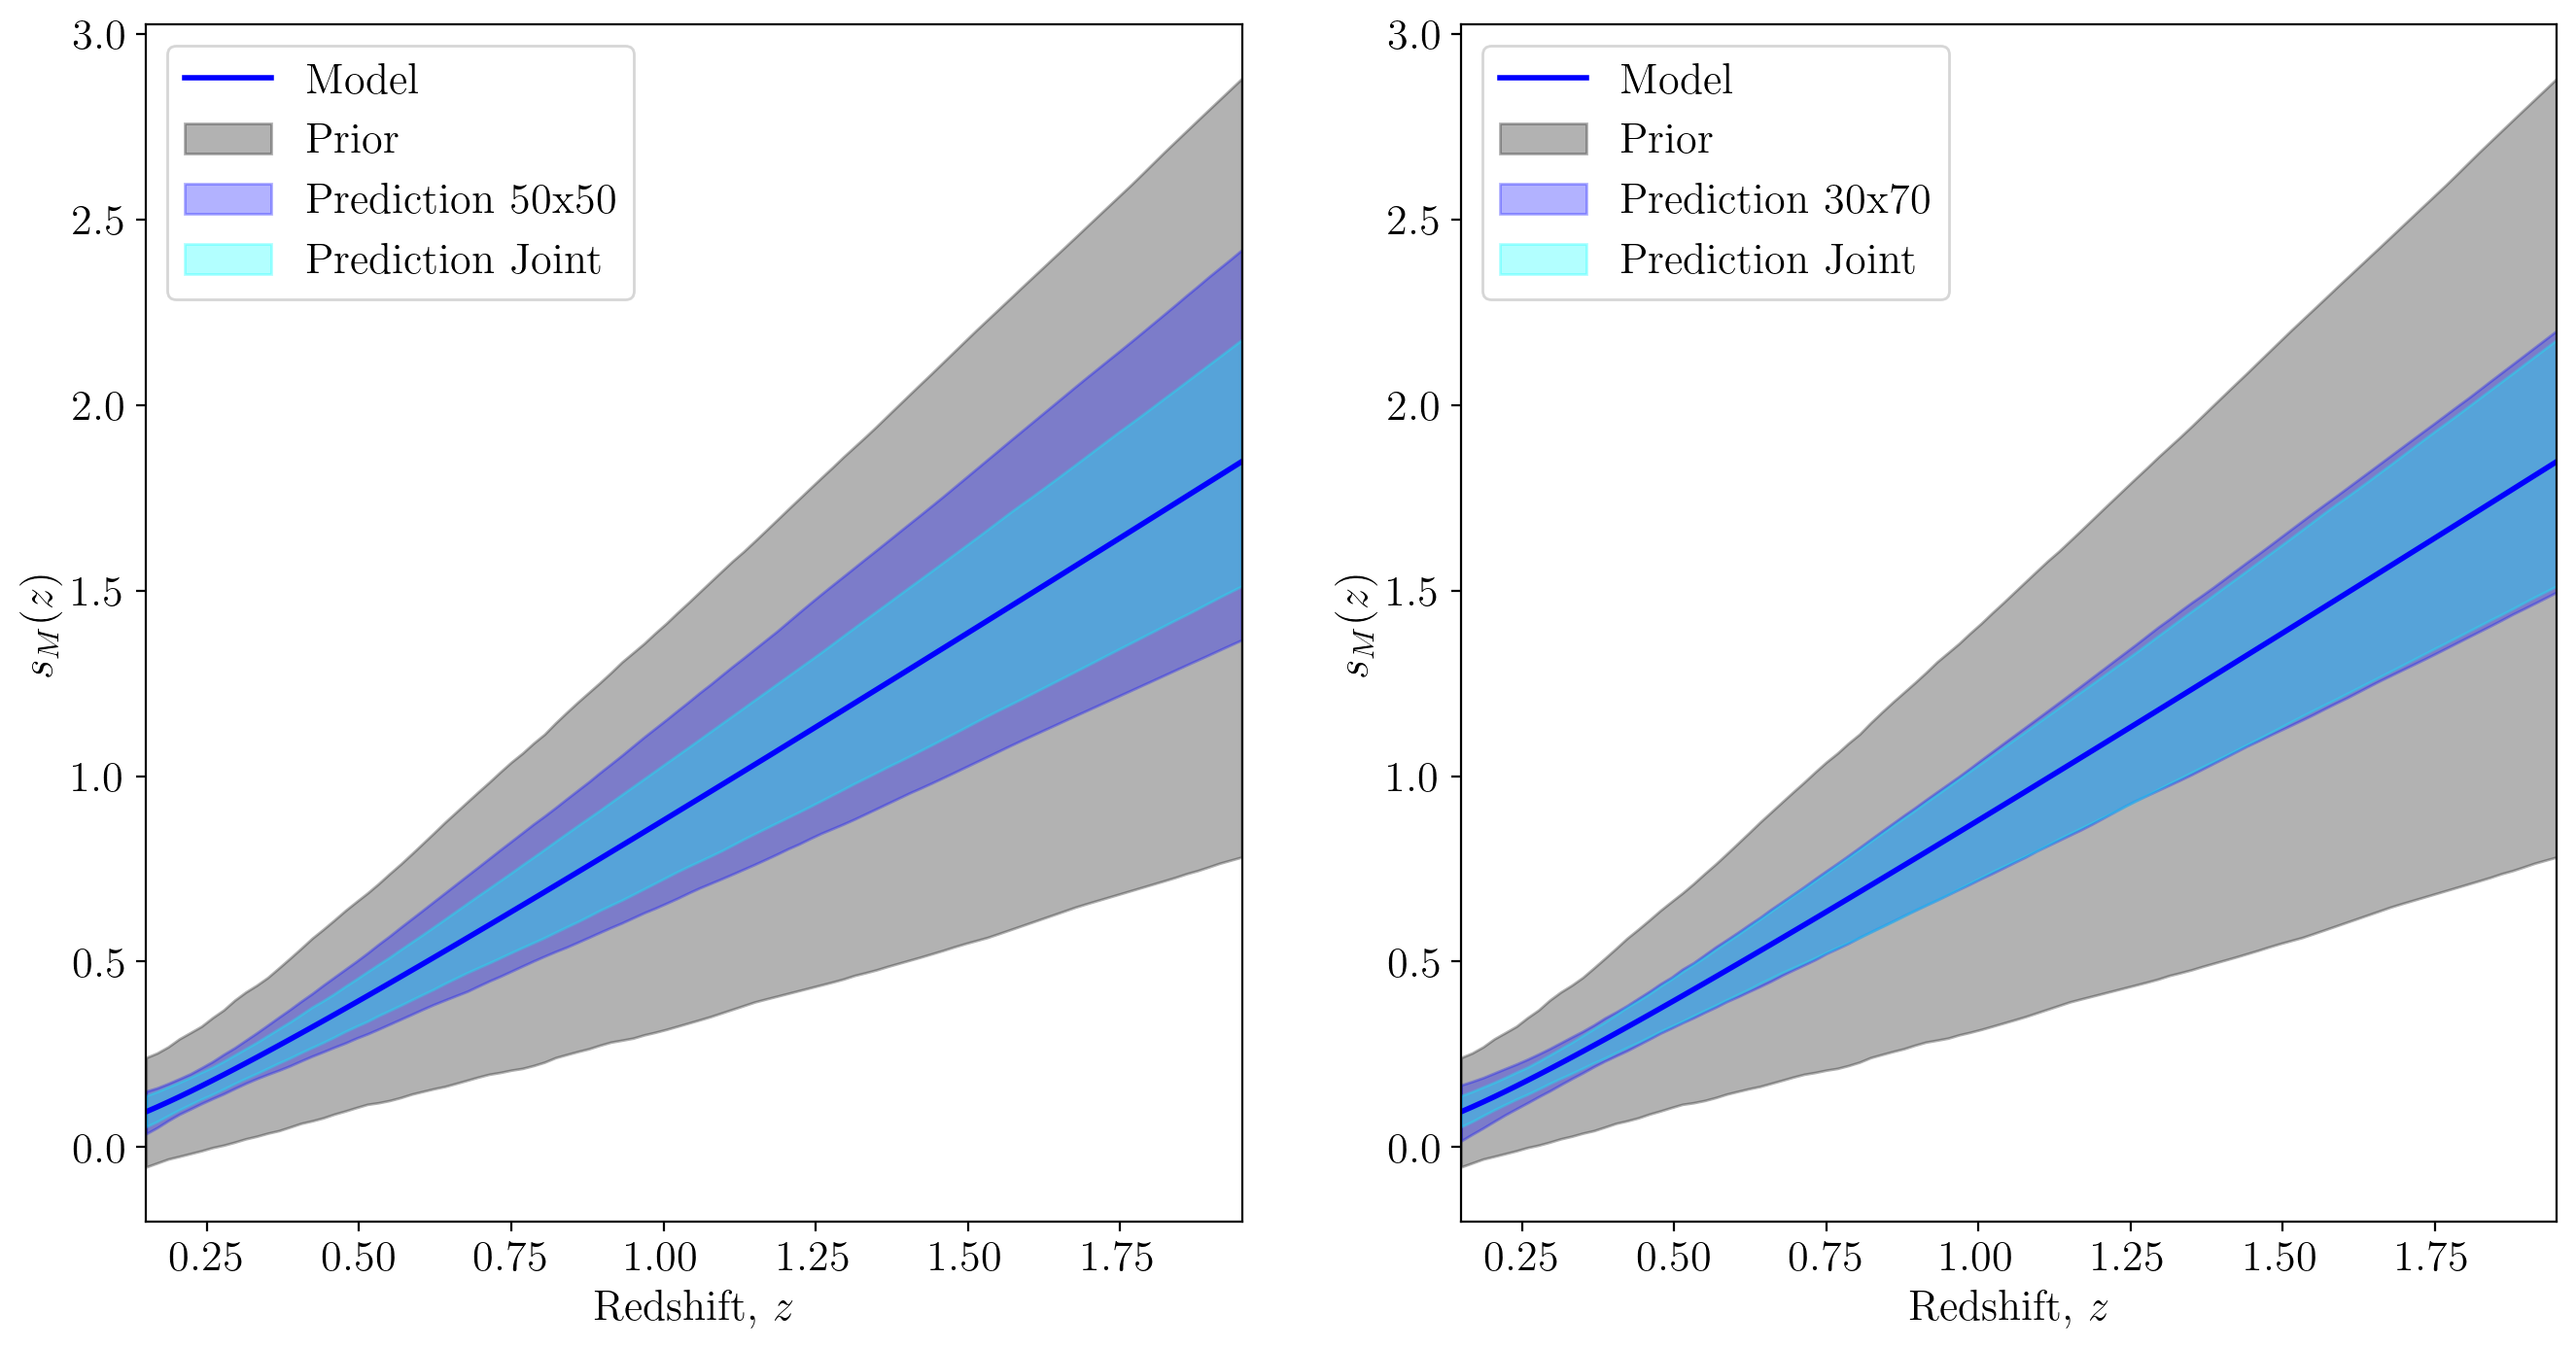

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

for axi in ax:
    axi.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label = 'Model')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
ax[0].fill_between(z_lin, sM_50_lower_bound, sM_50_upper_bound, color='blue', alpha=0.3, label = r'Prediction 50x50')
ax[0].fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='cyan', alpha=0.3, label = r'Prediction Joint')

ax[1].fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
ax[1].fill_between(z_lin, sM_30_lower_bound, sM_30_upper_bound, color='blue', alpha=0.3, label = r'Prediction 30x70')
ax[1].fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='cyan', alpha=0.3, label = r'Prediction Joint')
    
for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, $z$');
    axi.set_ylabel(r'$s_M(z)$');
    axi.legend(loc='upper left');
    
plt.savefig("plots/sM_prediction_joint_vs_prior.pdf", bbox_inches='tight', format='pdf')


### Magnification bias of the Faint, $s_F(z)$

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_M$ parameters.

In [122]:
sbias_50_fid = np.concatenate([sB_4fit50, sM_4fit])
sbias_30_fid = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_50_fid), np.shape(sbias_30_fid)

((8,), (8,))

In [123]:
# Select the marginalized covariance matrix for the magnification biases together
cov_50_sbias = Sigma_Matrix_50[:8, :8]
cov_30_sbias = Sigma_Matrix_30[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_50_pars_samples = np.random.multivariate_normal(sbias_50_fid, cov_50_sbias, num_samples)
sbias_30_pars_samples = np.random.multivariate_normal(sbias_30_fid, cov_30_sbias, num_samples)


# Evaluate fitting function for each parameter sample
sB_50_samples = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_50_pars_samples])
sB_30_samples = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_30_pars_samples])
sM_50_samples = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_50_pars_samples])
sM_30_samples = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_30_pars_samples])


# Compute the sF for each sample
sF_50_samples = sM_50_samples*m_50/(m_50-1) - sB_50_samples/(m_50-1)
sF_30_samples = sM_30_samples*m_30/(m_30-1) - sB_30_samples/(m_30-1)


# Calculate the 68% confidence interval
sF_50_lower_bound = np.percentile(sF_50_samples, 16, axis=0)
sF_50_upper_bound = np.percentile(sF_50_samples, 84, axis=0)

sF_30_lower_bound = np.percentile(sF_30_samples, 16, axis=0)
sF_30_upper_bound = np.percentile(sF_30_samples, 84, axis=0)

Compare with priors

In [124]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_50_priors = Cov_priors_50[:8, :8]
cov_sbias_30_priors = Cov_priors_30[:8, :8]


# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_50_pars_samples_priors = np.random.multivariate_normal(sbias_50_fid, cov_sbias_50_priors, num_samples)
sbias_30_pars_samples_priors = np.random.multivariate_normal(sbias_30_fid, cov_sbias_30_priors, num_samples)


# Evaluate fitting function for each parameter sample
sB_50_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_30_pars_samples_priors])
sM_50_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_50_pars_samples_priors])
sM_30_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_30_pars_samples_priors])

# Compute the sF for each sample
sF_50_samples_priors = sM_50_samples_priors*m_50/(m_50-1) - sB_50_samples_priors/(m_50-1)
sF_30_samples_priors = sM_30_samples_priors*m_30/(m_30-1) - sB_30_samples_priors/(m_30-1)

# Calculate the 68% confidence interval
sF_50_lower_bound_priors = np.percentile(sF_50_samples_priors, 16, axis=0)
sF_50_upper_bound_priors = np.percentile(sF_50_samples_priors, 84, axis=0)

sF_30_lower_bound_priors = np.percentile(sF_30_samples_priors, 16, axis=0)
sF_30_upper_bound_priors = np.percentile(sF_30_samples_priors, 84, axis=0)

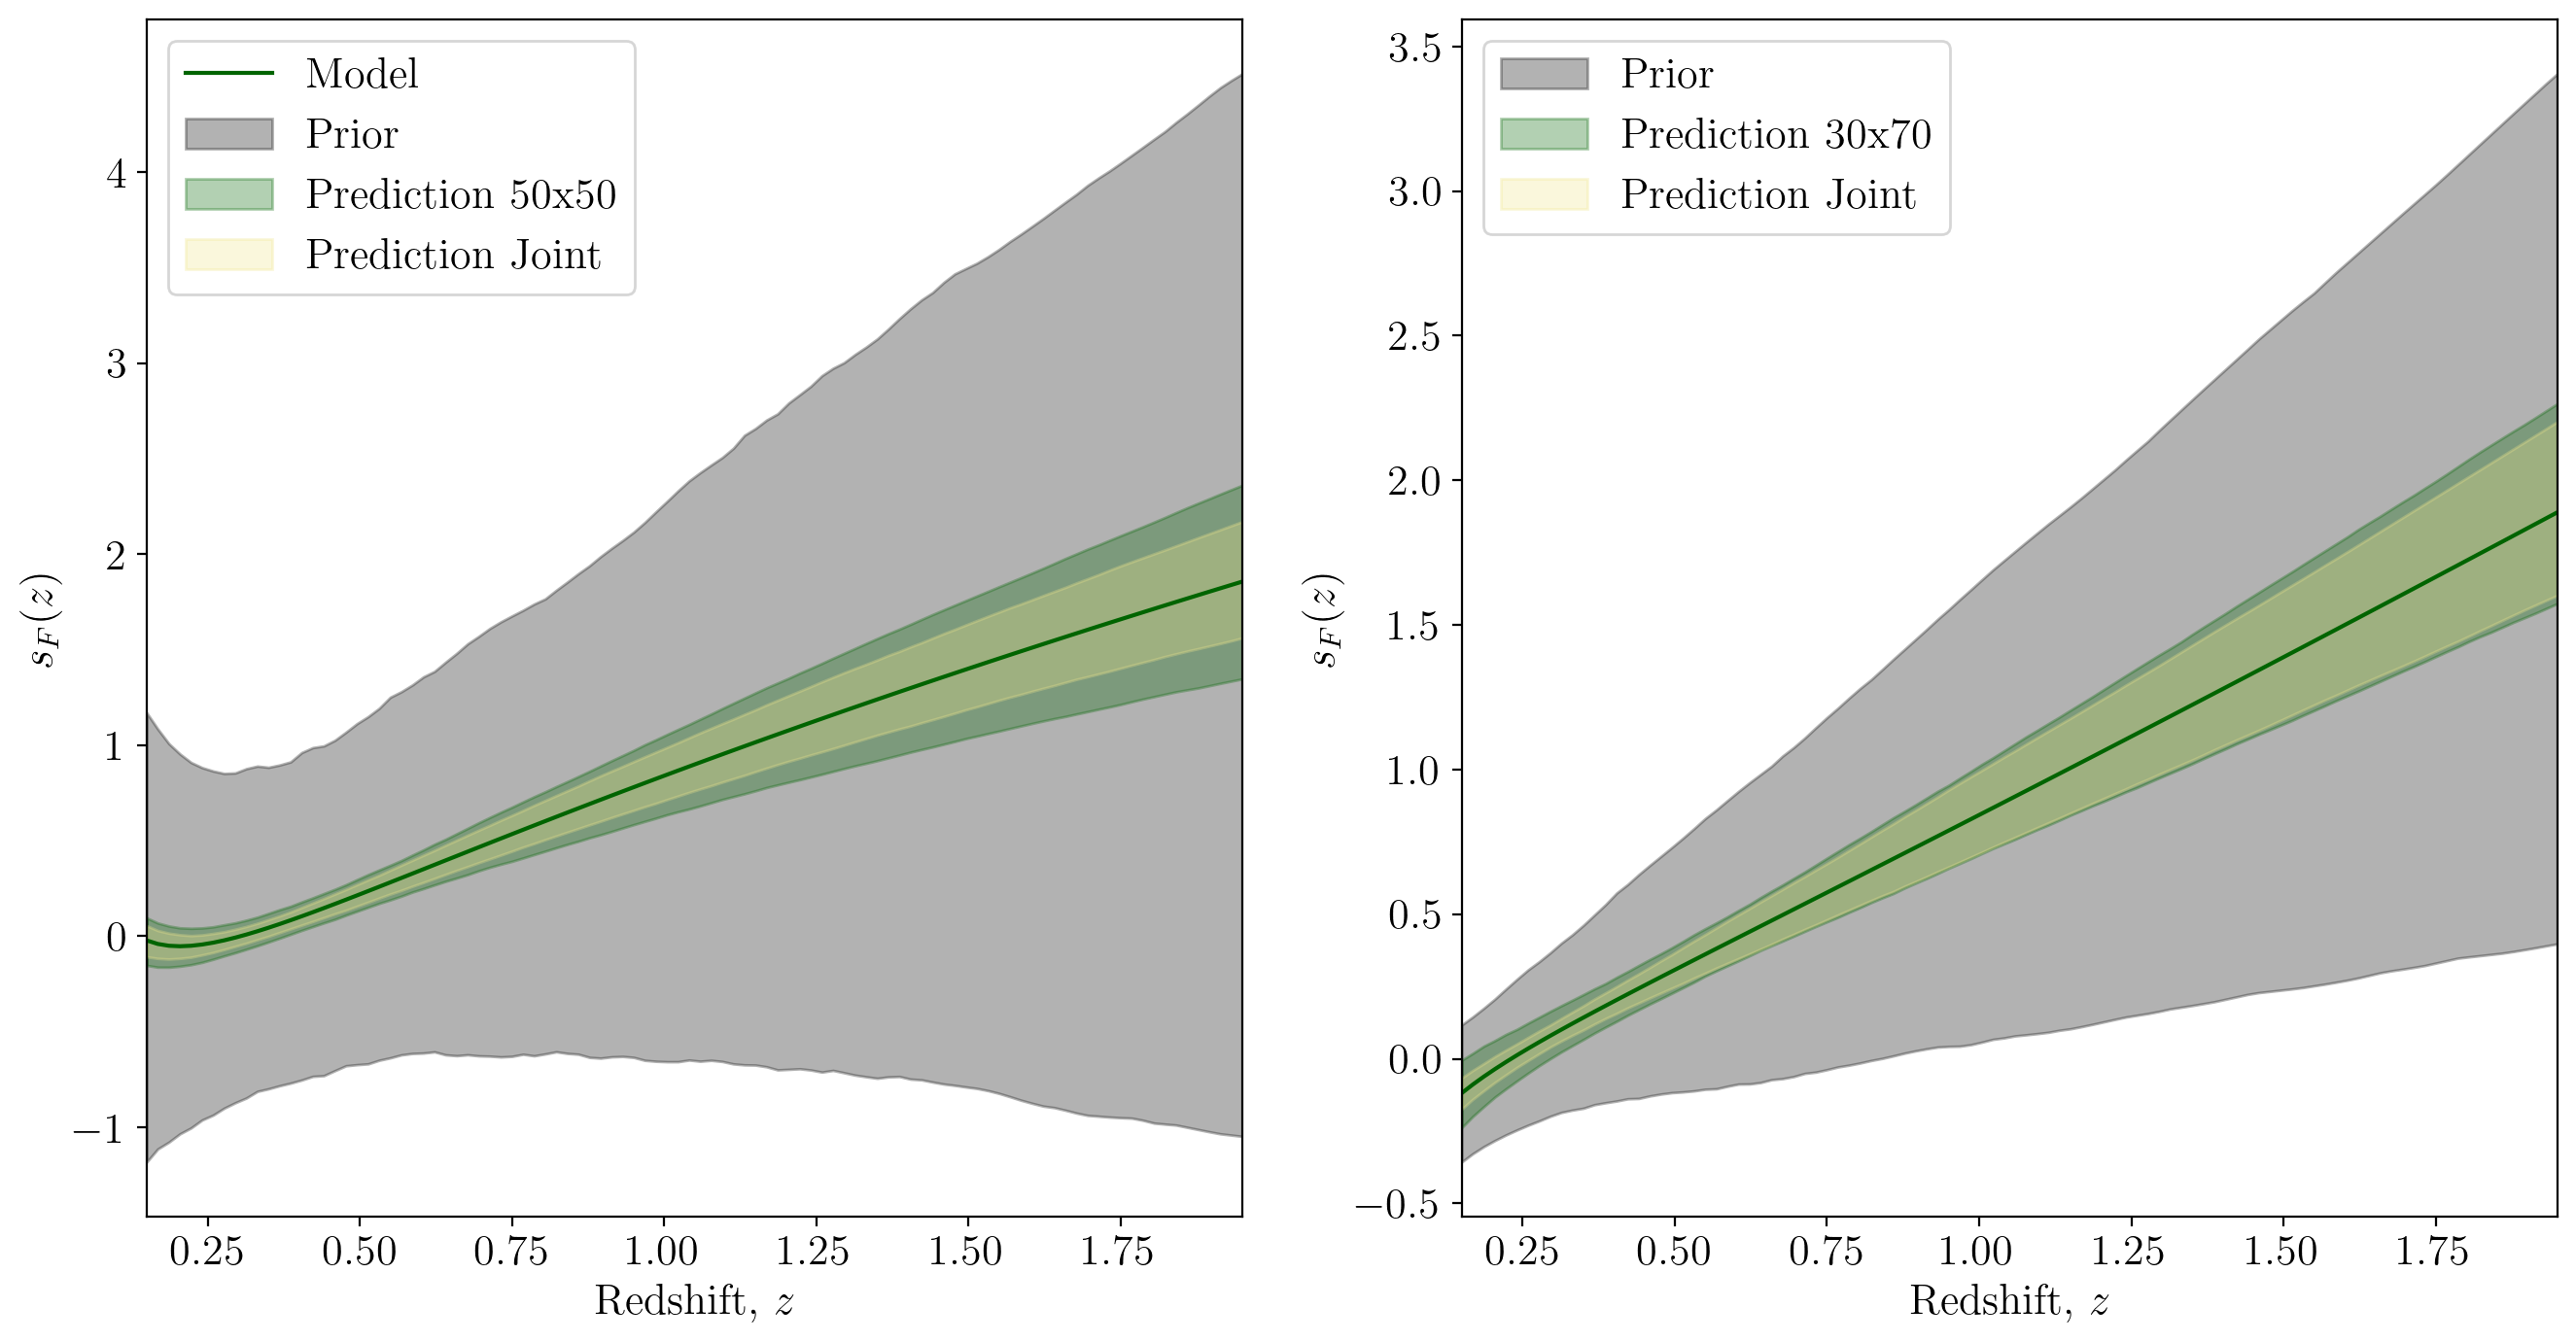

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sF_fid_50, '-', color = 'darkgreen', label = 'Model')
ax[0].fill_between(z_lin, sF_50_lower_bound_priors_, sF_50_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sF_50_lower_bound, sF_50_upper_bound, color='darkgreen', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, sF_50_Joint_lower_bound_, sF_50_Joint_upper_bound_, color='khaki', alpha=0.3, label = 'Prediction Joint')

ax[1].plot(z_lin, sF_fid_30, '-', color = 'darkgreen')
ax[1].fill_between(z_lin, sF_30_lower_bound_priors_, sF_30_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, sF_30_lower_bound, sF_30_upper_bound, color='darkgreen', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, sF_30_Joint_lower_bound_, sF_30_Joint_upper_bound_, color='khaki', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$s_F(z)$')
    axi.legend(loc='upper left')
    
plt.savefig("plots/sF_prediction_joint_vs_prior.pdf", bbox_inches='tight', format='pdf')

## Number evolution

In [126]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

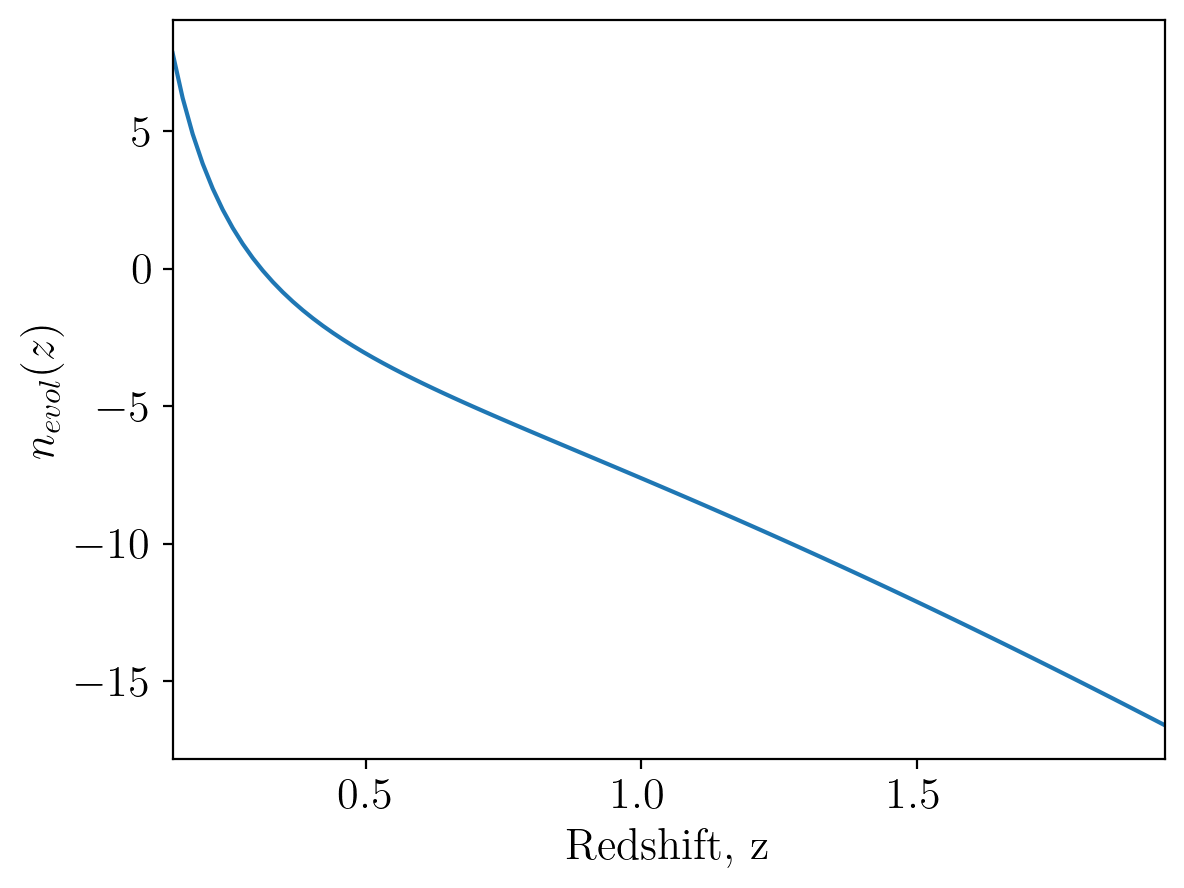

In [127]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(num_fit, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');
#plt.title('Fitting model for the number desnsitiy evolution');

In [128]:
# Select the marginalized covariance matrix for the number evolution

cov_50_numevol = Sigma_Matrix_50[8:12,8:12]
cov_30_numevol = Sigma_Matrix_30[8:12,8:12]



# Generate parameter samples from multivariate normal distribution
num_samples = 1000
nevol_50_pars_samples = np.random.multivariate_normal(num_fit, cov_50_numevol, num_samples)
nevol_30_pars_samples = np.random.multivariate_normal(num_fit, cov_30_numevol, num_samples)


# Evaluate fitting function for each parameter sample
nevol_50_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_50_pars_samples])
nevol_30_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_30_pars_samples])

# Calculate the 68% confidence interval
nevol_50_lower_bound = np.percentile(nevol_50_samples, 16, axis=0)
nevol_50_upper_bound = np.percentile(nevol_50_samples, 84, axis=0)
nevol_30_lower_bound = np.percentile(nevol_30_samples, 16, axis=0)
nevol_30_upper_bound = np.percentile(nevol_30_samples, 84, axis=0)


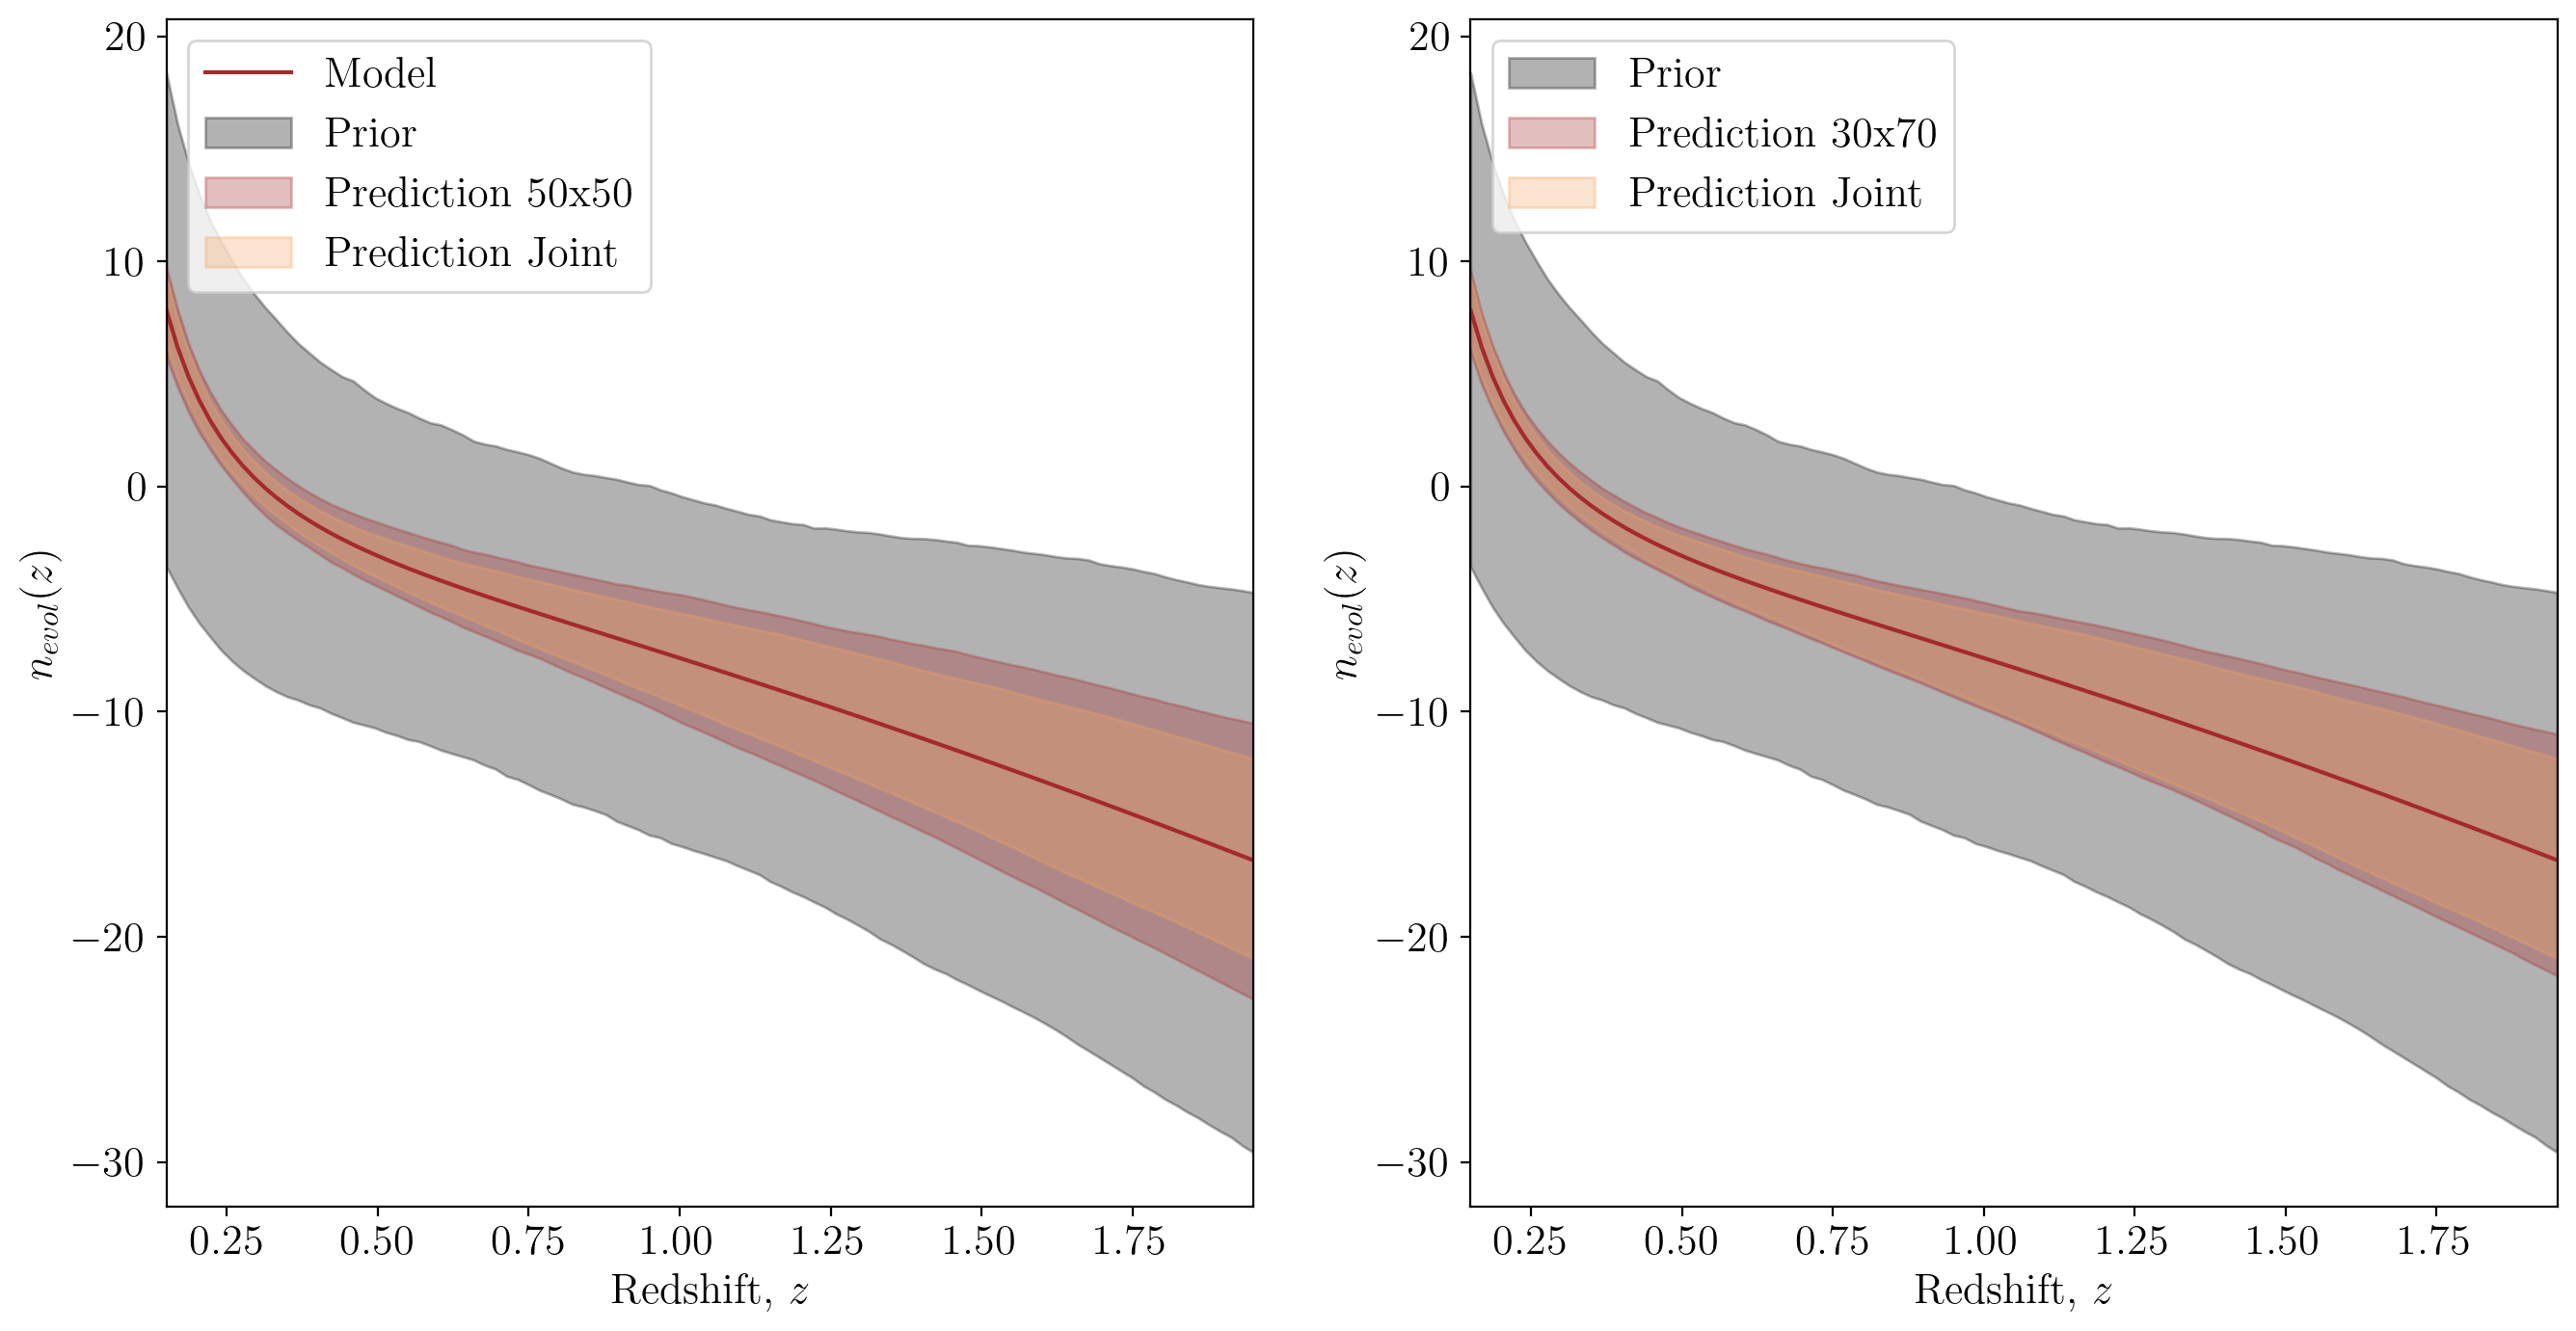

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, num_evol_fid, '-', color = 'brown', label = 'Model')
ax[0].fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, nevol_50_lower_bound, nevol_50_upper_bound, color='brown', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='sandybrown', alpha=0.3, label = 'Prediction Joint')

ax[1].plot(z_lin, num_evol_fid, '-', color = 'brown')
ax[1].fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, nevol_30_lower_bound, nevol_30_upper_bound, color='brown', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='sandybrown', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$n_{evol}(z)$')
    axi.legend(loc='upper left')
    
plt.savefig("plots/nevol_prediction_joint_vs_prior.pdf", bbox_inches='tight', format='pdf')

## Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [130]:
from biasmodels import EvolutionBias

In [131]:
myEvolBias_50 = EvolutionBias(n_split=m_50)
myEvolBias_30 = EvolutionBias(n_split=m_30)


dlogH = myEvolBias_50.dlogH
rHterm = myEvolBias_50.rHterm
dFstar = myEvolBias_50.dLogFstar
dFcut = myEvolBias_50.dLogFcut

In [132]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

In [133]:
sbias_fid_50 = np.concatenate([sB_4fit50, sM_4fit])
sbias_fid_30 = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_fid_50), np.shape(sbias_fid_30)

((8,), (8,))

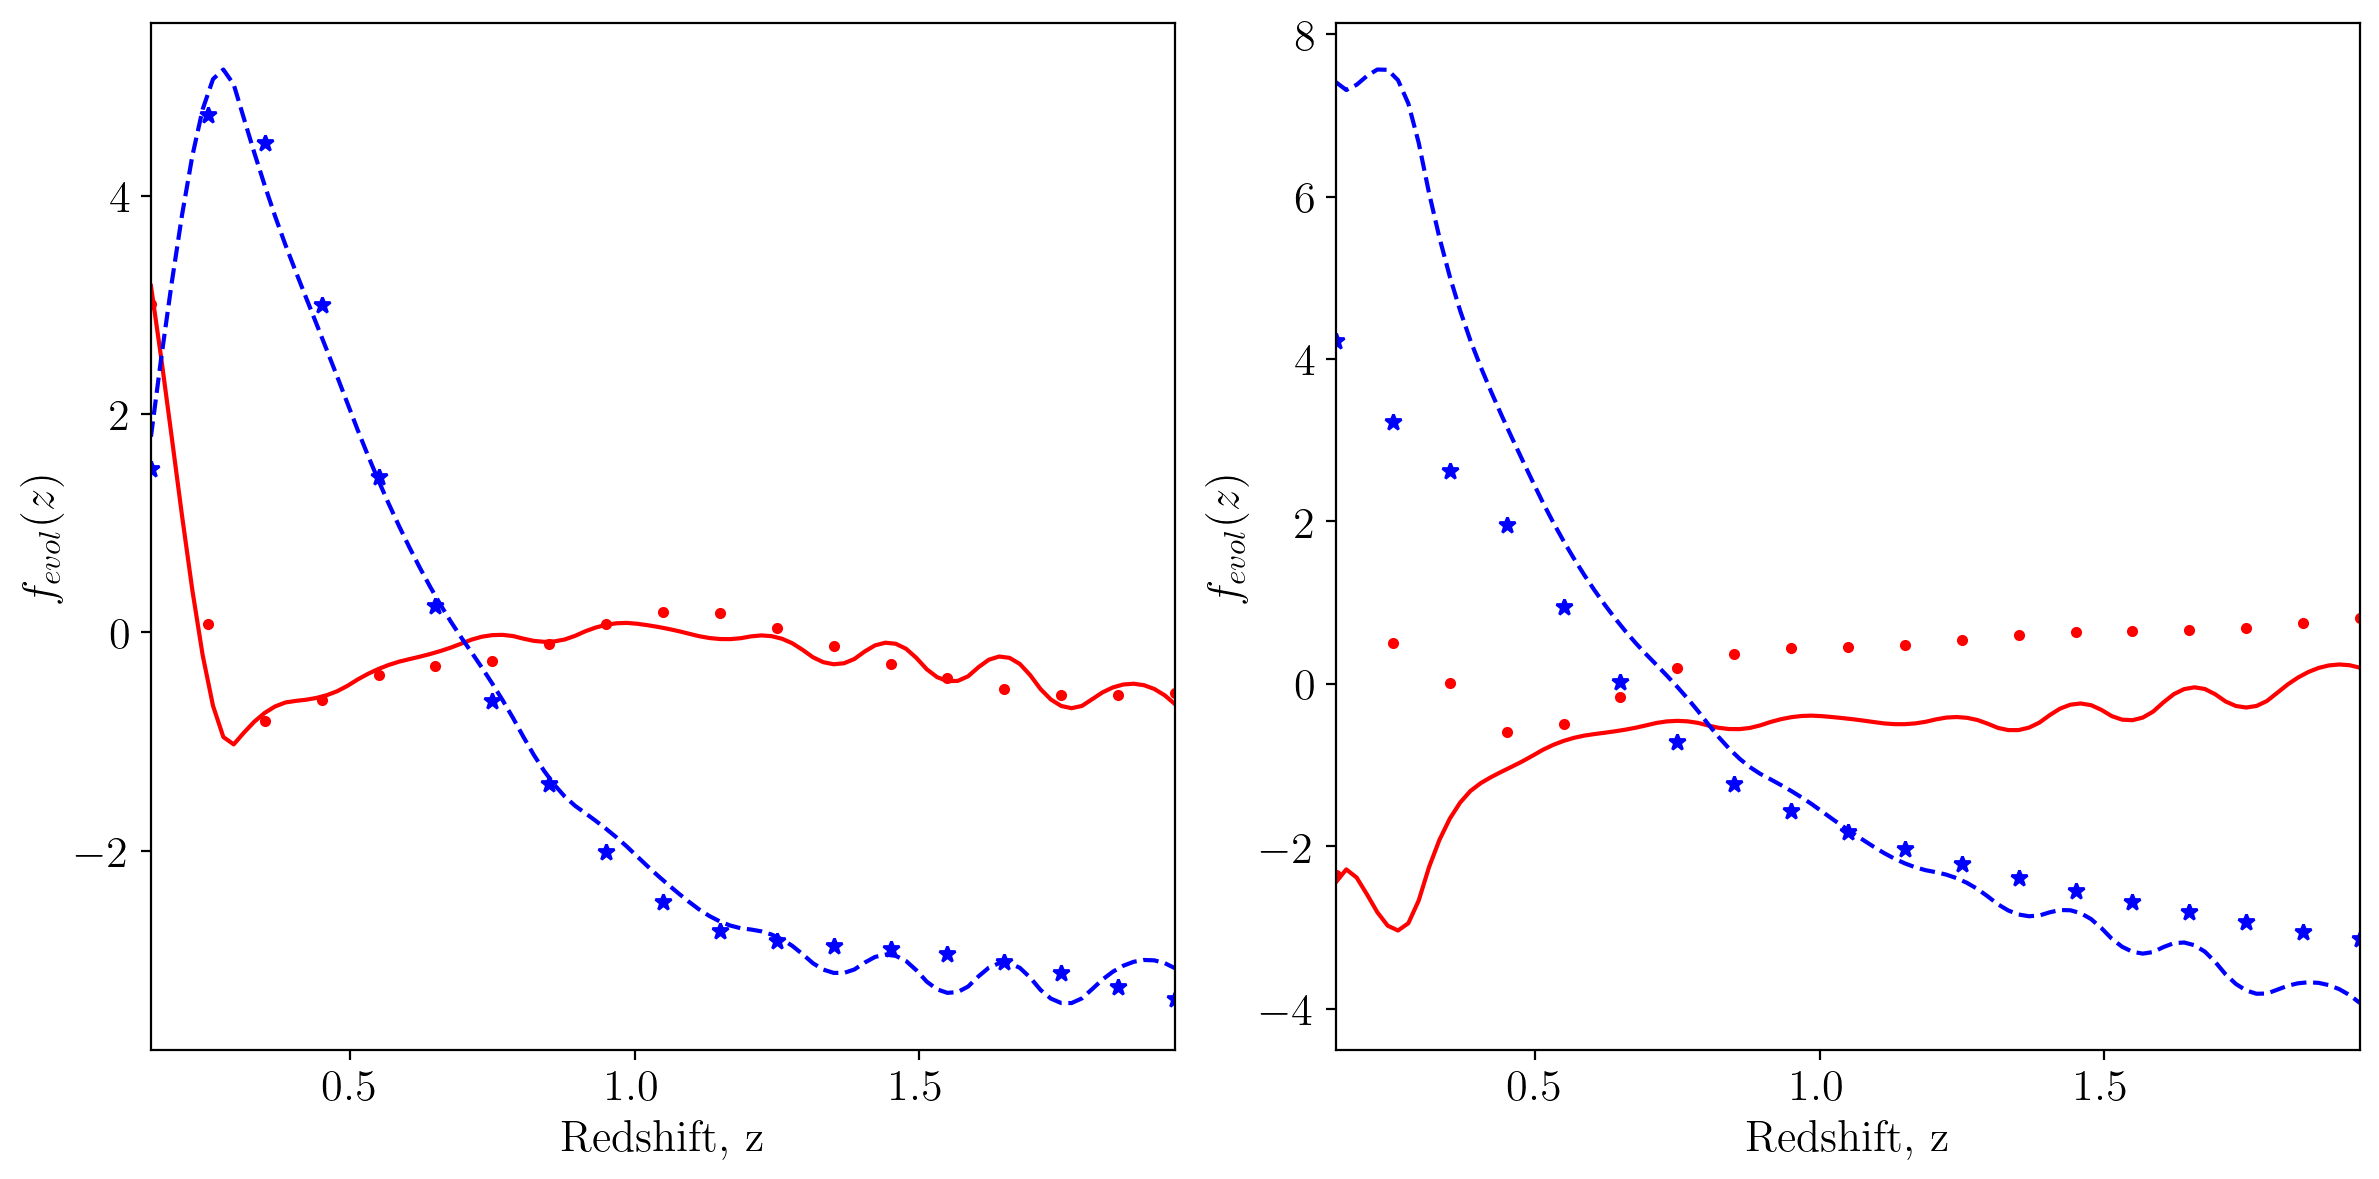

In [134]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_50_B_fid = fevol_bright(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)
fevol_50_F_fid = fevol_faint(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)

fevol_30_B_fid = fevol_bright(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)
fevol_30_F_fid = fevol_faint(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)

feB_50 = myEvolBias_50.fevol_bright(z_bins)
feF_50 = myEvolBias_50.fevol_faint(z_bins)

feB_30 = myEvolBias_30.fevol_bright(z_bins)
feF_30 = myEvolBias_30.fevol_faint(z_bins)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, 'r-')
ax[0].plot(z_lin, fevol_50_F_fid, 'b--')
ax[0].plot(z_bins, feB_50, 'r.', label='Bright')
ax[0].plot(z_bins, feF_50, 'b*', label='Faint')

ax[1].plot(z_lin, fevol_30_B_fid, 'r-')
ax[1].plot(z_lin, fevol_30_F_fid, 'b--')
ax[1].plot(z_bins, feB_30, 'r.', label='Bright')
ax[1].plot(z_bins, feF_30, 'b*', label='Faint')

for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, z');
    axi.set_ylabel(r'$f_{evol}(z)$');

In [135]:
all_50_fid = np.concatenate([sB_4fit50, sM_4fit, num_fit])
all_30_fid = np.concatenate([sB_4fit30, sM_4fit, num_fit])

np.shape(all_50_fid), np.shape(all_30_fid)

((12,), (12,))

In [136]:
# Select the marginalized covariance matrix for the parameters

cov_50_all = Sigma_Matrix_50[:12, :12]
cov_30_all = Sigma_Matrix_30[:12, :12]
cov_50_priors = Cov_priors_50[:12, :12]
cov_30_priors = Cov_priors_30[:12, :12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
all_50_pars_samples = np.random.multivariate_normal(all_50_fid, cov_50_all, num_samples)
all_50_pars_samples_priors_ = np.random.multivariate_normal(all_50_fid, cov_50_priors, num_samples)
all_30_pars_samples = np.random.multivariate_normal(all_30_fid, cov_30_all, num_samples)
all_30_pars_samples_priors_ = np.random.multivariate_normal(all_30_fid, cov_30_priors, num_samples)

In [137]:
# Evaluate fitting function for each parameter sample

fevol_50_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples])
fevol_50_B_samples_priors_ = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors_])
fevol_50_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples])
fevol_50_F_samples_priors_ = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors_])

fevol_30_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples])
fevol_30_B_samples_priors_ = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors_])
fevol_30_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples])
fevol_30_F_samples_priors_ = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors_])

# Calculate the 68% confidence intervals

fevol_B_50_lower_bound_ = np.percentile(fevol_50_B_samples, 16, axis=0)
fevol_B_50_upper_bound_ = np.percentile(fevol_50_B_samples, 84, axis=0)
fevol_B_50_lower_bound_priors_ = np.percentile(fevol_50_B_samples_priors_, 16, axis=0)
fevol_B_50_upper_bound_priors_ = np.percentile(fevol_50_B_samples_priors_, 84, axis=0)

fevol_F_50_lower_bound_ = np.percentile(fevol_50_F_samples, 16, axis=0)
fevol_F_50_upper_bound_ = np.percentile(fevol_50_F_samples, 84, axis=0)
fevol_F_50_lower_bound_priors_ = np.percentile(fevol_50_F_samples_priors_, 16, axis=0)
fevol_F_50_upper_bound_priors_ = np.percentile(fevol_50_F_samples_priors_, 84, axis=0)

fevol_B_30_lower_bound_ = np.percentile(fevol_30_B_samples, 16, axis=0)
fevol_B_30_upper_bound_ = np.percentile(fevol_30_B_samples, 84, axis=0)
fevol_B_30_lower_bound_priors_ = np.percentile(fevol_30_B_samples_priors_, 16, axis=0)
fevol_B_30_upper_bound_priors_ = np.percentile(fevol_30_B_samples_priors_, 84, axis=0)

fevol_F_30_lower_bound_ = np.percentile(fevol_30_F_samples, 16, axis=0)
fevol_F_30_upper_bound_ = np.percentile(fevol_30_F_samples, 84, axis=0)
fevol_F_30_lower_bound_priors_ = np.percentile(fevol_30_F_samples_priors_, 16, axis=0)
fevol_F_30_upper_bound_priors_ = np.percentile(fevol_30_F_samples_priors_, 84, axis=0)

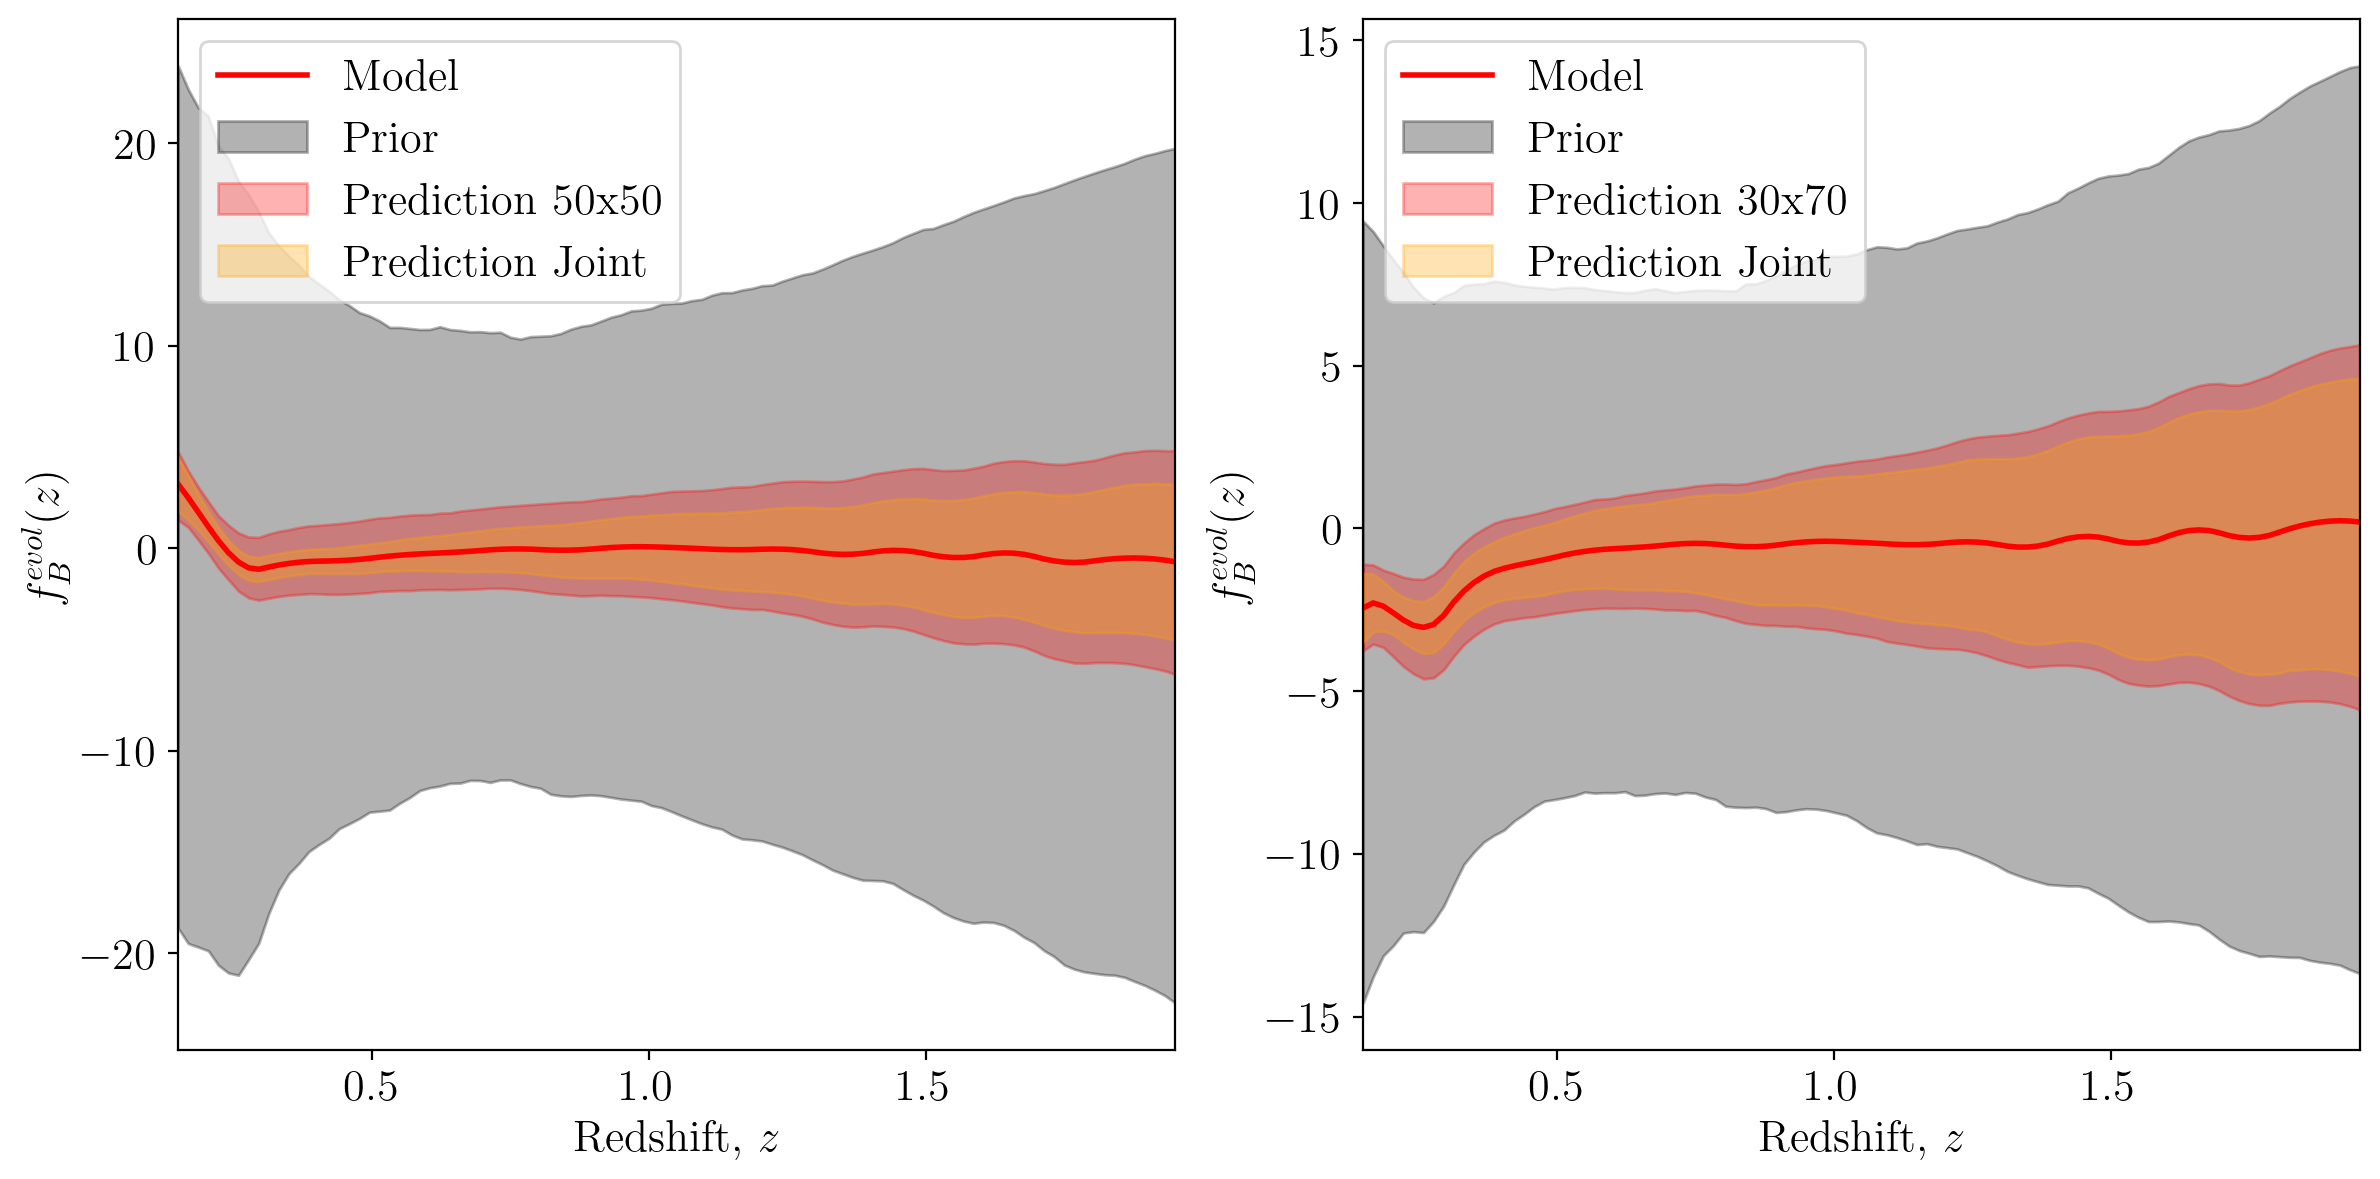

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, '-', color='red', lw = 2.0, label = 'Model')
#ax[0].plot(z_bins, feB_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_B_fid, '-', color='red', lw = 2.0, label = 'Model')
#ax[1].plot(z_bins, feB_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_B_50_lower_bound_priors, fevol_B_50_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_, fevol_B_50_upper_bound_, color='red', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, fevol_B_50_lower_bound, fevol_B_50_upper_bound, color='orange', alpha=0.3, label = 'Prediction Joint')

ax[1].fill_between(z_lin, fevol_B_30_lower_bound_priors, fevol_B_30_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_, fevol_B_30_upper_bound_, color='red', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, fevol_B_30_lower_bound, fevol_B_30_upper_bound, color='orange', alpha=0.3, label = 'Prediction Joint')

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_B(z)$')
    axi.legend(loc='upper left')
    
plt.savefig("plots/fevolB_prediction_joint_vs_prior.pdf", bbox_inches='tight', format='pdf')

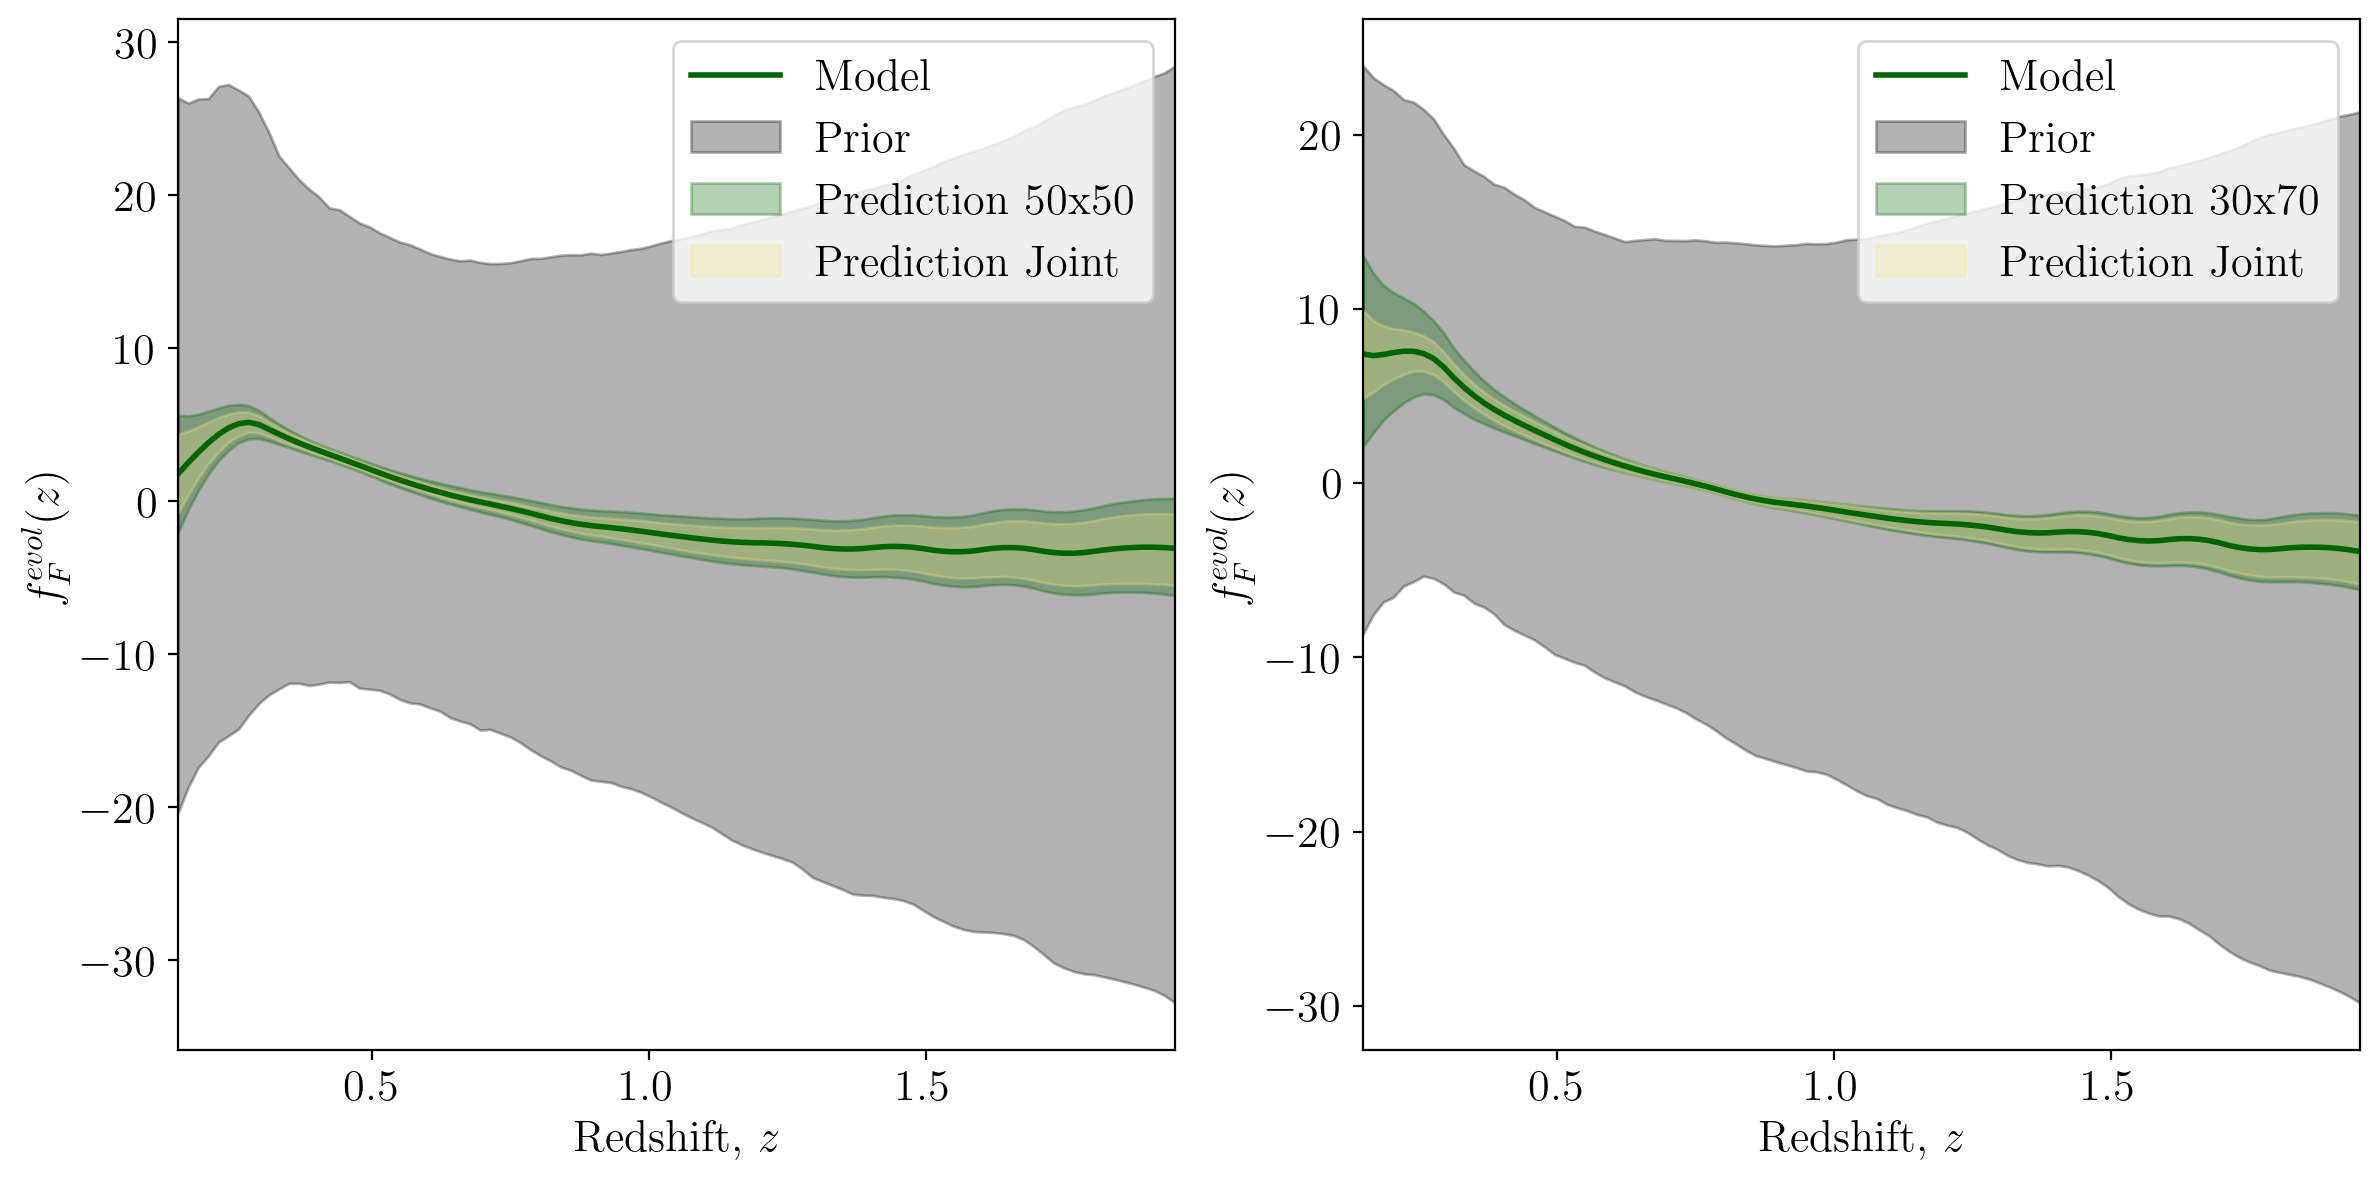

In [139]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_F_fid, '-', color='darkgreen', lw = 2.0, label = 'Model')
#ax[0].plot(z_bins, feF_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_F_fid, '-', color='darkgreen', lw = 2.0, label ='Model')
#ax[1].plot(z_bins, feF_30, '*', color='black')

# Shade the 68% confidence interval
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_priors, fevol_F_50_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_, fevol_F_50_upper_bound_, color='darkgreen', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, fevol_F_50_lower_bound, fevol_F_50_upper_bound, color='khaki', alpha=0.3, label = 'Prediction Joint')


ax[1].fill_between(z_lin, fevol_F_30_lower_bound_priors, fevol_F_30_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_, fevol_F_30_upper_bound_, color='darkgreen', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, fevol_F_30_lower_bound, fevol_F_30_upper_bound, color='khaki', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_F(z)$')
    axi.legend(loc='upper right')
    
plt.savefig("plots/fevolF_prediction_joint_vs_prior.pdf", bbox_inches='tight', format='pdf')